# Prephase
This notebook is for conducting an analysis, no finite plots will be constructed here.

# Imports

In [669]:
# If you are a developer, you may want to reload the packages on a fly. 
# Jupyter has a magic for this particular purpose:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import cooler
import pyranges as pr
from statsmodels.stats.multitest import multipletests as fdr_correction
from sklearn.feature_selection import f_classif
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
 
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

from glob import glob
import json
from os.path import basename, splitext
from importlib import reload
import gffpandas.gffpandas as gffpd
from natsort import natsorted

import utils
from utils.anova import *
from utils.gene_intervals import bins_to_genes_intersection
from utils.plot_functions import *
from utils.hic_preproc import *
reload(utils.anova)
reload(utils.plot_functions)
reload(utils.hic_preproc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'utils.hic_preproc' from '/home/dkriukov/mice/Aging_Brain_Mice/utils/hic_preproc.py'>

In [691]:
#crucial work dirs
COOLER_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/coolers'
MERGED_COOLER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_coolers'
DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/downsampled'
MERGED_DOWNSAMPLED_FOLDER_PATH = '/tank/projects/kriukov_chromatin/HIC/merged_downsampled'
INSULATION_PATH = '/tank/projects/kriukov_chromatin/HIC/insulation'
TAD_PATH = '/tank/projects/kriukov_chromatin/HIC/tads'
LOOP_PATH = '/tank/projects/kriukov_chromatin/HIC/loops'
COMPARTMENTS_PATH = '/tank/projects/kriukov_chromatin/HIC/compartments'
GENOME_FOLDER_PATH = '/tank/projects/kriukov_chromatin/GENOME'
ATAC_FOLDER_PATH = '/tank/projects/kriukov_chromatin/ATAC'
EXPRESSION_PATH = '/tank/projects/kriukov_chromatin/RNA'

In [341]:
#import genes
gffpath = '%s/GCF_000001635.27_GRCm39_genomic.gff' % GENOME_FOLDER_PATH
annot_path = '%s/GCF_000001635.27_GRCm39_assembly_report.txt' % GENOME_FOLDER_PATH
#refseq to chrom annotation
annotation = gffpd.read_gff3(gffpath)
fasta_annot = pd.read_csv(annot_path, sep='\t', skiprows=28)
refseq2chrom = dict(zip(fasta_annot['RefSeq-Accn'].values, fasta_annot['UCSC-style-name'].values))
gn = annotation.attributes_to_columns()
gn.seq_id = gn.seq_id.map(refseq2chrom)
gn['length'] = gn['end'] - gn['start']
gn = gn[['seq_id', 'source', 'type', 'start', 'end', 'score', 'strand',
         'ID', 'Name', 'description', 'length', 'chromosome']]

#types of sequences
gn_code = gn[gn['type']=='gene'] #protein codeing
gn_lnc = gn[gn['type']=='lnc_RNA'] #long non-coding
gn_trna = gn[gn['type']=='tRNA'] #tRNA
gn_rrna = gn[gn['type']=='rRNA'] #rRNA

In [611]:
#!ls /tank/projects/kriukov_chromatin/HIC/insulation
#!ls /tank/projects/kriukov_chromatin/HIC/downsampled/merged
#!ls /tank/projects/kriukov_chromatin/HIC/compartments

In [727]:
RESOLUTION = 50_000
downsampled = True
merged = True

if downsampled:
    if merged:
        FILES = natsorted(glob('%s/*.mcool' % (MERGED_DOWNSAMPLED_FOLDER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = [basename(c.filename).split('_')[0] for c in CLRS]
    else:
        FILES = natsorted(glob('%s/*.mcool' % (DOWNSAMPLED_FOLDER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = ['_'.join(basename(c.filename).split('_')[:3]) for c in CLRS]
else:
    if merged:
        FILES = natsorted(glob('%s/*.mcool' % (MERGED_COOLER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = [basename(c.filename).split('.')[0] for c in CLRS]
    else:
        FILES = natsorted(glob('%s/*.mcool' % (COOLER_FOLDER_PATH)))
        CLRS = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in FILES]
        LBLS = ['_'.join(basename(c.filename).split('_')[:3]).split('.')[0] for c in CLRS]

[print(c, '\t', l) for c, l in zip(CLRS, LBLS)];

#compartments
if merged:
    eigval_files = natsorted(glob(COMPARTMENTS_PATH + '/combined*lam.txt'))
    eigvec_files = natsorted(glob(COMPARTMENTS_PATH + '/combined*vecs.txt'))
    eigvec = {l:pd.read_csv(f, sep='\t') \
              for l, f in zip(['KO', 'WT', 'old', 'young'], eigvec_files)}
    eigval = {l:pd.read_csv(f, sep='\t', index_col=1) \
                for l, f in zip(['KO', 'WT', 'old', 'young'], eigval_files)}
else:
    eigval_files = natsorted(glob(COMPARTMENTS_PATH + '/*lam.txt'))
    eigvec_files = natsorted(glob(COMPARTMENTS_PATH + '/*vecs.txt'))
#     eigvec = {l:pd.read_csv(f, sep='\t') \
#               for l, f in zip(['KO', 'WT', 'old', 'young'], eigvec_files)}
#     eigval = {l:pd.read_csv(f, sep='\t', index_col=1) \
#                 for l, f in zip(['KO', 'WT', 'old', 'young'], eigval_files)}

#insulation score
if merged:
    IS = pd.read_csv('%s/IS_merged_50000.csv' % INSULATION_PATH, index_col=0)
else:
    #IS = pd.read_csv('%s/IS_25000.csv' % INSULATION_PATH, index_col=0)
    IS = pd.read_csv('%s/IS_50000.csv' % INSULATION_PATH, index_col=0)

#consensus peaks
ATAC = pd.read_csv('%s/consensus_peaks.mLb.clN.boolean.annotatePeaks.txt' % ATAC_FOLDER_PATH, sep='\t')

#TADs
TADS = json.load(open(TAD_PATH + '/' + 'lavaburst_tads_arkuda.json', 'r'))

#diffexpressed genes
slopes = pd.read_csv('subdata/diffexp_result.csv', index_col=0)
pbulk_full = pd.read_csv('subdata/DE_results_GSE129788_old::young.csv', index_col=0)
pbulk_neur = pd.read_csv('subdata/DE_results_GSE129788_old::young_mNeur.csv', index_col=0)
sc_neur =  pd.read_csv('subdata/scDE_results_GSE129788_old::young.csv', index_col=0)

<Cooler "KO_down_no_2_diag.10000.mcool::/resolutions/50000"> 	 KO
<Cooler "adl_down_no_2_diag.10000.mcool::/resolutions/50000"> 	 adl
<Cooler "old_down_no_2_diag.10000.mcool::/resolutions/50000"> 	 old
<Cooler "yng_down_no_2_diag.10000.mcool::/resolutions/50000"> 	 yng


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [159]:
#level spacing 
# colors = ['grey','grey','grey', 'blue','blue','blue', 'green','green','green', 'red','red','red']
# lbls = [basename(c.filename).split('_')[0] for c in CLRS]
# mats = [np.nan_to_num(c.matrix(balance=False).fetch('chr1')) for c in CLRS]
# corrs = [np.nan_to_num(np.corrcoef(m)) for m in mats]
# eigvals = [np.linalg.eigh(c)[0][::-1] for c in corrs]
# lvls = [np.abs(np.diff(e)) for e in eigvals]

# for e,l,col in zip(eigvals, lbls, colors):
#     sns.kdeplot(e, label=l, c=col)
# plt.xlim([0,1.5])
# plt.legend()

# for lvl,l,col in zip(lvls, lbls, colors):
#     sns.kdeplot(lvl, label=l, c=col)
# plt.xlim([-0.05,0.05])
# plt.legend()

# Basic vizualization

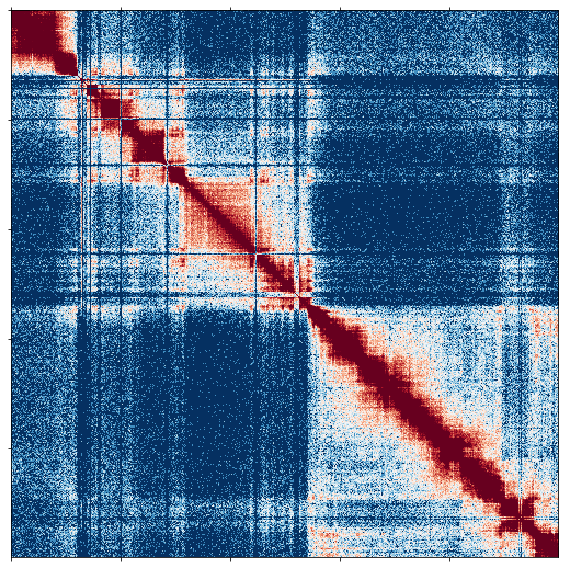

In [26]:
import cooltools
import cooltools.lib.plotting
### plot the corrected data in fall heatmap ###

clr = CLRS[0]

### to make a list of chromosome start/ends in bins:
chromstarts = []
for i in clr.chromnames:
    #print(f'{i} : {clr.extent(i)}')
    chromstarts.append(clr.extent(i)[0])

region = 'chr17:10,000,000-35,000,000'
vmax = 1.6
vmin = 0
fruitpunch = sns.blend_palette(['white', 'red'], as_cmap=True)

f, ax = plt.subplots(
    figsize=(8.6, 8),
    nrows=1,
    ncols=1,
    sharex=True, sharey=True)

ax.set_xticklabels([])
ax.set_yticklabels([])
im = ax.matshow(
    np.log10(clr.matrix(balance=False).fetch(region) + 1), 
    vmax=vmax, 
    vmin=vmin, 
    cmap='RdBu_r')
#plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, norm=norm)
#plt.xticks(chromstarts,clr.chromnames);

plt.tight_layout()
plt.savefig('figs/hic_miniature.pdf', format='pdf', dpi=300, bbox_inches='tight')

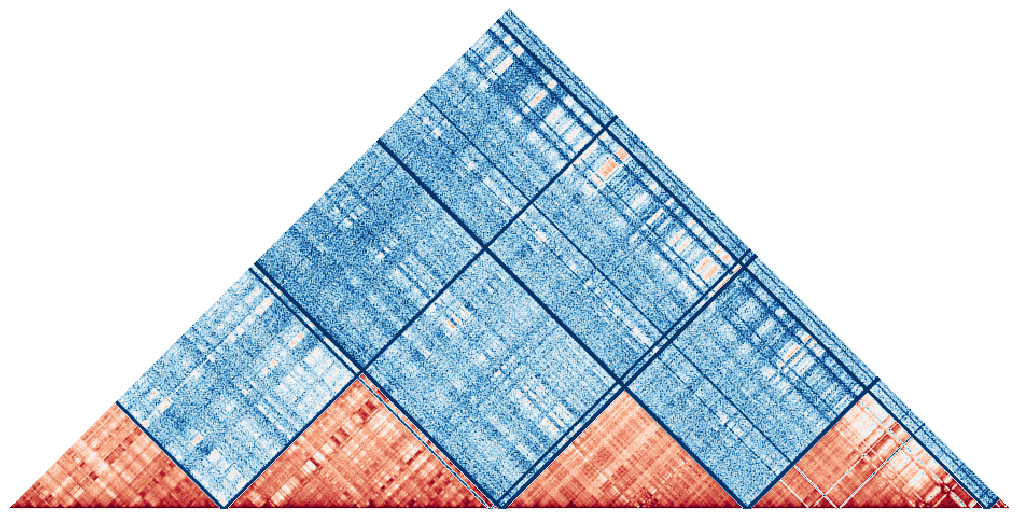

In [30]:
#large scale
pos = 155
st, fin = (pos-100, pos+560) # in bins

resolution = 1_000_000
file = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))[0]
cool = cooler.Cooler(file + "::/resolutions/%d" % resolution)

D = cool.matrix(balance=False)[:]
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom=='chr1'].index[0]

plot_hic(D, st, fin, profile=None, profnames=None, chrom_start=start, 
         savepath='figs/hic_pyramid_miniature_%d_interchromosomal.png' % resolution, vmax=9)

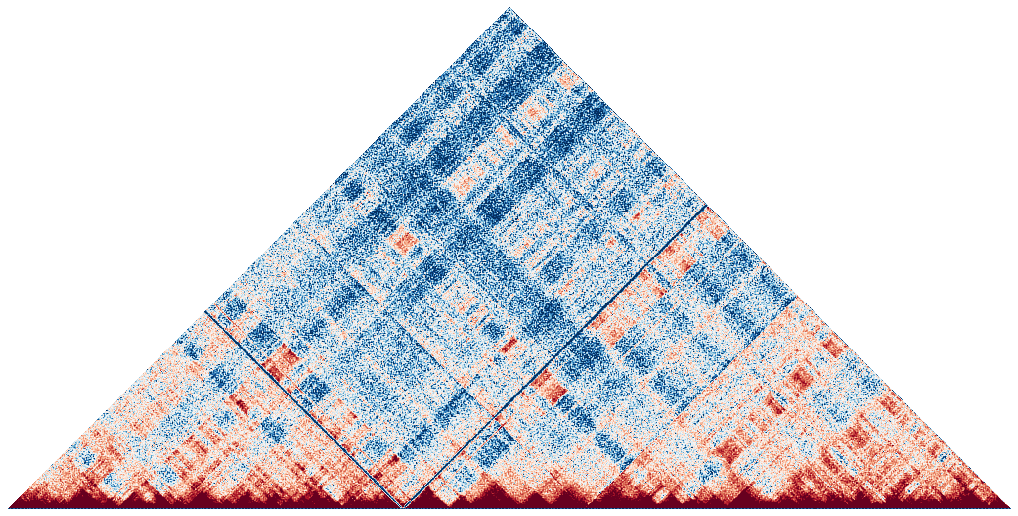

In [18]:
#chrom scale
pos = 155
st, fin = (pos-100, pos+700) # in bins

resolution = 250_000
file = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))[0]
cool = cooler.Cooler(file + "::/resolutions/%d" % resolution)

D = cool.matrix(balance=False).fetch('chr1')
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom=='chr1'].index[0]

plot_hic(D, st, fin, profile=None, profnames=None, chrom_start=start, 
        savepath='figs/hic_pyramid_miniature_%d_chromosomal.png' % resolution, vmin=-0.5, vmax=5)

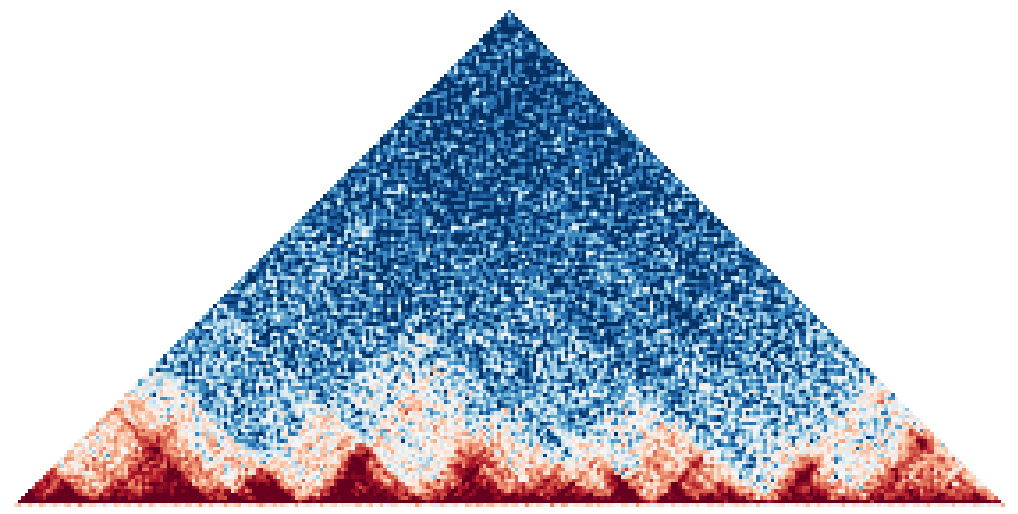

In [36]:
#medium scale
pos = 315
st, fin = (pos-100, pos+100) # in bins

resolution = 50_000
file = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))[0]
cool = cooler.Cooler(file + "::/resolutions/%d" % resolution)

D = cool.matrix(balance=False).fetch('chr1')
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom=='chr1'].index[0]

plot_hic(D, st, fin, profile=None, profnames=None, chrom_start=start, 
        savepath='figs/hic_pyramid_miniature_%d_medium.png' % resolution, vmax=5)

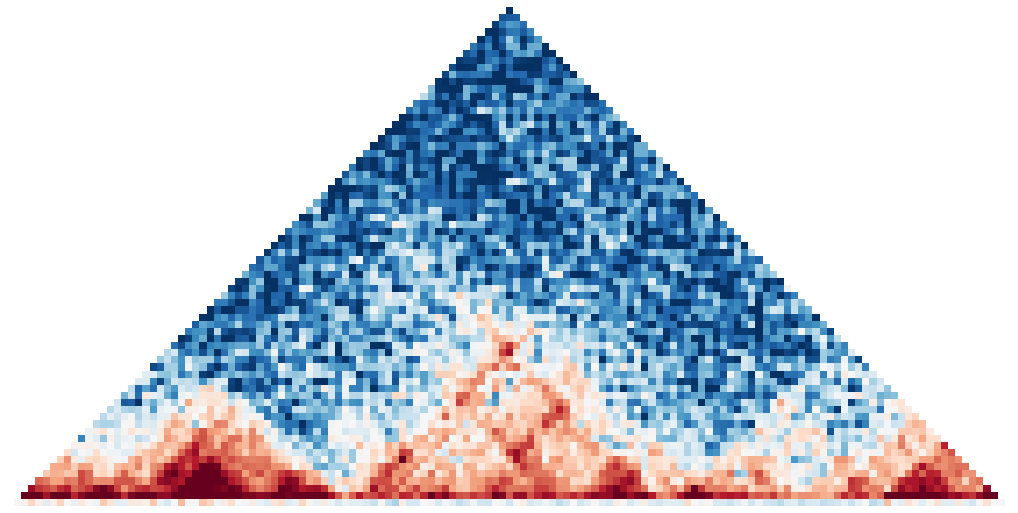

In [26]:
#point scale
pos = 900
st, fin = (pos-50, pos+50) # in bins

resolution = 50000
file = natsorted(glob('%s/*.mcool' % COOLER_FOLDER_PATH))[0]
cool = cooler.Cooler(file + "::/resolutions/%d" % resolution)

D = cool.matrix(balance=False).fetch('chr1')
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom=='chr1'].index[0]

plot_hic(D, st, fin, profile=None, profnames=None, chrom_start=start, vmax=6,
         savepath='figs/hic_pyramid_miniature_%d_res_point.png' % resolution)

## best dIS

In [199]:
top_idx = (IS['combined_old_down_50000'] - IS['combined_WT_down_50000']).abs().dropna()\
            .sort_values(ascending=False)[:10].index

In [200]:
IS.loc[top_idx.tolist()]

index  combined_KO_down_50000  combined_WT_down_50000  \
17548  17548               -0.173242               -0.398362   
45448  45448                0.322547                0.026515   
32893  32893                0.342404                0.083561   
24520  24520               -0.241125               -0.483470   
32892  32892                0.285676                0.022396   
24519  24519               -0.262055               -0.549872   
24521  24521               -0.331446               -0.551135   
13801  13801               -0.288198               -0.530448   
17549  17549               -0.290207               -0.505301   
45447  45447                0.215813               -0.092825   

       combined_old_down_50000  combined_young_down_50000  chrom      start  \
17548                -0.084496                  -0.283233   chr6   31300000   
45448                 0.331464                   0.183632  chr17   56400000   
32893                 0.373954                   0.267306  chr11  118600000   
24520                -0.193344                  -0.341015   chr8   84700000   
32892                 0.306157                   0.193242  chr11  118550000   
24519                -0.266484                  -0.418404   chr8   84650000   
24521                -0.269053                  -0.392454   chr8   84750000   
13801                -0.249326                  -0.361474   chr4  152350000   
17549                -0.224507                  -0.407348   chr6   31350000   
45447                 0.187865                   0.059397  chr17   56350000   

             end  
17548   31350000  
45448   56450000  
32893  118650000  
24520   84750000  
32892  118600000  
24519   84700000  
24521   84800000  
13801  152400000  
17549   31400000  
45447   56400000

In [25]:
CLRS

[<Cooler "combined_KO_down_50000.cool::/">,
 <Cooler "combined_WT_down_50000.cool::/">,
 <Cooler "combined_old_down_50000.cool::/">,
 <Cooler "combined_young_down_50000.cool::/">]

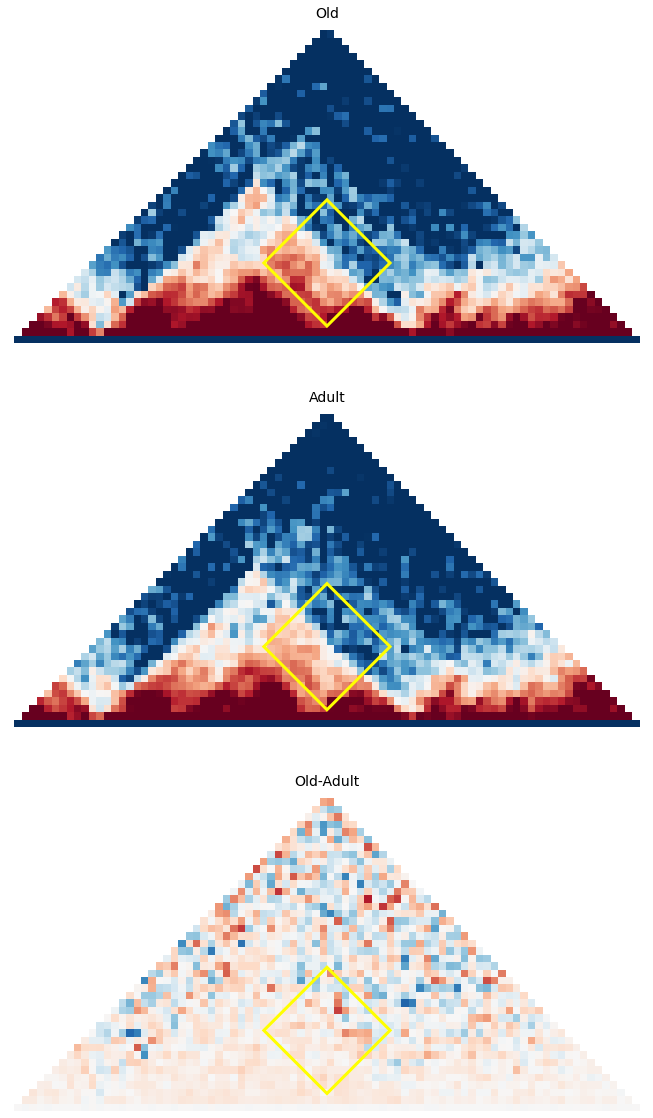

In [202]:
#dIS 
resolution = 50_000
w = 30
i = 5 #5

row = IS.loc[top_idx.tolist()][['chrom', 'start', 'end']].iloc[i]
row_chr = row['chrom']
row_start = row['start']
row_end = row['end']

cool = CLRS[2]
st, fin = (row_start-(w*resolution), row_end+(w*resolution)) # in coords
D1 = cool.matrix(balance=False).fetch('%s:%d-%d' % (row_chr, st, fin))[:]
D1 = mylog(D1, log=True)


cool = CLRS[1]
st, fin = (row_start-(w*resolution), row_end+(w*resolution)) # in coords
D2 = cool.matrix(balance=False).fetch('%s:%d-%d' % (row_chr, st, fin))[:]
D2 = mylog(D2, log=True)


fig, axes = plt.subplots(3, 1, figsize=(16,20), )
plot_hic_triangle(D1, profile=None, profnames=None, chrom_start=start, vmin=2, vmax=7, ax=axes[0])
plot_hic_triangle(D2, profile=None, profnames=None, chrom_start=start, vmin=2, vmax=7, ax=axes[1])
plot_hic_triangle(D1 - D2, profile=None, profnames=None, chrom_start=start, vmin=-4, vmax=4, ax=axes[2])
axes[0].set_title('Old', fontsize=14)
axes[1].set_title('Adult', fontsize=14)
axes[2].set_title('Old-Adult', fontsize=14)

import matplotlib.patches as patches
# x = [43, 33, 43, 53]
# y = [40, 25, 20, 25]

axes[0].add_patch(patches.Rectangle(xy=(42.5, 23.2), width=12, height=12, angle=45, 
                                    fill=False, color='yellow', lw=3))
axes[1].add_patch(patches.Rectangle(xy=(42.5, 23.2), width=12, height=12, angle=45, 
                                    fill=False, color='yellow', lw=3))
axes[2].add_patch(patches.Rectangle(xy=(42.5, 23.2), width=12, height=12, angle=45, 
                                    fill=False, color='yellow', lw=3))

Text(0.5, 1.0, 'Old-Adult')

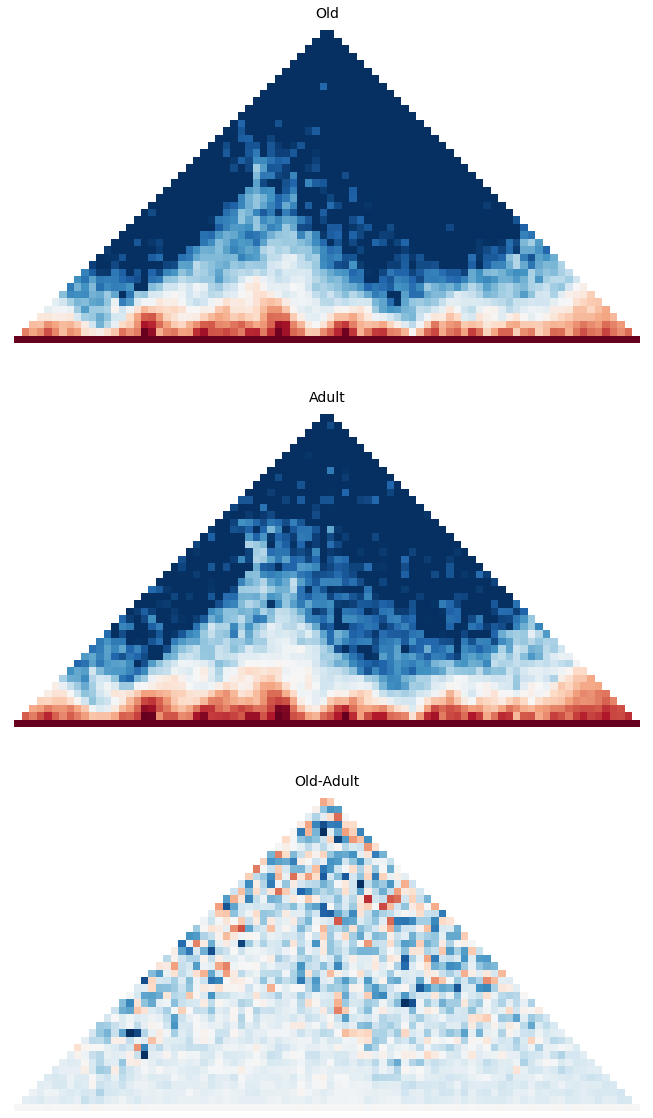

In [166]:
#dIS blanced maps
resolution = 50_000
w = 30
i = 5 #5

row = IS.loc[top_idx.tolist()][['chrom', 'start', 'end']].iloc[i]
row_chr = row['chrom']
row_start = row['start']
row_end = row['end']

cool = CLRS[2]
st, fin = (row_start-(w*resolution), row_end+(w*resolution)) # in coords
D1 = cool.matrix(balance=True).fetch('%s:%d-%d' % (row_chr, st, fin))[:]
D1 = mylog(D1, log=True)


cool = CLRS[1]
st, fin = (row_start-(w*resolution), row_end+(w*resolution)) # in coords
D2 = cool.matrix(balance=True).fetch('%s:%d-%d' % (row_chr, st, fin))[:]
D2 = mylog(D2, log=True)


fig, axes = plt.subplots(3, 1, figsize=(16,20), )
plot_hic_triangle(D1, profile=None, profnames=None, chrom_start=start, vmin=-11, vmax=-4, ax=axes[0])
plot_hic_triangle(D2, profile=None, profnames=None, chrom_start=start, vmin=-11, vmax=-4, ax=axes[1])
plot_hic_triangle(D1 - D2, profile=None, profnames=None, chrom_start=start, vmin=-4, vmax=4, ax=axes[2])
axes[0].set_title('Old', fontsize=14)
axes[1].set_title('Adult', fontsize=14)
axes[2].set_title('Old-Adult', fontsize=14)

# import matplotlib.patches as patches
# x = [43, 33, 43, 53]
# y = [40, 25, 20, 25]
# axes[0].add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False, color='magenta'))

# SCC

In [90]:
from hicrep.utils import readMcool
from hicrep import hicrepSCC
from itertools import combinations

binSize = 1_000_000 #put -1 if no .mcool
h = 1            # smoothing window half-size
dBPMax = 16_000_000 # maximal genomic distance to include in the calculation

# whether to perform down-sampling or not 
# if set True, it will bootstrap the data set # with larger contact counts to
# the same number of contacts as in the other data set; otherwise, the contact 
# matrices will be normalized by the respective total number of contacts
bDownSample = True

#paths = natsorted(glob(DOWNSAMPLED_FOLDER_PATH + '/*.cool'))
paths = FILES
# compute the SCC score
# this will result in a SCC score for each chromosome available in the data set
N = len(paths)
scc_matrix = np.zeros([N, N])
for i in tqdm(range(N)):
    for j in range(i, N):
        cool1, _ = readMcool(paths[i], binSize)
        cool2, _ = readMcool(paths[j], binSize)
        scc = hicrepSCC(cool1, cool2, h, dBPMax, bDownSample)
        scc_matrix[i,j] = np.nanmean(scc)
        scc_matrix[j,i] = np.nanmean(scc)

  0%|          | 0/12 [00:00<?, ?it/s]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/hicrep/hicrep.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return rhoNan2Zero @ wsNan2Zero / wsNan2Zero.sum()
100%|██████████| 12/12 [03:30<00:00, 17.53s/it]


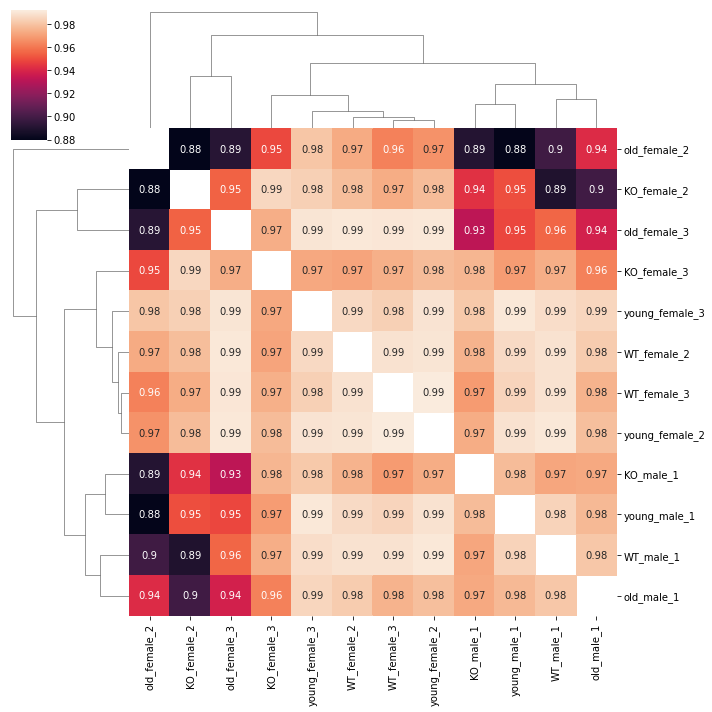

In [91]:
#add names
np.fill_diagonal(scc_matrix, 1)
scc_df = pd.DataFrame(scc_matrix, 
                      columns=[basename(path).split('.')[0] for path in paths],
                      index=[basename(path).split('.')[0] for path in paths])

sns.clustermap(scc_df, annot=True , mask=scc_df==1, method='complete')
#plt.savefig('./imgs/test.png', dpi=200)

# Scaling

In [673]:
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [674]:
#construct scalings
scalings_data = {}
for cond, clr in zip(LBLS, CLRS):
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    scalings_data[cond] = expected


In [675]:
# norm_coefs = []
# for clr in CLRS:
#     p = clr.pixels()[:]
#     diag_ratio = (p[p['bin1_id']==p['bin2_id']]['count'].sum() +\
#                   p[(p['bin1_id']+1)==p['bin2_id']]['count'].sum()) / clr.info['sum']
#     norm_coefs.append(1 / (1 - diag_ratio))
#     print(clr.filename, 1 / (1 - diag_ratio))

In [676]:
#aggregate expected data
column = 'count.sum'
log = False
scale = 'mb'
diagnorm = False

agg_scaling = pd.DataFrame()
for k, coef in zip(scalings_data.keys(), norm_coefs):
    if column in ['count.sum', 'balanced.sum', 'balanced.avg.smoothed']:
        if diagnorm:
            s = scalings_data[k].groupby('dist').mean()[column] #* coef
        else:
            s = scalings_data[k].groupby('dist').mean()[column]
    else:
        raise NotImplementedError
    if log:
        s = np.log10(s)
    agg_scaling[k] = s

if scale == 'kb':
    agg_scaling.index = clr.info['bin-size'] * np.arange(agg_scaling.shape[0]) // 1000 
elif scale == 'mb':
    agg_scaling.index = clr.info['bin-size'] * np.arange(agg_scaling.shape[0]) / 1_000_000 

KeyError: 'WT_female_2'

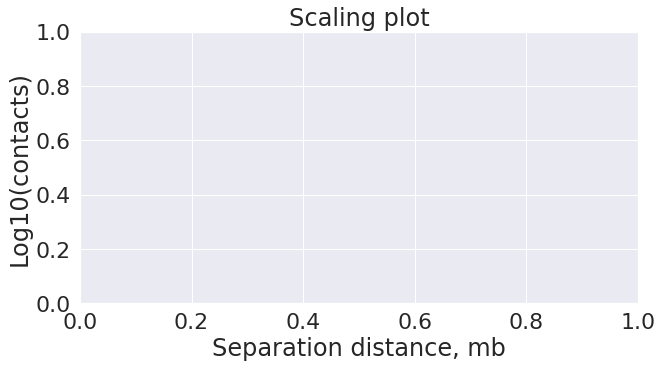

In [652]:
max_dist = 100
window = 20

#profiles = ['old', 'WT', 'young']
profiles = ['WT_female_2', 'WT_female_3','WT_male_1', 
            'old_female_2', 'old_female_3', 'old_male_1',
            'young_female_2', 'young_female_3', 'young_male_1']
plt.figure(figsize=(10,5))
plt.title('Scaling plot')
plt.xlabel(f'Separation distance, {scale}')
plt.ylabel(f'Log10(contacts)')
for p in profiles:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    s = np.log10(tmp[p])
    plt.semilogx(s, label = f'{p}', lw=1.5)
    #plt.plot(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.5)
plt.legend(loc=[1.05, -0.05])
plt.savefig('figs/scaling.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

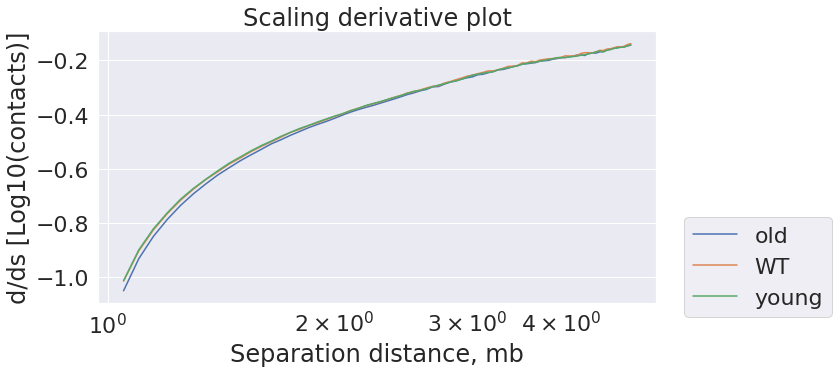

In [677]:
max_dist = 5
window = 20

profiles = ['old', 'WT', 'young']
# profiles = ['WT_female_2', 'WT_female_3','WT_male_1', 
#             'old_female_2', 'old_female_3', 'old_male_1',
#             'young_female_2', 'young_female_3', 'young_male_1']
plt.figure(figsize=(10,5))
plt.title('Scaling derivative plot')
plt.xlabel(f'Separation distance, {scale}')
plt.ylabel(f'd/ds [Log10(contacts)]')
for p in profiles:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    s = np.log10(tmp[p]).rolling(window = window).mean()
    sd = np.diff(s) / s.index[1]
    plt.semilogx(s.index[:-1], sd, label = f'{p}', lw=1.5)
    #plt.plot(s.index[:-1], sd, label = f'{p}', lw=1.5)
    #plt.plot(s)
    #plt.plot(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.5)
plt.legend(loc=[1.05, -0.05])
plt.savefig('figs/scaling_derivative.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

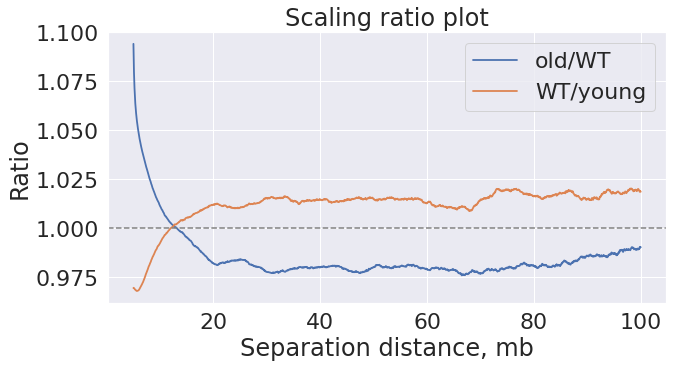

In [678]:
max_dist = 100
window = 100
pairs = [['old', 'WT'], ['WT', 'young']]
plt.figure(figsize=(10,5))
plt.title('Scaling ratio plot')
plt.xlabel(f'Separation distance, {scale}')
for pair in pairs:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    #rel = tmp[pair[0]] / tmp[pair[1]]
    #smooth = rel.rolling(window = window).mean()
    smooth = tmp[pair[0]].rolling(window = window).mean() / tmp[pair[1]].rolling(window = window).mean()
    #plt.plot(rel, label = f'{pair[0]}/{pair[1]}', alpha=0.5, lw=0.7)
    plt.plot(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.8)
plt.ylabel('Ratio')
plt.axhline(y=1.0, ls='--', color='grey', lw=1.5)    
plt.legend()
plt.savefig('figs/scaling_ratio.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

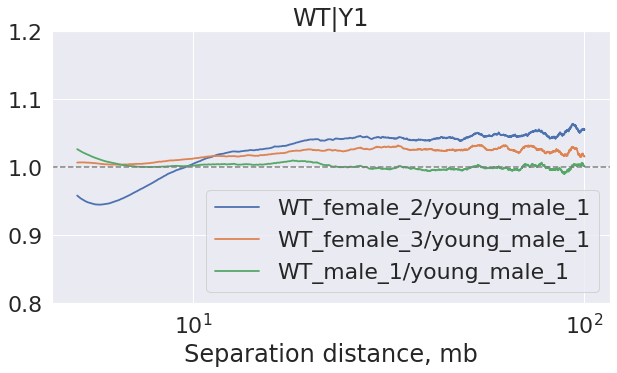

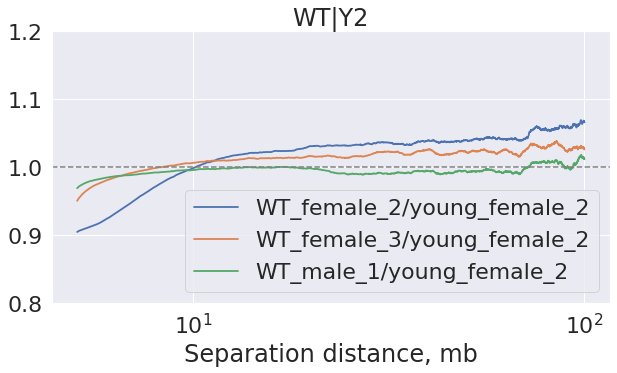

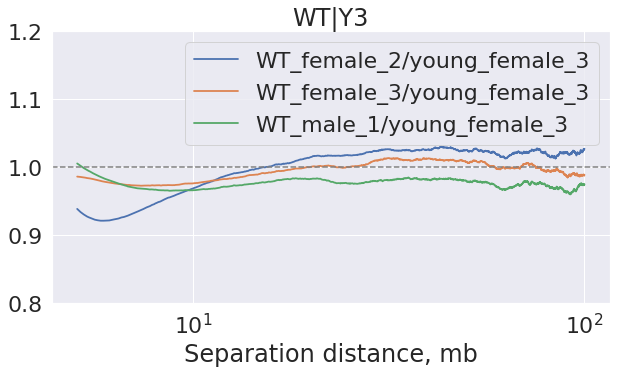

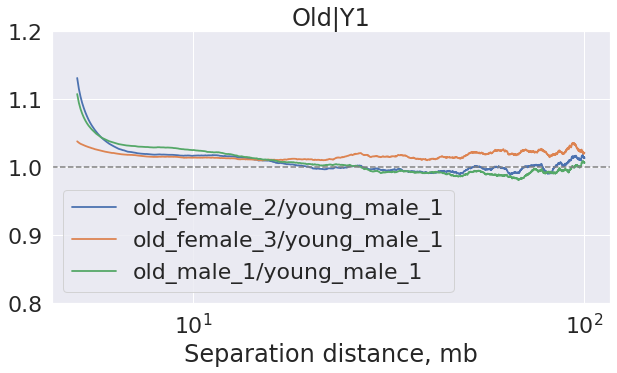

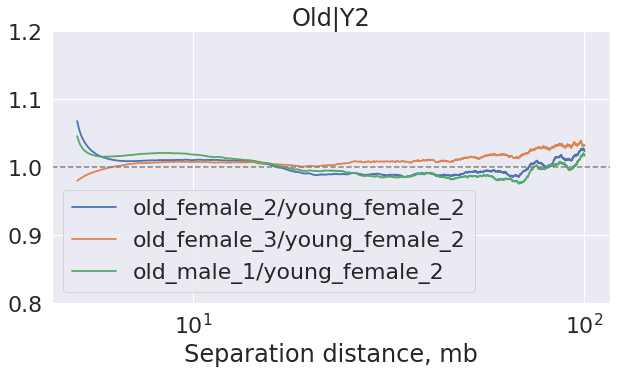

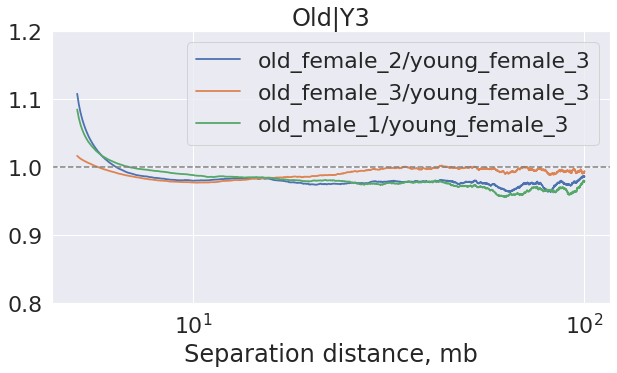

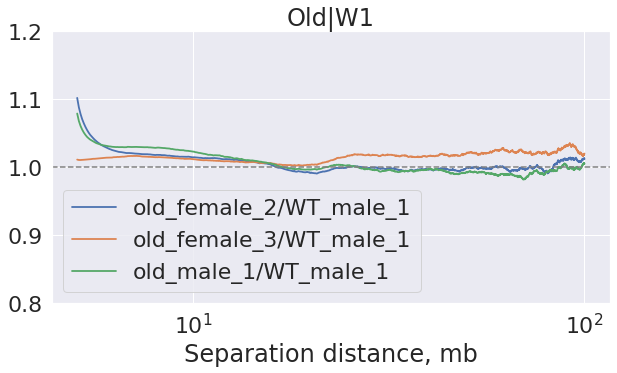

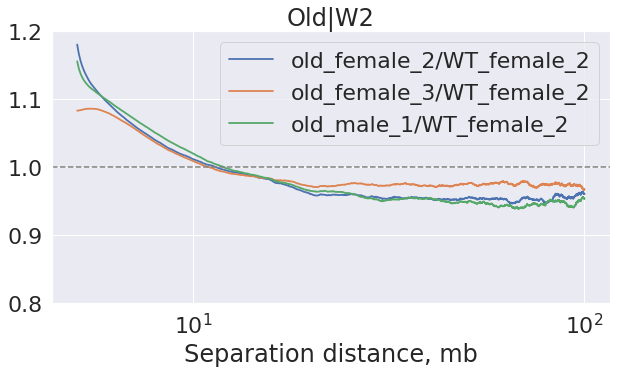

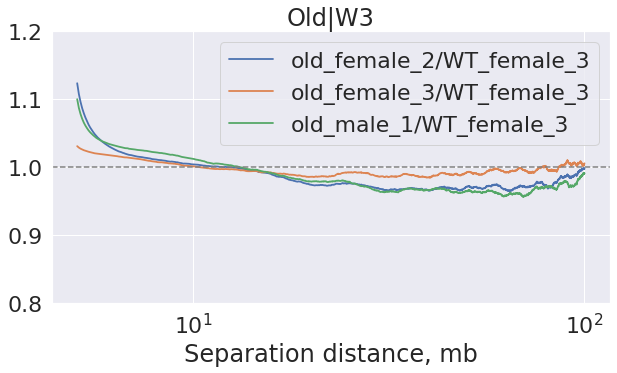

In [152]:
#all replica vs all
max_dist = 100
window = 100

#replicas = agg_scaling.columns[3:]
titles = ['WT|Y1', 'WT|Y2', 'WT|Y3', 'Old|Y1', 'Old|Y2', 'Old|Y3', 'Old|W1', 'Old|W2', 'Old|W3']
pair_blocks = [
            [['WT_female_2', 'young_male_1'], 
             ['WT_female_3', 'young_male_1'], 
             ['WT_male_1', 'young_male_1']],
            [['WT_female_2', 'young_female_2'], 
             ['WT_female_3', 'young_female_2'], 
             ['WT_male_1', 'young_female_2']],
            [['WT_female_2', 'young_female_3'], 
             ['WT_female_3', 'young_female_3'], 
             ['WT_male_1', 'young_female_3']],
    
            [['old_female_2', 'young_male_1'], 
             ['old_female_3', 'young_male_1'], 
             ['old_male_1', 'young_male_1']],
            [['old_female_2', 'young_female_2'], 
             ['old_female_3', 'young_female_2'], 
             ['old_male_1', 'young_female_2']],
            [['old_female_2', 'young_female_3'], 
             ['old_female_3', 'young_female_3'], 
             ['old_male_1', 'young_female_3']],
    
            [['old_female_2', 'WT_male_1'], 
             ['old_female_3', 'WT_male_1'], 
             ['old_male_1', 'WT_male_1']],
            [['old_female_2', 'WT_female_2'], 
             ['old_female_3', 'WT_female_2'], 
             ['old_male_1', 'WT_female_2']],
            [['old_female_2', 'WT_female_3'], 
             ['old_female_3', 'WT_female_3'], 
             ['old_male_1', 'WT_female_3']],
            ]

import base64
from io import BytesIO
html = ''
for title, pairs in zip(titles, pair_blocks):
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.xlabel(f'Separation distance, {scale}')
    for pair in pairs:
        tmp = agg_scaling[agg_scaling.index <= max_dist]
        #rel = tmp[pair[0]] / tmp[pair[1]]
        #smooth = rel.rolling(window = window).mean()
        smooth = tmp[pair[0]].rolling(window = window).mean() / tmp[pair[1]].rolling(window = window).mean()
        #plt.plot(rel, label = f'{pair[0]}/{pair[1]}', alpha=0.5, lw=0.7)
        plt.semilogx(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.8)
        #plt.plot(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.8)
    plt.axhline(y=1.0, ls='--', color='grey', lw=1.5)    
    plt.ylim([0.8, 1.2])
    plt.legend()
    plt.savefig('figs/scalings/scaling_ratio_%s.pdf' % title, dpi=300, bbox_inches='tight', format='pdf')
       
    #save to html
    tmpfile = BytesIO()
    plt.savefig(tmpfile, dpi=70, bbox_inches='tight', format='png') 
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html = html + '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

with open(f'figs/scalings/scalings_smooth_w={window}.html', 'w') as f:
    f.write(html)

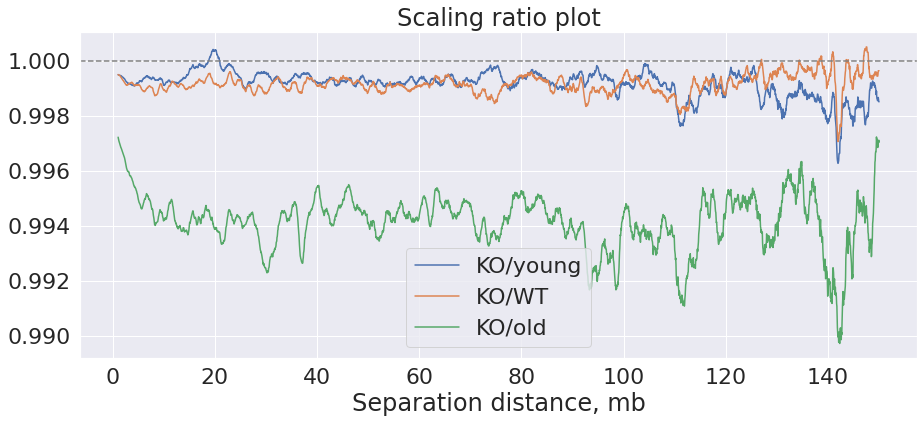

In [655]:
max_dist = 150
window = 20
pairs = [['KO', 'young'], ['KO', 'WT'], ['KO', 'old']]
plt.figure(figsize=(15,6))
plt.title('Scaling ratio plot')
plt.xlabel(f'Separation distance, {scale}')
for pair in pairs:
    tmp = agg_scaling[agg_scaling.index <= max_dist]
    rel = tmp[pair[0]] / tmp[pair[1]]
    smooth = rel.rolling(window = window).mean()
    #plt.plot(rel, label = f'{pair[0]}/{pair[1]}')
    plt.plot(smooth, label = f'{pair[0]}/{pair[1]}', lw=1.5)
plt.axhline(y=1.0, ls='--', color='grey', lw=1.5)    
plt.legend()
plt.show()

# Intra/Interchromosomal interactions

In [679]:
def compute_cis_trans(hiclist, dropdiag=2, resolution=100000, stable=True, normalized=False):
    """
    This function returns a dictionary where keys are names of Hi-C matrices
    and values are matrices of cis-trans contact sums.
    
    hiclist :: [str] - list of paths to .mcool files
    dropdiag :: int - number of diags to drop (main diagonal counts from 1)
    resolution :: int - desired resolution for Hi-C matrix
    stable :: bool - whether to add 1 to contact sums matrix (for numerical 
                     stability at logarithm computation)
    normalized :: bool - whether to normalize matrix with a total sum of contacts
    """
    interchrom = {}
    for path in tqdm(hiclist):
        #clr = cooler.Cooler(path + '::/resolutions/%d' % resolution)
        clr = cooler.Cooler(path)
        sizes = np.array(clr.chromsizes.values) / resolution #compute normalization matrix
        norm = np.outer(sizes, sizes)

        pix = clr.pixels()[:]
        pix_no_diag = pix[pix.bin2_id >= pix.bin1_id + dropdiag] #delete m first diagonals
        bins = clr.bins()[:].drop(['start', 'end'], 1)

        cis_trans = np.asarray(
                    pix_no_diag.merge(bins, left_on='bin1_id', right_index=True).\
                                merge(bins, left_on='bin2_id', right_index=True).\
                                groupby(['chrom_x', 'chrom_y']).sum().\
                                unstack(fill_value=0)['count']) #convert to square matrix

        cis_trans = cis_trans + cis_trans.T - np.diag(np.diag(cis_trans))
        if normalized:
            fullsum = np.nansum(cis_trans)
            if fullsum == 0.:
                print('Drop %s due to zero contact sum' % path)
                continue
            cis_trans = cis_trans / fullsum * 2 * 1_000_000 #scale by constant
        if stable:
            cis_trans += 1
        result = cis_trans / norm
        interchrom[splitext(basename(clr.filename))[0]] = result
    return interchrom

In [680]:
interactions = compute_cis_trans(FILES, dropdiag=0, resolution=50000, stable=True, normalized=False)

100%|███████████████████████████████████████████████████████████| 4/4 [01:59<00:00, 29.85s/it]


In [681]:
#uncomment this for merged maps
interactions = dict(zip([k.split('_')[1] for k in interactions.keys()], interactions.values()))
#interactions = dict(zip(['_'.join(k.split('_')[:3]) for k in interactions.keys()], interactions.values()))
chroms = CLRS[0].chromnames

In [682]:
[(k, v.sum()) for k,v in interactions.items()]

[('KO', 33.531333380639225),
 ('WT', 33.960419190073296),
 ('old', 33.205363053785796),
 ('young', 33.67534954764968)]

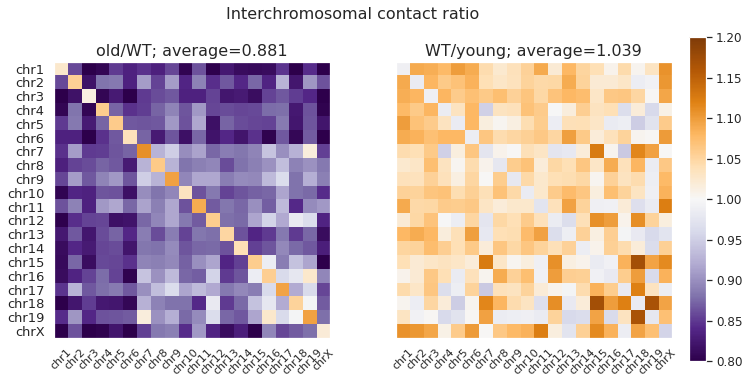

In [683]:
pairs = [('old', 'WT'), ('WT', 'young')]
statvals_cis = pd.DataFrame()
statvals_trs = pd.DataFrame()
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)
fig.suptitle('Interchromosomal contact ratio', fontsize=16, y=0.92, x=0.43)
fig.tight_layout(pad=1.2)
for k, ax, pair in zip(interactions.keys(), axes.flatten(), pairs):
    map1 = interactions[pair[0]][:-1, :-1]
    map2 = interactions[pair[1]][:-1, :-1]
    m = map1 / map2
    #np.fill_diagonal(m, np.nan)
    #for boxplots
    statvals_cis[pair[0] + '/' + pair[1]] = m.diagonal()
    statvals_trs[pair[0] + '/' + pair[1]] = m[np.triu_indices_from(m, k=1)]
    
    ax.set_title(pair[0] + '/' + pair[1] + '; average=%.3f' % np.nanmean(m), fontsize=16)
    im = ax.imshow(m, cmap='PuOr_r', vmax=1.2, vmin=0.8, extent=[-1,1,1,-1])
    
    tm_grid = np.arange(-1+1/len(chroms[:-1]), 1, 2/len(chroms[:-1]))
    ax.set_xticks(tm_grid)
    ax.set_yticks(tm_grid)
    ax.set_xticklabels(chroms[:-1], rotation=45, fontsize=11)
    ax.set_yticklabels(chroms[:-1], rotation=0, fontsize=13)
    ax.grid(False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.1, 0.02, 0.75])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
plt.savefig('figs/interchromosomal_contact_ratio.pdf', dpi=300, bbox_inches='tight', format='pdf')

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

old/WT v.s. WT/young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.796e-08 U_stat=4.000e+02
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

old/WT v.s. WT/young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.545e-62 U_stat=2.130e+02


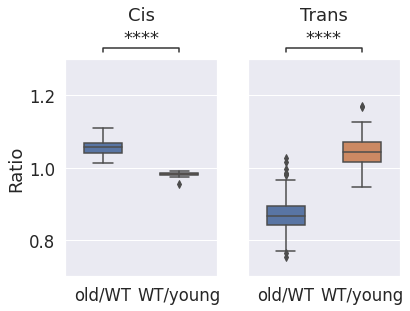

In [689]:
from statannot import add_stat_annotation
sns.set_theme(font_scale=1.5)
tmp_cis = pd.melt(statvals_cis)
tmp_trs = pd.melt(statvals_trs)
x = "variable"
y = "value"
order = ['old/WT', 'WT/young']

fig, axes = plt.subplots(1, 2, figsize=(6,4), sharey=True)

ax1 = sns.boxplot(data=tmp_cis, x=x, y=y, order=order, width=0.5, ax=axes[0])
ax1.set_xlabel('')
ax1.set_ylabel('Ratio')
ax1.set_ylim([0.7, 1.3])
ax1.set_title('Cis', y=1.15)
test_results = add_stat_annotation(ax1, data=tmp_cis, x=x, y=y, order=order,
                                   box_pairs=[('old/WT', 'WT/young'), ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

ax2 = sns.boxplot(data=tmp_trs, x=x, y=y, order=order, width=0.5, ax=axes[1])
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Trans', y=1.15)
test_results = add_stat_annotation(ax2, data=tmp_trs, x=x, y=y, order=order,
                                   box_pairs=[('old/WT', 'WT/young'), ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

plt.savefig('figs/interchromosomal_contact_ratio_boxplots.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

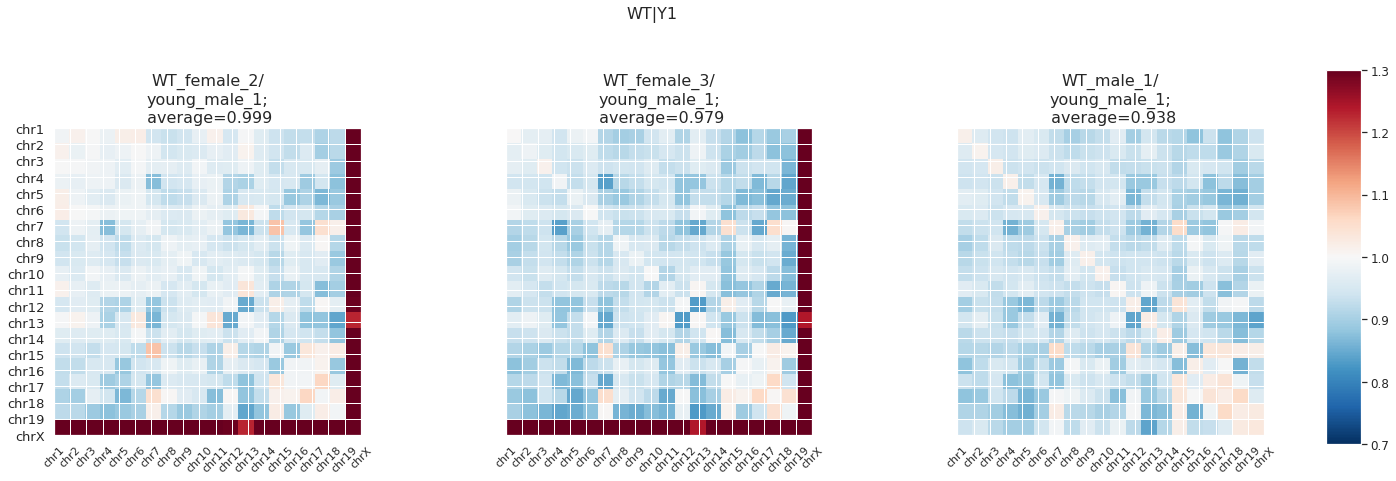

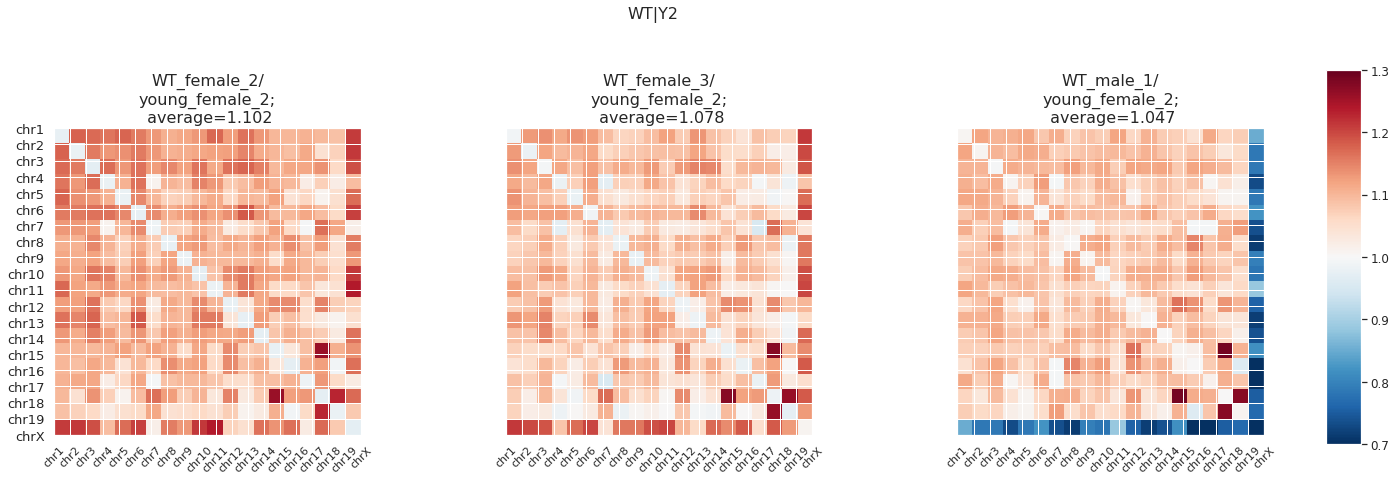

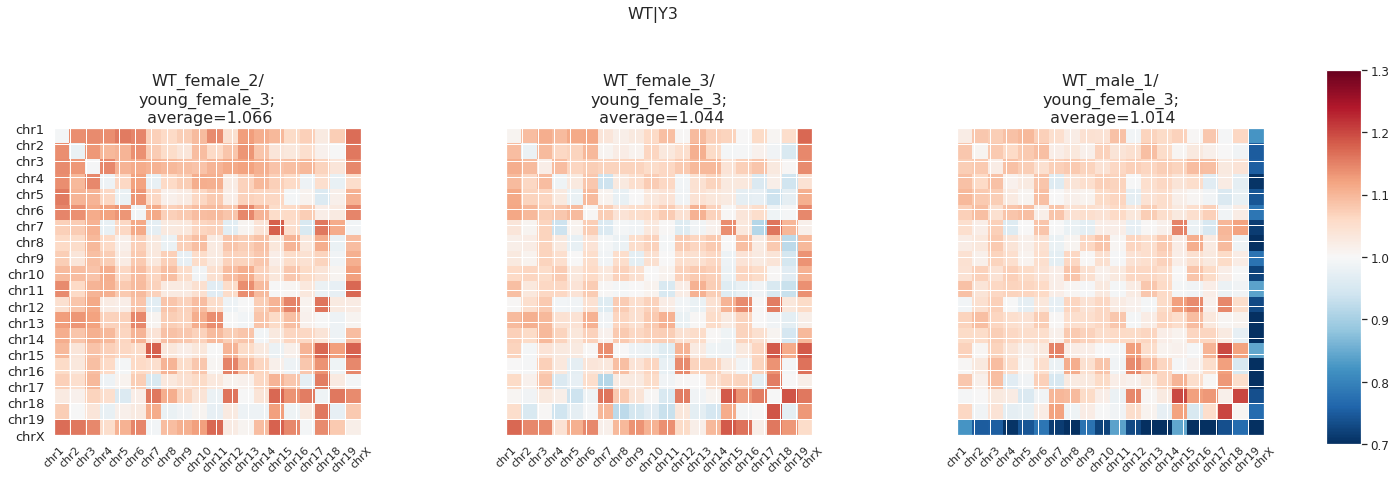

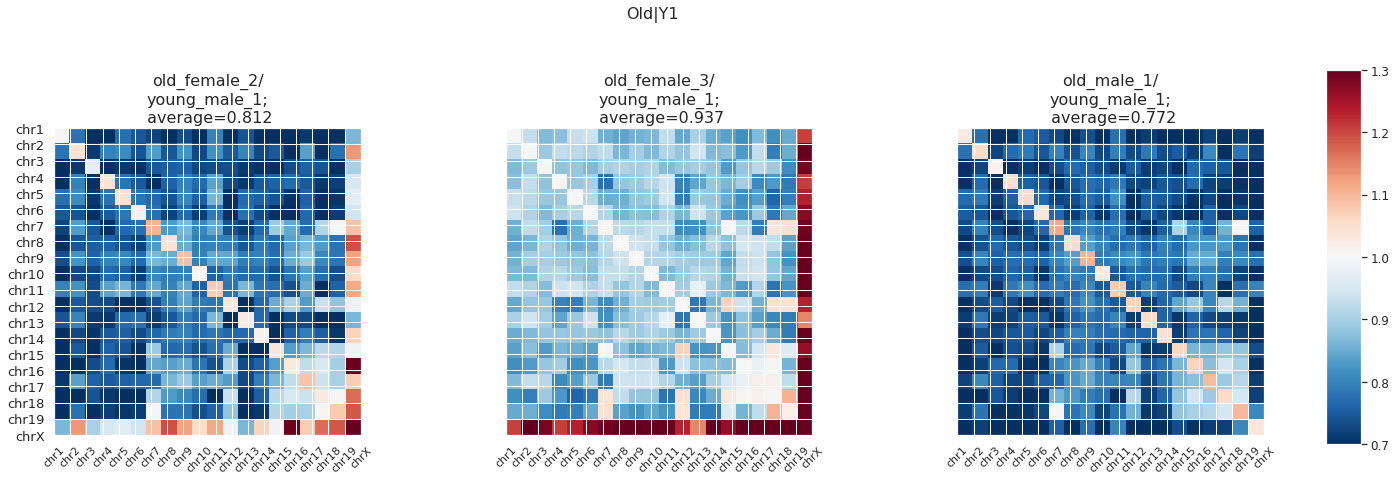

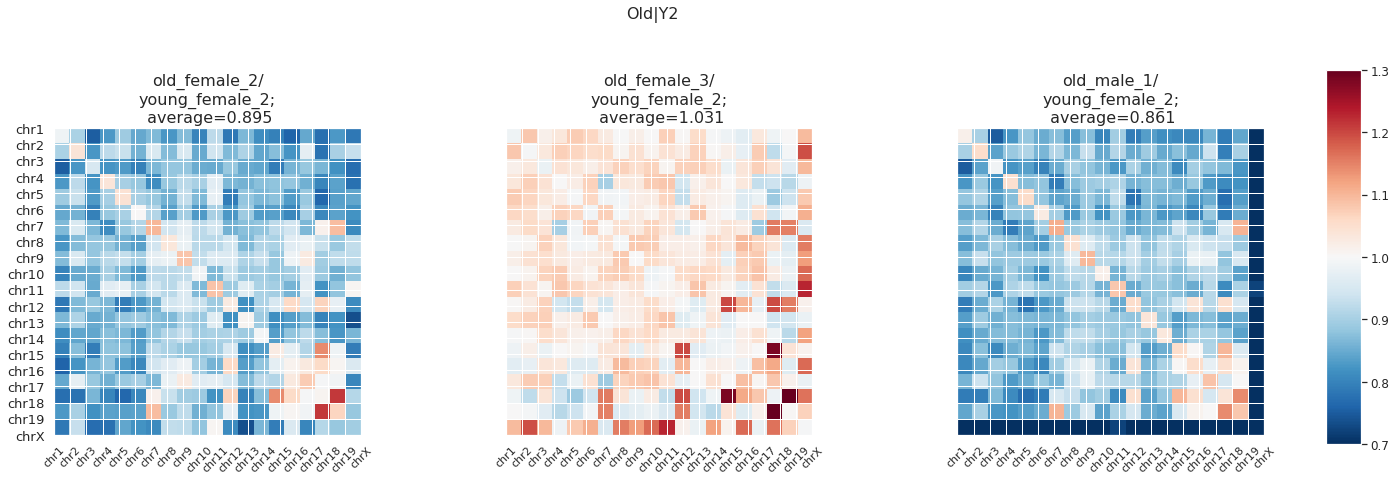

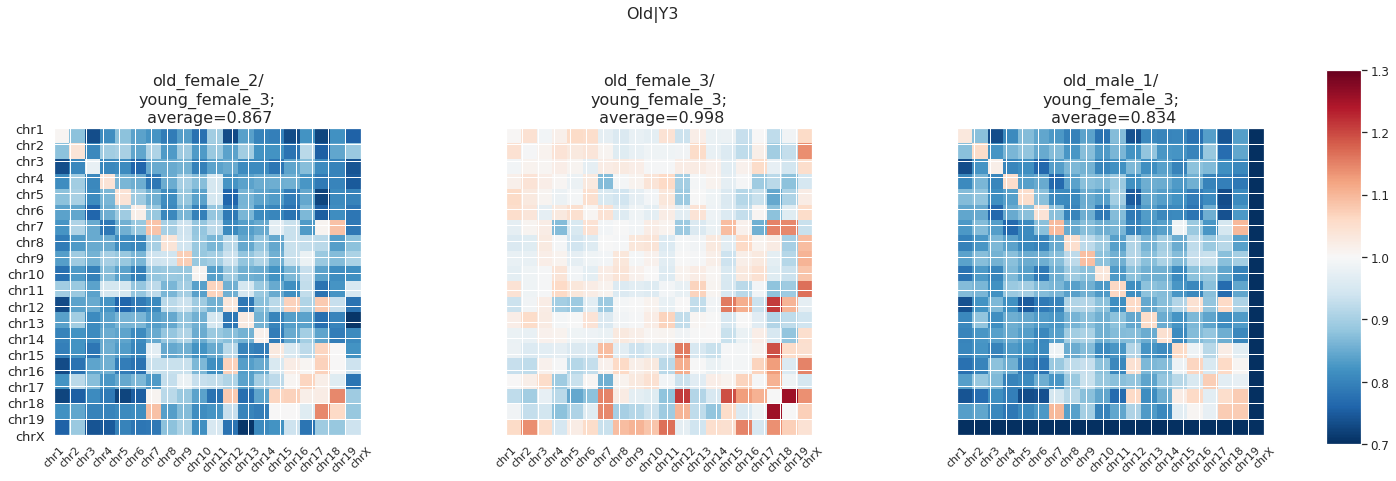

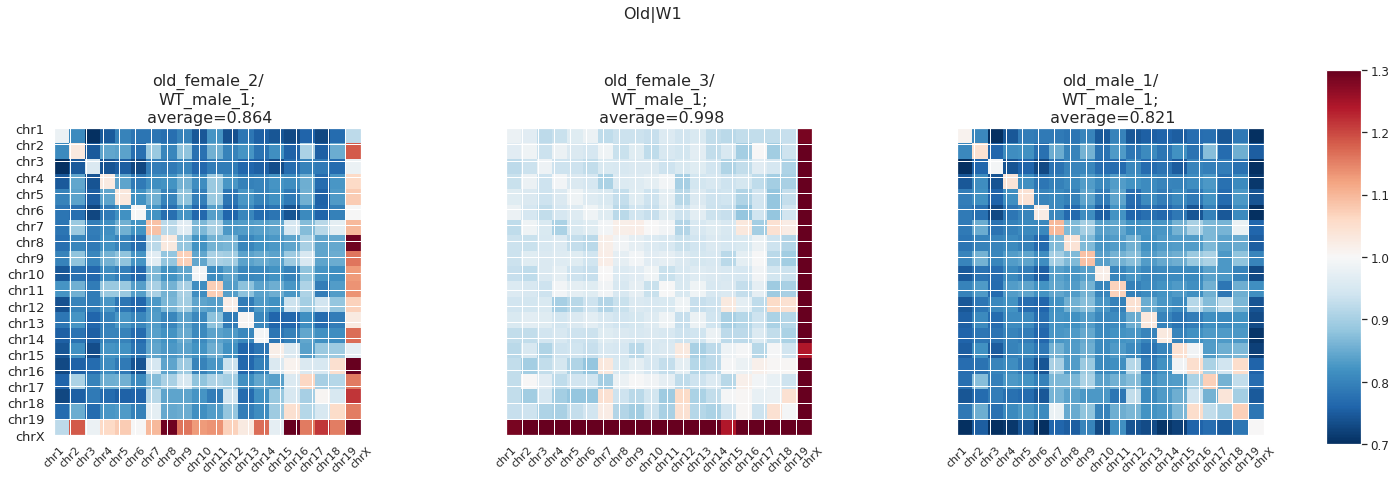

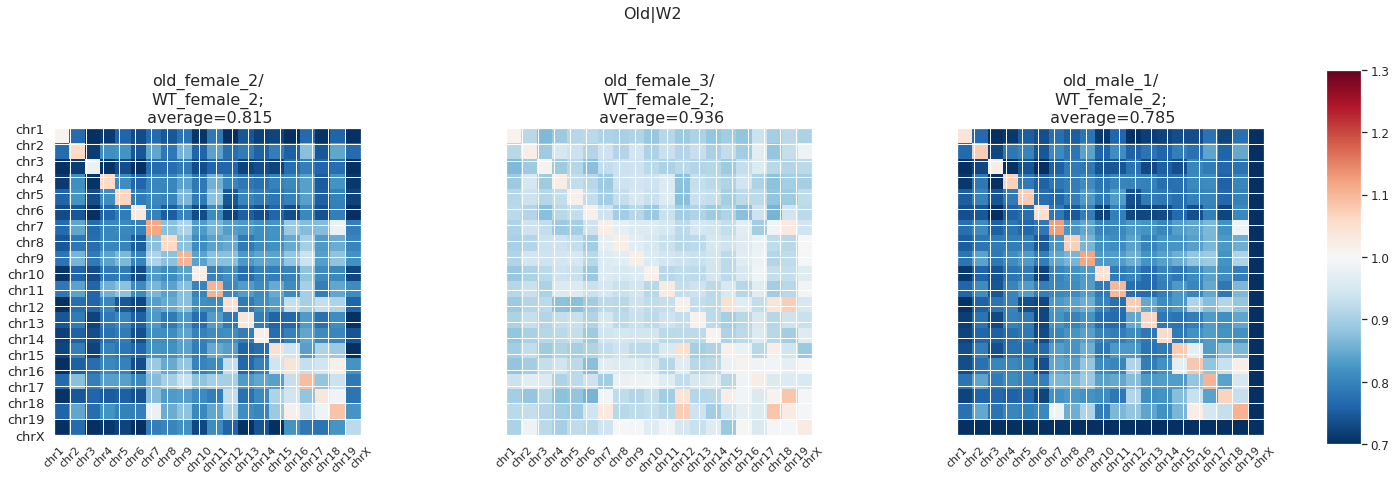

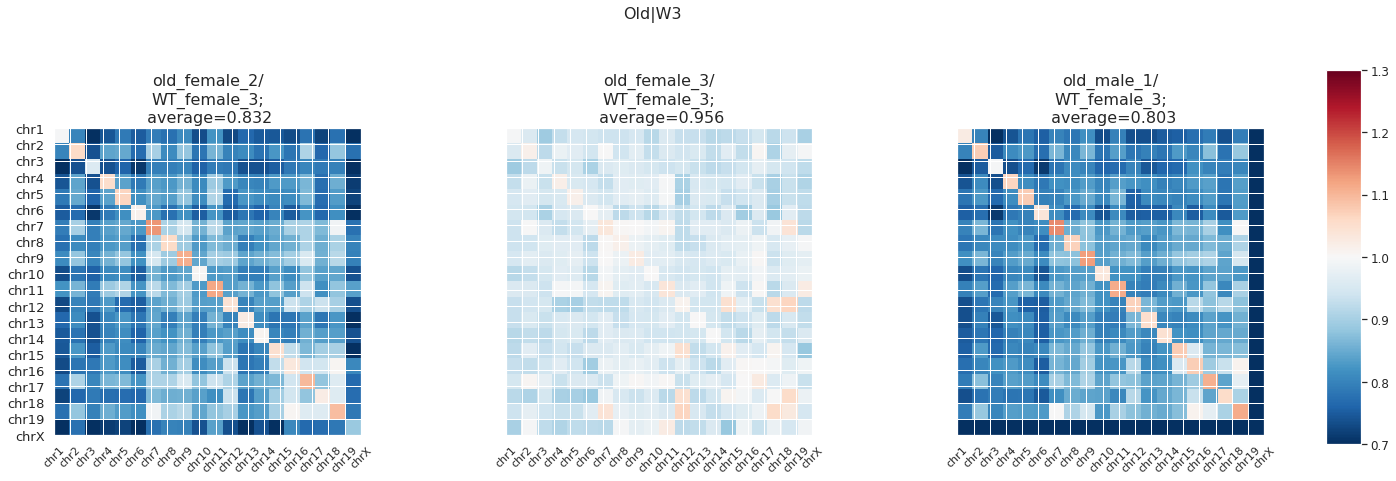

In [171]:
#all replica vs all
titles = ['WT|Y1', 'WT|Y2', 'WT|Y3', 'Old|Y1', 'Old|Y2', 'Old|Y3', 'Old|W1', 'Old|W2', 'Old|W3']
pair_blocks = [
            [['WT_female_2', 'young_male_1'], 
             ['WT_female_3', 'young_male_1'], 
             ['WT_male_1', 'young_male_1']],
            [['WT_female_2', 'young_female_2'], 
             ['WT_female_3', 'young_female_2'], 
             ['WT_male_1', 'young_female_2']],
            [['WT_female_2', 'young_female_3'], 
             ['WT_female_3', 'young_female_3'], 
             ['WT_male_1', 'young_female_3']],
    
            [['old_female_2', 'young_male_1'], 
             ['old_female_3', 'young_male_1'], 
             ['old_male_1', 'young_male_1']],
            [['old_female_2', 'young_female_2'], 
             ['old_female_3', 'young_female_2'], 
             ['old_male_1', 'young_female_2']],
            [['old_female_2', 'young_female_3'], 
             ['old_female_3', 'young_female_3'], 
             ['old_male_1', 'young_female_3']],
    
            [['old_female_2', 'WT_male_1'], 
             ['old_female_3', 'WT_male_1'], 
             ['old_male_1', 'WT_male_1']],
            [['old_female_2', 'WT_female_2'], 
             ['old_female_3', 'WT_female_2'], 
             ['old_male_1', 'WT_female_2']],
            [['old_female_2', 'WT_female_3'], 
             ['old_female_3', 'WT_female_3'], 
             ['old_male_1', 'WT_female_3']],
            ]

import base64
from io import BytesIO
html = ''
for title, pairs in zip(titles, pair_blocks):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True, sharex=True)
    fig.suptitle(title, fontsize=16, y=0.92, x=0.43)
    fig.tight_layout(pad=3)
    for k, ax, pair in zip(interactions.keys(), axes.flatten(), pairs):
        map1 = interactions[pair[0]][:-1, :-1]
        map2 = interactions[pair[1]][:-1, :-1]
        m = map1 / map2
        #np.fill_diagonal(m, np.nan)
        ax.set_title(pair[0] + '/\n' + pair[1] + ';\n average=%.3f' % np.nanmean(m), fontsize=16)
        im = ax.imshow(m, cmap='RdBu_r', vmax=1.3, vmin=0.7, extent=[-1,1,1,-1])
        ax.set_xticks(np.linspace(-1, 1, len(chroms[:-1])),)
        ax.set_yticks(np.linspace(-1, 1, len(chroms[:-1])),)
        ax.set_xticklabels(chroms[:-1], rotation=45, fontsize=11)
        ax.set_yticklabels(chroms[:-1], rotation=0, fontsize=13)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.16, 0.02, 0.65])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    plt.savefig('figs/interchromosomal/interchromosomal_contact_ratio_%s.pdf' % title, 
                dpi=300, bbox_inches='tight', format='pdf')
    
    #save to html
    tmpfile = BytesIO()
    plt.savefig(tmpfile, dpi=150, bbox_inches='tight', format='png') 
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    html = html + '<img src=\'data:image/png;base64,{}\'>'.format(encoded)

with open(f'figs/interchromosomal/interchrom.html', 'w') as f:
    f.write(html)

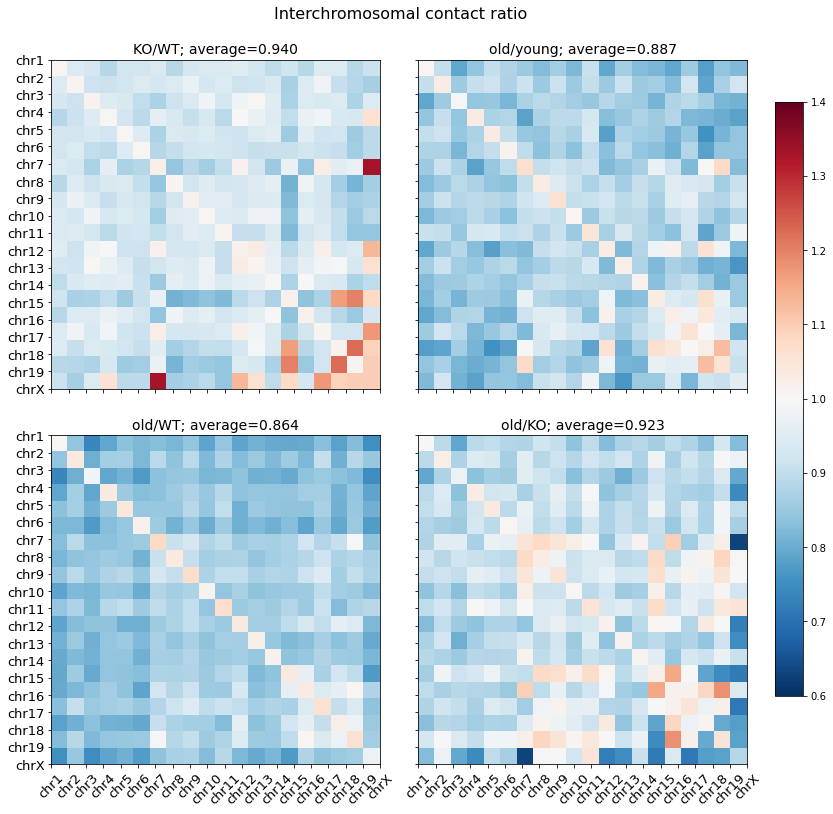

In [79]:
pairs = [('KO', 'WT'), ('old', 'young'), ('old', 'WT'), ('old', 'KO')]
fig, axes = plt.subplots(2, 2, figsize=(13, 11), sharey=True, sharex=True)
fig.suptitle('Interchromosomal contact ratio', fontsize=16, y=1.02, x=0.43)
fig.tight_layout(pad=3)
for k, ax, pair in zip(interactions.keys(), axes.flatten(), pairs):
    map1 = interactions[pair[0]][:-1, :-1]
    map2 = interactions[pair[1]][:-1, :-1]
    m = map1 / map2
    #np.fill_diagonal(m, np.nan)
    ax.set_title(pair[0] + '/' + pair[1] + '; average=%.3f' % np.nanmean(m), fontsize=14)
    im = ax.imshow(m, cmap='RdBu_r', vmax=1.4, vmin=0.6, extent=[-1,1,1,-1])
    ax.set_xticks(np.linspace(-1, 1, len(chroms[:-1])),)
    ax.set_yticks(np.linspace(-1, 1, len(chroms[:-1])),)
    ax.set_xticklabels(chroms[:-1], rotation=45, fontsize=13)
    ax.set_yticklabels(chroms[:-1], rotation=0, fontsize=13)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.03, 0.75])
fig.colorbar(im, cax=cbar_ax)

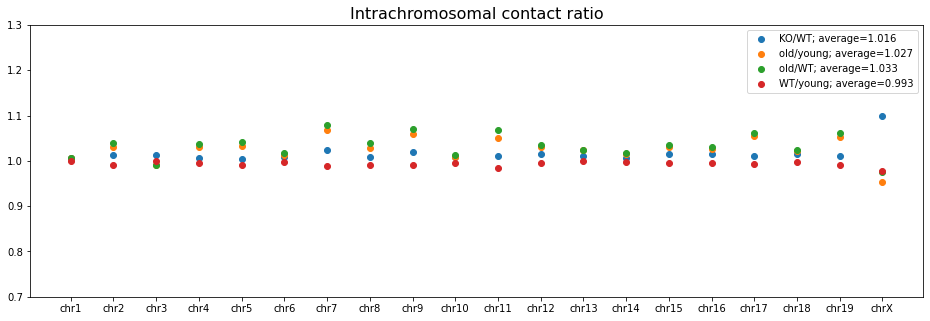

In [157]:
pairs = [('KO', 'WT'), ('old', 'young'), ('old', 'WT'), ('WT', 'young')]

plt.figure(figsize=(16,5))
plt.title('Intrachromosomal contact ratio', fontsize=16)
for k, ax, pair in zip(interactions.keys(), axes.flatten(), pairs):
    map1 = interactions[pair[0]][:-1, :-1].diagonal()
    map2 = interactions[pair[1]][:-1, :-1].diagonal()
    m = map1 / map2
    plt.scatter(chroms[:-1], m, label=pair[0] + '/' + pair[1] + '; average=%.3f' % np.nanmean(m))
plt.legend()
plt.ylim([0.7, 1.3])
plt.show()
    #ax.set_yticklabels(chroms[:-1], rotation=0)


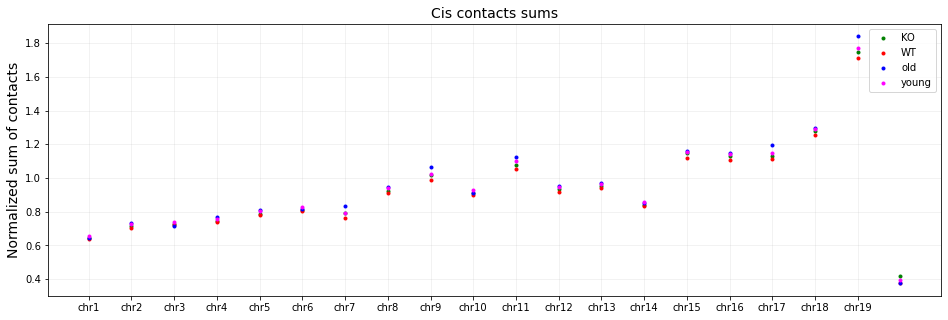

In [147]:
colors = ['green'] + ['red'] + ['blue'] + ['magenta']
#colors = ['red']*2 + ['green']*2

analysis_type = 'c' #c #t #ct

plt.figure(figsize=(16,5))
values = {}
for i, k in enumerate(list(interactions.keys())):
    map = interactions[k][:-1, :-1]
    if analysis_type == 'c':
        f = map.diagonal(0)
        plt.title('Cis contacts sums', fontsize=14)
    elif analysis_type == 't':
        f = (map.sum(1)- map.diagonal(0))
        plt.title('Trans contacts sums', fontsize=14)
    else:
        f = map.diagonal(0) / (map.sum(1) - map.diagonal(0))
        plt.title('Cis-trans ratio', fontsize=14)
    values[k] = f
    plt.plot(f, label=k, lw=0., marker='.', color=colors[i])
    #plt.ylim([0.2, 0.5])
plt.ylabel('Normalized sum of contacts', fontsize=14)
plt.xticks(ticks=range(len(chroms[:-2])), labels=chroms[:-2])
#plt.legend(['Old', 'Old', 'Young', 'Young'])
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Compartments

## eigvecs correlation

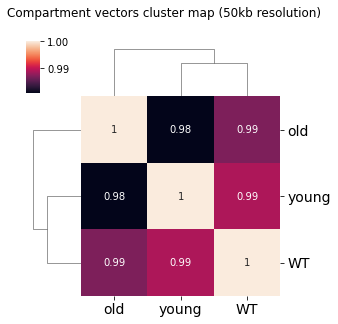

In [224]:
fix_chr = 'all' #'all' or chrom name
fix_row = 'best' #'best' or eigvec name
save = True

chroms = CLRS[0].chromnames
ignore_chroms = ['chrY']
keys = list(eigvec.keys())[1:][::-1]

comp_df = pd.DataFrame()
coo = eigvec[keys[0]][~eigvec[keys[0]].chrom.isin(ignore_chroms)][['chrom', 'start', 'end']]
best_e_df = dict(zip(keys, [[] for _ in range(4)]))
for i, key in enumerate(keys):
    tmp = eigvec[key]
    if fix_chr == 'all':
        comp_vector = []
        for c in chroms:
            if c not in ignore_chroms:
                main_eigvec = 'E' + str(np.argmax(eigval[key].loc[c].filter(regex='eigval*'))+1)
                comp_vector.append(tmp[tmp.chrom==c][main_eigvec].to_numpy())
                best_e_df[key].append(main_eigvec)
        comp_df[key] = np.concatenate(comp_vector)
    elif (fix_chr != 'all') and (fix_row == 'best'):
        main_eigvec = 'E' + str(np.argmax(eigval[key].loc[fix_chr].filter(regex='eigval*'))+1)
        comp_vector = tmp[tmp.chrom==fix_chr][main_eigvec].to_numpy()
        comp_df[key] = comp_vector
    else:        
        comp_df[key] =  tmp[tmp['chrom']==fix_chr][fix_row]

if fix_chr == 'all':
    best_e_df = pd.DataFrame(best_e_df, index=chroms[:-1])#dataframe with best (by eigval) eigenvecs

ax = sns.clustermap(comp_df.corr(), annot=True, figsize=(4,4))
ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = 14)
ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_ymajorticklabels(), fontsize = 14, rotation=0)
ax.fig.suptitle('Compartment vectors cluster map (50kb resolution)', x=0.5, y=1.1)

comp_df_coo = pd.concat([coo, comp_df], axis=1)
if save:
    plt.savefig('./figs/compartments_cluster.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [226]:
#comp_df_coo.to_csv('subdata/compartments_50000_merged_E1.csv')

In [14]:
best_e_df

young old  WT
chr1     E1  E1  E1
chr2     E1  E1  E1
chr3     E1  E1  E1
chr4     E1  E1  E1
chr5     E1  E1  E1
chr6     E1  E1  E1
chr7     E2  E1  E2
chr8     E1  E1  E1
chr9     E1  E1  E1
chr10    E1  E1  E1
chr11    E1  E1  E1
chr12    E1  E1  E1
chr13    E3  E3  E3
chr14    E1  E1  E1
chr15    E1  E1  E1
chr16    E1  E1  E1
chr17    E1  E1  E1
chr18    E1  E1  E1
chr19    E1  E1  E1
chrX     E1  E1  E1

## pentads

In [45]:
from utils.pentads import *

max_zeros = 0.3
min_dimension = 5
distance_cutoff = 0.75
rescale_size = 33
balanced = False
plot = False

subplot_titles = ['Short-range A', 'Short-range B',
                  'Long-range A', 'Long-range B',
                  'Between A and B']
keys = list(eigvec.keys())
AVG_ALL = {}
for chrom in CLRS[0].chromnames[:-1]: #excluding Y chromosome
    print('Start %s' % chrom)
    AVG = {}
    for c, name in zip(CLRS, keys):    
        k = 0 #found compartments counter
        eigenvector = np.nan_to_num(comp_df_coo[comp_df_coo.chrom == chrom][name])
        #print(c, '\n', name, np.nan_to_num(np.asarray(eigenvector)))

        print('Processing cis data...' + name)
        average_compartment = [[], [], [], [], []] #container for average compartments
        areas_stats = [[0], [0], [0], [0], [0]]

        comp_A_index, comp_B_index, zero_bins = get_compartment_bins(eigenvector)
        intervals_A, intervals_B, intervals_zero = get_compartment_intervals(comp_A_index,
                                                                                 comp_B_index,
                                                                                 zero_bins)
        all_intervals = np.sort(intervals_A + intervals_B + intervals_zero)

        matrix = c.matrix(balance=balanced, sparse=True).fetch(chrom).toarray()
        matrix = np.nan_to_num(matrix)
        matrix, *other = numutils.observed_over_expected(matrix)

        for i in tqdm(range(0, len(all_intervals))): # iterate over interval indices
            for j in range(i, len(all_intervals)):
                area = get_area_from_matrix(matrix, all_intervals[i], all_intervals[j])

                if area_dimensions_are_large_enough(area, min_dimension) and\
                    area_has_enough_data(area, max_zeros) and\
                    area_is_close_enough(all_intervals[i], all_intervals[j],
                                         len(matrix), distance_cutoff):

                    area_resized = resize_area(area, rescale_size)
                    area_type = get_area_type(all_intervals[i], all_intervals[j],
                                              intervals_A, intervals_B)

                    k += 1
                    if (i == j):
                        if area_type == 'A':
                            average_compartment[0].append(area_resized)
                        elif area_type == 'B':
                            average_compartment[1].append(area_resized)
                    else:
                        if area_type == 'A':
                            average_compartment[2].append(area_resized)
                        elif area_type == 'B':
                            average_compartment[3].append(area_resized)
                        elif area_type == 'AB':
                            average_compartment[4].append(area_resized)

        for i in range(0, 5):
            areas_stats[i].append(len(average_compartment[i])-np.sum(areas_stats[i]))

        average_compartment = [np.nanmedian(x, axis = 0) for x in average_compartment]
        average_compartment = dict(zip(subplot_titles, average_compartment))
        print('Average compartment in cis calculated! Found %d compartment blocks' % k)
        print()
        AVG[name] = average_compartment
    AVG_ALL[chrom] = AVG
    vmin, vmax = get_comp_quantiles(AVG, 0.01, 0.99)
    print(vmin, vmax)
    if plot:
        plot_pentads_group(AVG, chrom, vmax, vmin, out_pref='figs/pentads/pentads_nonbal_%s' % chrom)

Start chr1
Processing cis data...KO


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/numpy/core/fromnumeric.py:997: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a).copy(order="K")
100%|██████████████████████████████████████████████████| 267/267 [00:00<00:00, 439.02it/s]


Average compartment in cis calculated! Found 257 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 287/287 [00:00<00:00, 425.32it/s]


Average compartment in cis calculated! Found 305 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 275/275 [00:00<00:00, 474.02it/s]


Average compartment in cis calculated! Found 310 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 290/290 [00:00<00:00, 424.01it/s]


Average compartment in cis calculated! Found 288 compartment blocks

0.5781112019938343 1.7718653657406795
Start chr2
Processing cis data...KO


100%|██████████████████████████████████████████████████| 258/258 [00:00<00:00, 395.23it/s]


Average compartment in cis calculated! Found 309 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 249/249 [00:00<00:00, 396.38it/s]


Average compartment in cis calculated! Found 334 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 251/251 [00:00<00:00, 384.20it/s]


Average compartment in cis calculated! Found 343 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 269/269 [00:00<00:00, 391.14it/s]


Average compartment in cis calculated! Found 324 compartment blocks

0.6676046259486244 1.8411081317611335
Start chr3
Processing cis data...KO


100%|██████████████████████████████████████████████████| 327/327 [00:00<00:00, 383.22it/s]


Average compartment in cis calculated! Found 371 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 314/314 [00:00<00:00, 379.56it/s]


Average compartment in cis calculated! Found 427 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 354/354 [00:00<00:00, 356.06it/s]


Average compartment in cis calculated! Found 491 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 367/367 [00:01<00:00, 354.66it/s]


Average compartment in cis calculated! Found 458 compartment blocks

0.6649713763461597 1.8332111807144584
Start chr4
Processing cis data...KO


100%|██████████████████████████████████████████████████| 152/152 [00:00<00:00, 600.79it/s]


Average compartment in cis calculated! Found 109 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 162/162 [00:00<00:00, 611.77it/s]


Average compartment in cis calculated! Found 154 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 158/158 [00:00<00:00, 537.15it/s]


Average compartment in cis calculated! Found 133 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 152/152 [00:00<00:00, 472.39it/s]


Average compartment in cis calculated! Found 117 compartment blocks

0.3116371042319825 2.5660585759741306
Start chr5
Processing cis data...KO


100%|██████████████████████████████████████████████████| 111/111 [00:00<00:00, 586.86it/s]


Average compartment in cis calculated! Found 103 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 128/128 [00:00<00:00, 640.12it/s]


Average compartment in cis calculated! Found 128 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 134/134 [00:00<00:00, 629.36it/s]


Average compartment in cis calculated! Found 134 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 132/132 [00:00<00:00, 708.53it/s]


Average compartment in cis calculated! Found 122 compartment blocks

0.5970662896663913 1.89636977627691
Start chr6
Processing cis data...KO


100%|██████████████████████████████████████████████████| 229/229 [00:00<00:00, 450.47it/s]


Average compartment in cis calculated! Found 189 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 184/184 [00:00<00:00, 542.46it/s]


Average compartment in cis calculated! Found 201 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 201/201 [00:00<00:00, 537.95it/s]


Average compartment in cis calculated! Found 229 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 205/205 [00:00<00:00, 552.41it/s]


Average compartment in cis calculated! Found 195 compartment blocks

0.6103064770447048 1.977608956938249
Start chr7
Processing cis data...KO


100%|██████████████████████████████████████████████████| 225/225 [00:00<00:00, 544.30it/s]


Average compartment in cis calculated! Found 263 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 244/244 [00:00<00:00, 506.12it/s]


Average compartment in cis calculated! Found 268 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 252/252 [00:00<00:00, 501.40it/s]


Average compartment in cis calculated! Found 319 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 237/237 [00:00<00:00, 551.08it/s]


Average compartment in cis calculated! Found 238 compartment blocks

0.45365493547608576 4.75295322017533
Start chr8
Processing cis data...KO


100%|██████████████████████████████████████████████████| 187/187 [00:00<00:00, 530.18it/s]


Average compartment in cis calculated! Found 168 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 173/173 [00:00<00:00, 676.83it/s]


Average compartment in cis calculated! Found 174 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 192/192 [00:00<00:00, 645.26it/s]


Average compartment in cis calculated! Found 203 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 177/177 [00:00<00:00, 617.27it/s]


Average compartment in cis calculated! Found 197 compartment blocks

0.5559426033929031 2.486672581010265
Start chr9
Processing cis data...KO


100%|██████████████████████████████████████████████████| 121/121 [00:00<00:00, 697.56it/s]


Average compartment in cis calculated! Found 147 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 107/107 [00:00<00:00, 722.38it/s]


Average compartment in cis calculated! Found 114 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 109/109 [00:00<00:00, 686.45it/s]


Average compartment in cis calculated! Found 132 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 103/103 [00:00<00:00, 707.65it/s]


Average compartment in cis calculated! Found 104 compartment blocks

0.4731016451494494 2.2899484468340874
Start chr10
Processing cis data...KO


100%|██████████████████████████████████████████████████| 201/201 [00:00<00:00, 588.66it/s]


Average compartment in cis calculated! Found 231 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 201/201 [00:00<00:00, 527.52it/s]


Average compartment in cis calculated! Found 222 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 197/197 [00:00<00:00, 584.47it/s]


Average compartment in cis calculated! Found 222 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 211/211 [00:00<00:00, 552.39it/s]


Average compartment in cis calculated! Found 235 compartment blocks

0.6380472379769845 1.8904873599165106
Start chr11
Processing cis data...KO


100%|██████████████████████████████████████████████████| 123/123 [00:00<00:00, 599.15it/s]


Average compartment in cis calculated! Found 125 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 117/117 [00:00<00:00, 606.15it/s]


Average compartment in cis calculated! Found 122 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 119/119 [00:00<00:00, 573.10it/s]


Average compartment in cis calculated! Found 126 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 113/113 [00:00<00:00, 568.26it/s]


Average compartment in cis calculated! Found 104 compartment blocks

0.43112343715756807 2.193695100771519
Start chr12
Processing cis data...KO


100%|██████████████████████████████████████████████████| 199/199 [00:00<00:00, 504.04it/s]


Average compartment in cis calculated! Found 250 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 208/208 [00:00<00:00, 501.12it/s]


Average compartment in cis calculated! Found 216 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 186/186 [00:00<00:00, 509.45it/s]


Average compartment in cis calculated! Found 253 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 207/207 [00:00<00:00, 501.18it/s]


Average compartment in cis calculated! Found 228 compartment blocks

0.633926933148751 2.6232538752327645
Start chr13
Processing cis data...KO


100%|██████████████████████████████████████████████████| 203/203 [00:00<00:00, 529.92it/s]


Average compartment in cis calculated! Found 117 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 157/157 [00:00<00:00, 554.77it/s]


Average compartment in cis calculated! Found 125 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 151/151 [00:00<00:00, 585.22it/s]


Average compartment in cis calculated! Found 139 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 180/180 [00:00<00:00, 544.57it/s]


Average compartment in cis calculated! Found 177 compartment blocks

0.40711096716304157 5.366960626891551
Start chr14
Processing cis data...KO


100%|██████████████████████████████████████████████████| 189/189 [00:00<00:00, 494.35it/s]


Average compartment in cis calculated! Found 212 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 181/181 [00:00<00:00, 507.60it/s]


Average compartment in cis calculated! Found 199 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 173/173 [00:00<00:00, 498.26it/s]


Average compartment in cis calculated! Found 242 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 180/180 [00:00<00:00, 542.86it/s]


Average compartment in cis calculated! Found 202 compartment blocks

0.5068429365191617 1.9282046642225619
Start chr15
Processing cis data...KO


100%|██████████████████████████████████████████████████| 157/157 [00:00<00:00, 572.45it/s]


Average compartment in cis calculated! Found 196 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 146/146 [00:00<00:00, 588.66it/s]


Average compartment in cis calculated! Found 171 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 155/155 [00:00<00:00, 591.03it/s]


Average compartment in cis calculated! Found 185 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 143/143 [00:00<00:00, 600.60it/s]


Average compartment in cis calculated! Found 182 compartment blocks

0.4971517303760251 1.92185053482253
Start chr16
Processing cis data...KO


100%|██████████████████████████████████████████████████| 119/119 [00:00<00:00, 716.77it/s]


Average compartment in cis calculated! Found 80 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 105/105 [00:00<00:00, 706.38it/s]


Average compartment in cis calculated! Found 94 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 105/105 [00:00<00:00, 700.65it/s]


Average compartment in cis calculated! Found 82 compartment blocks

Processing cis data...young


100%|████████████████████████████████████████████████████| 99/99 [00:00<00:00, 745.08it/s]


Average compartment in cis calculated! Found 72 compartment blocks

0.45489748285167375 4.981566362984752
Start chr17
Processing cis data...KO


100%|██████████████████████████████████████████████████| 129/129 [00:00<00:00, 706.60it/s]


Average compartment in cis calculated! Found 117 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 136/136 [00:00<00:00, 692.91it/s]


Average compartment in cis calculated! Found 129 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 155/155 [00:00<00:00, 656.01it/s]


Average compartment in cis calculated! Found 146 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 134/134 [00:00<00:00, 708.11it/s]


Average compartment in cis calculated! Found 100 compartment blocks

0.34255048208113514 2.3038338636249973
Start chr18
Processing cis data...KO


100%|██████████████████████████████████████████████████| 237/237 [00:00<00:00, 508.24it/s]


Average compartment in cis calculated! Found 317 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 216/216 [00:00<00:00, 532.39it/s]


Average compartment in cis calculated! Found 320 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 205/205 [00:00<00:00, 531.84it/s]


Average compartment in cis calculated! Found 370 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 245/245 [00:00<00:00, 504.34it/s]


Average compartment in cis calculated! Found 286 compartment blocks

0.6579292737235878 1.748355549809148
Start chr19
Processing cis data...KO


100%|████████████████████████████████████████████████████| 93/93 [00:00<00:00, 879.50it/s]

Average compartment in cis calculated! Found 114 compartment blocks

Processing cis data...WT



100%|██████████████████████████████████████████████████| 107/107 [00:00<00:00, 872.69it/s]


Average compartment in cis calculated! Found 109 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 117/117 [00:00<00:00, 788.73it/s]


Average compartment in cis calculated! Found 151 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 105/105 [00:00<00:00, 855.27it/s]


Average compartment in cis calculated! Found 119 compartment blocks

0.6115964433303126 2.8889940640500145
Start chrX
Processing cis data...KO


100%|██████████████████████████████████████████████████| 279/279 [00:00<00:00, 484.75it/s]


Average compartment in cis calculated! Found 197 compartment blocks

Processing cis data...WT


100%|██████████████████████████████████████████████████| 255/255 [00:00<00:00, 482.26it/s]


Average compartment in cis calculated! Found 205 compartment blocks

Processing cis data...old


100%|██████████████████████████████████████████████████| 305/305 [00:00<00:00, 475.19it/s]


Average compartment in cis calculated! Found 170 compartment blocks

Processing cis data...young


100%|██████████████████████████████████████████████████| 210/210 [00:00<00:00, 589.71it/s]

Average compartment in cis calculated! Found 139 compartment blocks

0.5829809283671707 2.2387976663980824


In [96]:
#all chromosomes
chroms = CLRS[0].chromnames[:-1]
pairs = pairs = [['old', 'young'], ['old', 'WT'], ['WT', 'young'], ['KO', 'young'], ['KO', 'WT'], ['KO', 'old']]
AVG_pairs = {}
for pair in pairs:
    pairname = pair[0] + '/' + pair[1]
    AVG_pairs[pairname] = {}
    for sub in subplot_titles:
        x = []
        y = []
        for chrom in chroms:
            #x += AVG_ALL[chrom][pair[0]][sub]
            #y += AVG_ALL[chrom][pair[1]][sub]
            x.append(AVG_ALL[chrom][pair[0]][sub])
            y.append(AVG_ALL[chrom][pair[1]][sub])
        AVG_pairs[pairname][sub] = np.nanmedian(x, axis=0) / np.nanmedian(y, axis=0)
        
print(get_comp_quantiles(AVG_pairs, 0.01, 0.99))

(0.7313371885034002, 1.266992226027499)


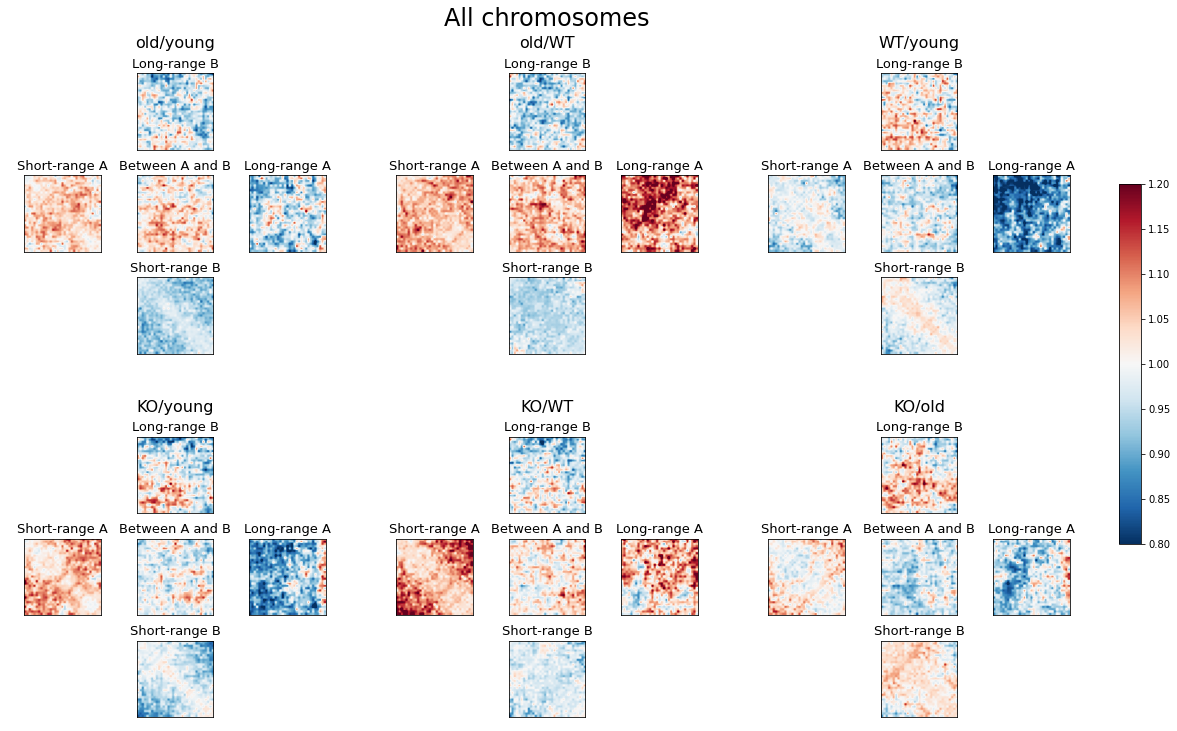

In [100]:
import matplotlib as mpl
subplot_titles = ['Short-range A', 'Short-range B',
                  'Long-range A', 'Long-range B',
                  'Between A and B']
subplot_indexes = [3, 7, 5, 1, 4]
vmin = 0.8
vmax = 1.2

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
fig.suptitle('All chromosomes', fontsize=24)

subfigs = fig.subfigures(2, 3, wspace=0.1, hspace=0.1)
for (name, average_compartment), subfig in zip(AVG_pairs.items(), subfigs.flat):
    title = name #subfigure title
    subfig.suptitle(title, fontsize=16)
    axs = subfig.subplots(3, 3).flatten()
    for subtitle, index in zip(subplot_titles, subplot_indexes):
        axs[index].set_title(subtitle, fontsize = 13)
        im = axs[index].imshow(average_compartment[subtitle], cmap = 'RdBu_r', vmin=vmin, vmax=vmax)
        axs[index].set_xticks([])
        axs[index].set_yticks([])
    for index in range(9): #erase 
        if index not in subplot_indexes:
            axs[index].set_visible(False)

cbar_ax = fig.add_axes([1.03, 0.25, 0.02, 0.5])
fig.colorbar(im, cax = cbar_ax)
plt.savefig(f'./figs/pentads_all.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Saddle plots

In [81]:
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=1)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

#construct scalings
scalings_data = {}
for cond, clr in zip(LBLS, CLRS):
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms[mm10_arms.chrom != 'chrY'], chunksize=1000000, nproc=18)
    scalings_data[cond] = expected

In [61]:
import warnings
from cytoolz import merge

def saddleplot(
    track,
    saddledata,
    n_bins,
    vrange=None,
    qrange=(0.0, 1.0),
    cmap="coolwarm",
    scale="log",
    vmin=0.5,
    vmax=2,
    color=None,
    title=None,
    xlabel=None,
    ylabel=None,
    clabel=None,
    fig=None,
    fig_kws=None,
    heatmap_kws=None,
    margin_kws=None,
    cbar_kws=None,
    subplot_spec=None,
):
    """
    Generate a saddle plot.
    Parameters
    ----------
    track : pd.DataFrame
        See cooltools.digitize() for details.
    saddledata : 2D array-like
        Saddle matrix produced by `make_saddle`. It will include 2 flanking
        rows/columns for outlier signal values, thus the shape should be
        `(n+2, n+2)`.
    cmap : str or matplotlib colormap
        Colormap to use for plotting the saddle heatmap
    scale : str
        Color scaling to use for plotting the saddle heatmap: log or linear
    vmin, vmax : float
        Value limits for coloring the saddle heatmap
    color : matplotlib color value
        Face color for margin bar plots
    fig : matplotlib Figure, optional
        Specified figure to plot on. A new figure is created if none is
        provided.
    fig_kws : dict, optional
        Passed on to `plt.Figure()`
    heatmap_kws : dict, optional
        Passed on to `ax.imshow()`
    margin_kws : dict, optional
        Passed on to `ax.bar()` and `ax.barh()`
    cbar_kws : dict, optional
        Passed on to `plt.colorbar()`
    subplot_spec : GridSpec object
        Specify a subregion of a figure to using a GridSpec.
    Returns
    -------
    Dictionary of axes objects.
    """

#     warnings.warn(
#         "Generating a saddleplot will be deprecated in future versions, "
#         + "please see https://github.com/open2c_examples for examples on how to plot saddles.",
#         DeprecationWarning,
#     )

    from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
    from matplotlib.colors import Normalize, LogNorm
    from matplotlib import ticker
    import matplotlib.pyplot as plt

    class MinOneMaxFormatter(ticker.LogFormatter):
        def set_locs(self, locs=None):
            self._sublabels = set([vmin % 10 * 10, vmax % 10, 1])

        def __call__(self, x, pos=None):
            if x not in [vmin, 1, vmax]:
                return ""
            else:
                return "{x:g}".format(x=x)

    track_value_col = track.columns[3]
    track_values = track[track_value_col].values

    digitized_track, binedges = cooltools.digitize(
        track, n_bins, vrange=vrange, qrange=qrange
    )
    x = digitized_track[digitized_track.columns[3]].values.astype(int).copy()
    x = x[(x > -1) & (x < len(binedges) + 1)]

    # Old version
    # hist = np.bincount(x, minlength=len(binedges) + 1)

    groupmean = track[track.columns[3]].groupby(digitized_track[digitized_track.columns[3]]).mean()

    if qrange is not None:
        lo, hi = qrange
        binedges = np.linspace(lo, hi, n_bins + 1)

    # Barplot of mean values and saddledata are flanked by outlier bins
    n = saddledata.shape[0]
    X, Y = np.meshgrid(binedges, binedges)
    C = saddledata
    if (n - n_bins) == 2:
        C = C[1:-1, 1:-1]
        groupmean = groupmean[1:-1]

    # Layout
    if subplot_spec is not None:
        GridSpec = partial(GridSpecFromSubplotSpec, subplot_spec=subplot_spec)
    grid = {}
    gs = GridSpec(
        nrows=3,
        ncols=3,
        width_ratios=[0.2, 1, 0.1],
        height_ratios=[0.2, 1, 0.1],
        wspace=0.05,
        hspace=0.05,
    )

    # Figure
    if fig is None:
        fig_kws_default = dict(figsize=(5, 5))
        fig_kws = merge(fig_kws_default, fig_kws if fig_kws is not None else {})
        fig = plt.figure(**fig_kws)

    # Heatmap
    if scale == "log":
        norm = LogNorm(vmin=vmin, vmax=vmax)
    elif scale == "linear":
        norm = Normalize(vmin=vmin, vmax=vmax)
    else:
        raise ValueError("Only linear and log color scaling is supported")

    grid["ax_heatmap"] = ax = plt.subplot(gs[4])
    heatmap_kws_default = dict(cmap="coolwarm", rasterized=True)
    heatmap_kws = merge(
        heatmap_kws_default, heatmap_kws if heatmap_kws is not None else {}
    )
    img = ax.pcolormesh(X, Y, C, norm=norm, **heatmap_kws)
    plt.gca().yaxis.set_visible(False)

    # Margins
    margin_kws_default = dict(edgecolor="k", facecolor=color, linewidth=1)
    margin_kws = merge(margin_kws_default, margin_kws if margin_kws is not None else {})
    # left margin hist
    grid["ax_margin_y"] = plt.subplot(gs[3], sharey=grid["ax_heatmap"])

    plt.barh(
        binedges, height=1/len(binedges), width=groupmean, align="edge", **margin_kws
    )

    plt.xlim(plt.xlim()[1], plt.xlim()[0])  # fliplr
    plt.ylim(hi, lo)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["bottom"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    # top margin hist
    grid["ax_margin_x"] = plt.subplot(gs[1], sharex=grid["ax_heatmap"])

    plt.bar(
        binedges, width=1/len(binedges), height=groupmean, align="edge", **margin_kws
    )

    plt.xlim(lo, hi)
    # plt.ylim(plt.ylim())  # correct
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().xaxis.set_visible(False)
    plt.gca().yaxis.set_visible(False)

    # Colorbar
    grid["ax_cbar"] = plt.subplot(gs[5])
    cbar_kws_default = dict(fraction=0.8, label=clabel or "")
    cbar_kws = merge(cbar_kws_default, cbar_kws if cbar_kws is not None else {})
    if scale == "linear" and vmin is not None and vmax is not None:
        grid["cbar"] = cb = plt.colorbar(img, **cbar_kws)
        # cb.set_ticks(np.arange(vmin, vmax + 0.001, 0.5))
        # # do linspace between vmin and vmax of 5 segments and trunc to 1 decimal:
        decimal = 10
        nsegments = 5
        cd_ticks = np.trunc(np.linspace(vmin, vmax, nsegments) * decimal) / decimal
        cb.set_ticks(cd_ticks)
    else:
        grid["cbar"] = cb = plt.colorbar(img, format=MinOneMaxFormatter(), **cbar_kws)
        cb.ax.yaxis.set_minor_formatter(MinOneMaxFormatter())

    # extra settings
    grid["ax_heatmap"].set_xlim(lo, hi)
    grid["ax_heatmap"].set_ylim(hi, lo)
    plt.grid(False)
    plt.axis("off")
    if title is not None:
        grid["ax_margin_x"].set_title(title)
    if xlabel is not None:
        grid["ax_heatmap"].set_xlabel(xlabel)
    if ylabel is not None:
        grid["ax_margin_y"].set_ylabel(ylabel)

    return grid

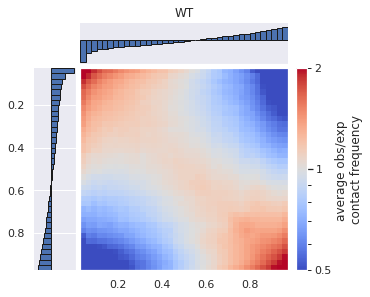

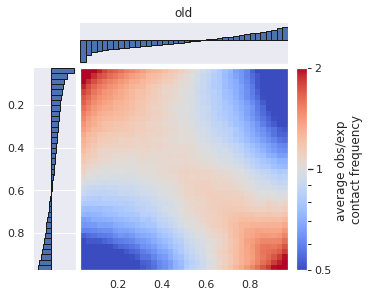

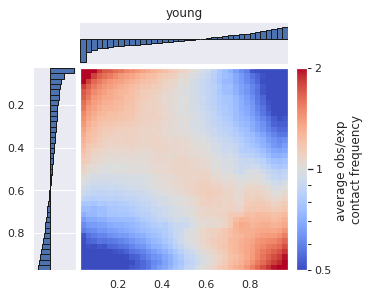

In [86]:
Q_LO = 0.025 # ignore 2.5% of genomic bins with the lowest E1 values
Q_HI = 0.975 # ignore 2.5% of genomic bins with the highest E1 values
N_GROUPS = 38 # divide remaining 95% of the genome into 38 equisized groups, 2.5% each

saddle_matrices = {}
for clr, lbl in zip(CLRS[1:], LBLS[1:]):
    cvd = scalings_data[lbl]
    eigenvector_track = comp_df_coo[['chrom','start','end', lbl]]
    interaction_sum, interaction_count = cooltools.saddle(
                                        clr,
                                        cvd,
                                        eigenvector_track,
                                        'cis',
                                        n_bins=N_GROUPS,
                                        qrange=(Q_LO,Q_HI),
                                        view_df=mm10_arms[mm10_arms.chrom != 'chrY']
                                        )
    saddle_matrices[lbl] = interaction_sum / interaction_count
    saddleplot(eigenvector_track,
           interaction_sum/interaction_count,
           N_GROUPS,
           qrange=(Q_LO, Q_HI),
           title=lbl,
           cbar_kws={'label':'average obs/exp \ncontact frequency'}
          );
    
    plt.savefig(f'figs/saddle_{lbl}.pdf', dpi=300, bbox_inches='tight', format='pdf')
    plt.show()

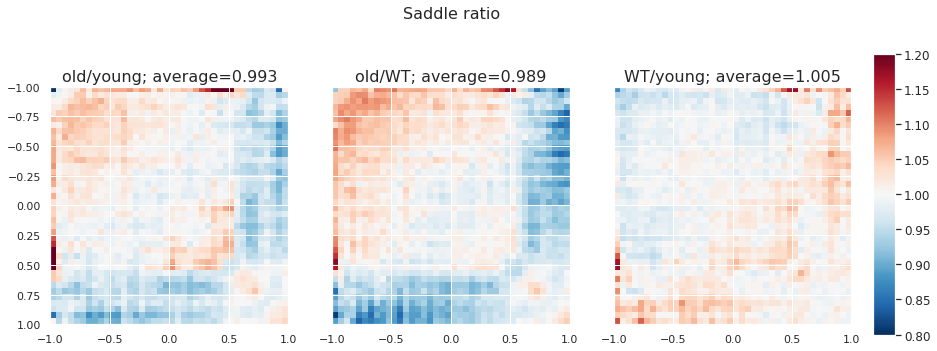

In [96]:
pairs = [['old', 'young'], ['old', 'WT'], ['WT', 'young']]

fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True, sharex=True)
fig.suptitle('Saddle ratio', fontsize=16, y=0.92, x=0.43)
fig.tight_layout(pad=3)
for ax, pair in zip(axes.flatten(), pairs):
    ratio = saddle_matrices[pair[0]] / saddle_matrices[pair[1]]
    ax.set_title(pair[0] + '/' + pair[1] + '; average=%.3f' % np.nanmean(ratio), fontsize=16)
    im = ax.imshow(ratio, cmap='RdBu_r', vmax=1.2, vmin=0.8, extent=[-1,1,1,-1])

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.16, 0.02, 0.65])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.ax.tick_params(labelsize=12)
plt.savefig('figs/saddle_ratio.pdf', dpi=300, bbox_inches='tight', format='pdf')

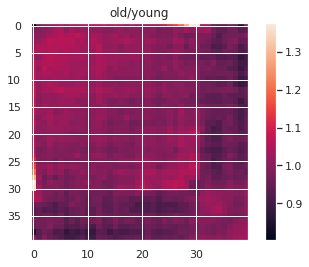

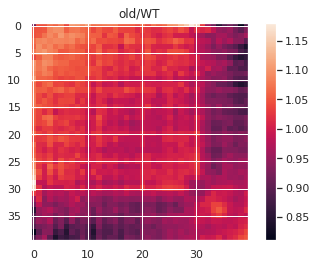

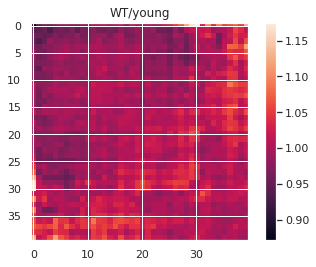

In [92]:

for pair in pairs:

    plt.imshow(ratio)
    plt.title(pair[0] + '/' + pair[1])
    plt.colorbar()    
    plt.show()


## LADs enrrichment

In [15]:
df_lad = pd.read_csv('./subdata/GSE17051_cLAD_mm10.bed', 
                     sep='\t', 
                     header=None).drop([3,4,5], axis=1)
df_lad.columns = ['Chromosome','Start','End']
df_lad['length'] = df_lad['End'] - df_lad['Start']
df_lad['log_length'] = np.log10(df_lad['length'])

df_lad_filt = df_lad[df_lad.length > 10_000] #filter those LAD domains which occupy more than 10kb 
lad_df = df_lad_filt[['Chromosome','Start','End']].copy()

In [16]:
#merge intervals
lad_pr = pr.PyRanges(lad_df)
bin_pr = comp_df_coo[['chrom', 'start', 'end']]
bin_pr.columns = ['Chromosome', 'Start', 'End']
bin_pr = pr.PyRanges(bin_pr)
result = bin_pr.join(lad_pr)
result = result.df

#bins in lads
#return compartments and DROP DUPLICATES !!!!
ldf = result.merge(comp_df_coo, left_on=['Chromosome','Start', 'End'], right_on=['chrom','start', 'end']).\
        drop(['chrom', 'start', 'end'], 1).drop_duplicates(subset=['Chromosome', 'Start', 'End'])

#bins not in LADs
nldf = comp_df_coo[comp_df_coo.merge(ldf, how='left', 
               left_on=['chrom', 'start', 'end'], 
               right_on=['Chromosome', 'Start', 'End'])['Chromosome'].isna().tolist()].dropna(0)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


In [20]:
from scipy.stats import chi2_contingency

factor = 'old'
cases = ['young', 'WT', 'old']

for factor in cases:
    A_LAD = (ldf[factor] > 0).sum()
    B_LAD = (ldf[factor] < 0).sum()
    A_nLAD = (nldf[factor] > 0).sum()
    B_nLAD = (nldf[factor] < 0).sum()

    cross_matrix = np.array([[A_LAD, A_nLAD], 
                             [B_LAD, B_nLAD]])

    chi, p, _, _ = chi2_contingency(cross_matrix)

    print('%s case: chi2 statistics = %.3f; p-value = %.5f' % (factor, chi, p))

young case: chi2 statistics = 13467.626; p-value = 0.00000
WT case: chi2 statistics = 14543.534; p-value = 0.00000
old case: chi2 statistics = 13532.611; p-value = 0.00000


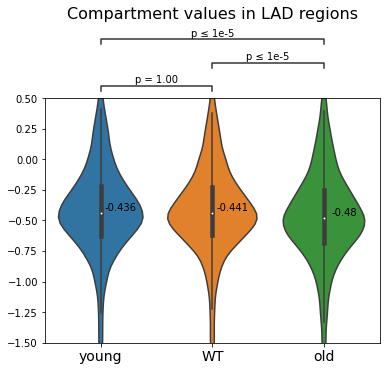

In [30]:
import warnings
warnings.filterwarnings('ignore')
from statannot import add_stat_annotation

labels = ['young', 'WT', 'old']
lad_oy = ldf[labels].dropna(0)
df = lad_oy.copy()

fig = plt.figure(figsize=(6,4.5))
fig.tight_layout(pad=5)
ax = sns.violinplot(data=df)
ax.set_title('Compartment values in LAD regions', loc="center", fontsize=16, y=1.3)
ax.set_xticklabels(labels, fontsize=14)
ax.set_ylim([-1.5,0.5])
test_results = add_stat_annotation(ax, data=df, 
                                   box_pairs=[ ("WT", "young"),
                                               ("old", "young"), 
                                               ("old", "WT"),
                                             ],
                                   test='Mann-Whitney', text_format='simple',
                                   loc='outside', verbose=0)
for i, c in enumerate(df.columns):
    ax.annotate(round(df[c].median(), 3), (i + 0.18, df[c].median() + 0.02), ha='center')

plt.savefig('./figs/lad_compartments_violin.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

# Insulation score analysis

In [332]:
from scipy.signal import argrelextrema
import scipy.optimize as optimization

explore = ['WT', 'young', 'old']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
X = X.dropna(axis=1)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


## ANOVA analysis

In [556]:
explore = ['WT', 'young', 'old']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
X = X.dropna(axis=1)

y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex

types_dict = {'WT':'Y', 'young':'Y', 'old':'old'}
y = [types_dict[t] for t in y]
print(y)

['Y', 'Y', 'Y', 'old', 'old', 'old', 'Y', 'Y', 'Y']


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


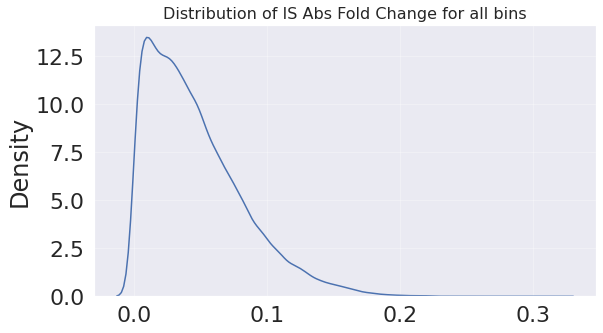

Total number of features: 42953
Number of p_values <= 0.050: 11162
Number of p_values after FDR correction: 4


14282     14283     14284     35648
WT_female_2     0.444180  0.413791  0.379288 -0.265062
WT_female_3     0.434824  0.409935  0.391529 -0.276402
WT_male_1       0.431056  0.433262  0.423213 -0.249603
old_female_2    0.528548  0.539883  0.520195 -0.067546
old_female_3    0.516813  0.534430  0.513157 -0.106329
old_male_1      0.532389  0.524549  0.528388 -0.079973
young_female_2  0.429855  0.425943  0.393686 -0.286080
young_female_3  0.435138  0.423855  0.405221 -0.250814
young_male_1    0.414353  0.417796  0.401963 -0.292838

In [557]:
anova = ANOVA(X, y, 0.05)
anova.get_filter_distribution('FC')

a, b = anova.make_anova()
anova.get_passed_features()

100%|█████████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.13it/s]


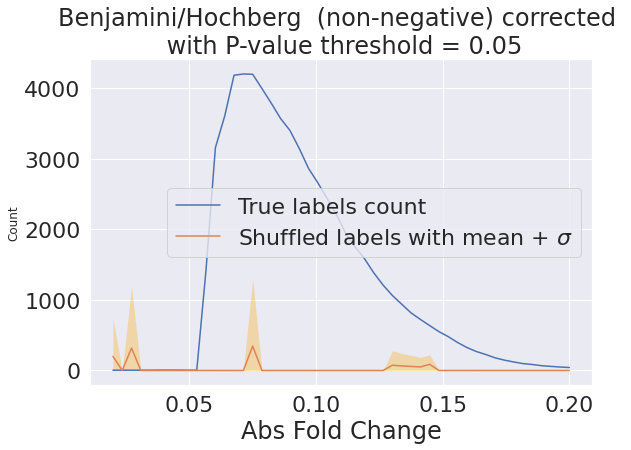

0.07142857142857144

In [558]:
anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
anova.plot_permutation_results()
anova.get_best_criterion()

In [559]:
X_s, FDR, Pval = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
                                                        return_pvals=True)
P_adj_s_sorted = np.sort(FDR[1][FDR[0]])
X_s_sorted = X_s.iloc[:, np.argsort(FDR[1][FDR[0]])]

order = ['old', 'Y']
X_group = X_s_sorted.groupby(y).mean()
X_diff = X_group.loc[order[0]] - X_group.loc[order[1]]
#extract intervals and p_values, take top N bins
X_passed_intervals = IS.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
X_passed_intervals['pval'] = Pval[FDR[0]]
X_passed_intervals['p_adj'] = P_adj_s_sorted
X_passed_intervals['FC'] = X_diff

print("Bins passed: %d" % X_passed_intervals.shape[0])

Bins passed: 4202


In [560]:
top = max(1000, X_passed_intervals.shape[0])
X_top = X_passed_intervals.sort_values('pval').iloc[:top, :]

#intersection with genes
significant_genes = bins_to_genes_intersection(X_top[['chrom', 'start', 'end']], gn_code)

In [561]:
genesFC = significant_genes.merge(X_top, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

gmean = lambda x: np.exp(np.mean(np.log(x)))
agg = genesFC.groupby(['Name']).agg({'chrom':'first',
                                     'Start':'first','End':'first', 
                                     'Start_b':'first', 'End_b':'last', 
                                     'pval':gmean, 'FC':'mean'})
agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
agg['ES'] = -np.log10(agg['pval']) * agg['FC']

In [562]:
agg.to_csv('subdata/IS_results.csv')

In [407]:
#Assumptions:
# - Equal variances (sample sizes)
# - Normal distribution of population
# - Independence
EXPLORES = [['old', 'young'], ['KO', 'young'], ['WT', 'young'], ['KO', 'WT'], ['old', 'WT']]
gmean = lambda x: np.exp(np.mean(np.log(x)))

for explore in tqdm(EXPLORES):
    ### Data filtering
    fname = '::'.join(explore)
    mask = np.array([any([e in c for e in explore]) for c in IS.columns])
    X = IS.drop(IS.columns[~mask], 1).T
    X = X.dropna(axis=1)
    y = [d.split('_')[0] for d in X.index] #0-for age; 1-for sex
    
    ### ANOVA
    anova = ANOVA(X, y, 0.03)
    p, pcor = anova.make_anova()
    X_group = X.groupby(y).mean()
    X_diff = X_group.loc[explore[0]] - X_group.loc[explore[1]]
    #extract intervals and p_values, take top N bins
    X_passed_intervals = IS.loc[X.columns][['chrom', 'start', 'end']]
    X_passed_intervals['pval'] = p
    X_passed_intervals['FC'] = X_diff
   
    # #anova.make_permutation_search('FC', interval=(0.02, 0.2), steps=50, N=15, **{'ddof':1})
    # X_s, P_s = anova.get_passed_features_for_some_criterion(criterion=anova.get_best_criterion(), 
    #                                                         return_pvals=True)
    # #plot
    # #anova.plot_permutation_results(savename='Insulation/' + fname + '_FC.png')
    
    # P_adj_s_sorted = np.sort(P_s[1][P_s[0]])
    # X_s_sorted = X_s.iloc[:, np.argsort(P_s[1][P_s[0]])]
    
    #extract intervals and p_values, take top N bins
    # X_passed_intervals = IS_info.loc[X_s_sorted.columns][['chrom', 'start', 'end']]
    # X_passed_intervals['p_adj'] = P_adj_s_sorted
    # X_top = X_passed_intervals.iloc[:top, :]
    
    # #intersection with genes
    significant_genes = bins_to_genes_intersection(X_passed_intervals[['chrom', 'start', 'end']], gn_code)
    genesFC = significant_genes.merge(X_passed_intervals, 
                    left_on=['Chromosome', 'Start_b', 'End_b'], 
                    right_on=['chrom', 'start', 'end'])[['chrom', 'Start', 'End', 'Start_b', 'End_b', 'Name', 'pval', 'FC']]

    agg = genesFC.groupby(['Name']).agg({'Start':'first','End':'first', 
                                        'Start_b':'first', 'End_b':'last', 
                                        'pval':gmean, 'FC':'mean'})
    agg['p_adj'] = fdr_correction(agg['pval'], alpha=0.05, method='fdr_bh')[1]
    agg['ES'] = -np.log10(agg['pval']) * agg['FC'] * (-1) # corresponds to "openness"
    #break
    # print('Found %d genes in top %d bins' % (len(significant_genes), top))
    agg.to_csv('subdata/IS_results_%s.csv' % (fname))

  0%|                                                                   | 0/5 [00:00<?, ?it/s]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.030: 2878
Number of p_values after FDR correction: 0


 20%|███████████▊                                               | 1/5 [00:05<00:22,  5.52s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.030: 9742
Number of p_values after FDR correction: 1


 40%|███████████████████████▌                                   | 2/5 [00:10<00:16,  5.37s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.030: 1450
Number of p_values after FDR correction: 0


 60%|███████████████████████████████████▍                       | 3/5 [00:15<00:10,  5.28s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.030: 12474
Number of p_values after FDR correction: 251


 80%|███████████████████████████████████████████████▏           | 4/5 [00:21<00:05,  5.23s/it]/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if sys.path[0] == '':


Total number of features: 42953
Number of p_values <= 0.030: 5998
Number of p_values after FDR correction: 1


100%|███████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.26s/it]


In [137]:
ko = pd.read_csv('subdata/IS_results_KO::young.csv', index_col=0)
wt = pd.read_csv('subdata/IS_results_WT::young.csv', index_col=0)
old = pd.read_csv('subdata/IS_results_old::young.csv', index_col=0)
kow = pd.read_csv('subdata/IS_results_KO::WT.csv', index_col=0)
oldw = pd.read_csv('subdata/IS_results_old::WT.csv', index_col=0)

In [138]:
ES = pd.DataFrame()
ES['KO'] = ko['ES']
ES['WT'] = wt['ES']
ES['old'] = old['ES']
ES['KO-W'] = kow['ES']
ES['old-W'] = oldw['ES']

ES.corr()

KO        WT       old      KO-W     old-W
KO     1.000000 -0.045825  0.357672  0.803011  0.282115
WT    -0.045825  1.000000 -0.056689 -0.477473 -0.649553
old    0.357672 -0.056689  1.000000  0.329940  0.674201
KO-W   0.803011 -0.477473  0.329940  1.000000  0.599089
old-W  0.282115 -0.649553  0.674201  0.599089  1.000000

### ANOVA on dIS bins

In [578]:
dis = pd.read_csv('subdata/IS_results.csv')
#dis = pd.read_csv('subdata/IS_results_old::WT.csv')
dis = dis[(dis['End'] - dis['Start']) > 50000]
dis.head()

Name  chrom      Start        End    Start_b      End_b  \
0   0610010F05Rik  chr11   23514949   23596409   23550000   23600000   
2   0610040F04Rik   chr6  108553997  108637895  108550000  108650000   
11  1700016L04Rik  chr10   14581353   14634763   14550000   14650000   
13  1700020G17Rik  chr10  110637035  110732368  110600000  110650000   
34  1700123O12Rik   chr4   10508031   10797802   10600000   10800000   

        pval        FC     p_adj        ES  
0   0.006105  0.150720  0.017607  0.333745  
2   0.011947  0.162626  0.017894  0.312690  
11  0.010223 -0.086796  0.017698 -0.172761  
13  0.004894  0.074495  0.017607  0.172110  
34  0.011641 -0.093251  0.017765 -0.180349

In [579]:
dis.sort_values('p_adj')

Name  chrom      Start        End    Start_b      End_b  \
0     0610010F05Rik  chr11   23514949   23596409   23550000   23600000   
1753        Gm39880   chr2   92609767   92679177   92600000   92700000   
1751        Gm39857   chr2   75122159   75226497   75200000   75250000   
3506           Rtl4   chrX  143471147  143905410  143900000  143950000   
1738        Gm39530   chrX  103711065  103763218  103700000  103800000   
...             ...    ...        ...        ...        ...        ...   
1606         Gm3629  chr14   15785541   15837092   15750000   15800000   
1219        Gm26680  chr14   15634489   15785713   15750000   15800000   
3716        St3gal3   chr4  117789349  117992169  117900000  117950000   
924          Gigyf2   chr1   87254653   87378532   87250000   87300000   
4043        Zfp280d   chr9   72181900   72271061   72250000   72300000   

          pval        FC     p_adj        ES  
0     0.006105  0.150720  0.017607  0.333745  
1753  0.004043  0.105702  0.017607  0.252979  
1751  0.004457 -0.076876  0.017607 -0.180734  
3506  0.003434  0.085268  0.017607  0.210120  
1738  0.000198  0.101575  0.017607  0.376214  
...        ...       ...       ...       ...  
1606  0.021850 -0.074547  0.022028 -0.123789  
1219  0.021850 -0.074547  0.022028 -0.123789  
3716  0.021889  0.072140  0.022046  0.119736  
924   0.022005  0.104844  0.022131  0.173776  
4043  0.022247  0.078693  0.022249  0.130059  

[1086 rows x 10 columns]

In [606]:
f = open('subdata/genesets/testset.gmt', 'r').readlines()[0].split('\t')
gene_sets = {f[0]:f[1:]}

In [609]:
import gseapy as gp
from gseapy.parser import gsea_gmt_parser    
set_names = [#'MSigDB_Hallmark_2020', 
            #'KEGG_2019_Mouse', 
            #'Reactome_2016', 
            'GO_Biological_Process_2021'
            ]
#set_names_dict = {'MSigDB_Hallmark_2020'}
gene_sets = {}
for g in set_names:
    gs = gsea_gmt_parser(g)
    for k,v in gs.items():
        idx = g+':::'+k
        if idx in terms_list:
            gene_sets[idx] = v

KeyboardInterrupt: 

In [589]:
de_genes = sc_neur[(sc_neur.qval < 0.05) & (np.abs(sc_neur.log2fc) > np.log2(1.1))] #10%
sc_neur_filt = sc_neur.merge(gn_code[['Name', 'seq_id', 'start', 'end']], left_on='gene', right_on='Name')
#size filter
sc_neur_filt = sc_neur_filt[(sc_neur_filt['end'] - sc_neur_filt['start']) > 50000]
universe_test = sc_neur_filt[sc_neur_filt['mean'] >= de_genes['mean'].min()].gene.tolist()
universe_test = list(map(str.upper, universe_test))

In [607]:
#gene_sets=['GO_Biological_Process_2021', 
           #'GO_Molecular_Function_2021', 
           #'GO_Cellular_Component_2021',
           #'KEGG_2019_Mouse', 
           #'Reactome_2016', 'MSigDB_Hallmark_2020'
           #'Aging_Perturbations_from_GEO_up', 'Aging_Perturbations_from_GEO_down'  
#          ]

gset = dis[dis.FC > 0]['Name'].tolist() #dwreg
gset = list(map(str.upper, gset))
#gset = dis['Name'].tolist()
print('N genes in analysis:', len(gset))
enr = gp.enrichr(gene_list=gset,
                gene_sets=gene_sets,
                organism='Mouse', 
                description='test_run',
                #outdir='tmp/enrichment/%s' % name,
                cutoff=0.05, # test dataset, use lower value from range(0,1)
                background=universe_test,
                no_plot=True
                )
eres = enr.results 
eres['Hits'] = eres['Genes'].str.split(';').apply(len)
eres = eres[eres['Hits'] > 1]

ax = gp.plot.dotplot(eres, cutoff=0.05)
#ax.set_title('Downregulated genes', fontsize=16)
#plt.savefig('./figs/peaks_enrichment_dw_genes.pdf', dpi=300, bbox_inches='tight')

INFO:gseapy:Connecting to Enrichr Server to get latest library names
INFO:gseapy:Save file of enrichment results: Job Id:140054431519040
INFO:gseapy:Done.



N genes in analysis: 897


In [608]:
eres.head(10)

Gene_set                   Term Overlap   P-value  \
0  CUSTOM140054431519040  HALLMARK_ADIPOGENESIS    9/40  0.400513   

   Adjusted P-value  Odds Ratio  \
0          0.400513    1.179705   

                                               Genes  Hits  
0  MYLK;ME1;ITSN1;MGLL;PPARG;SORBS1;SCARB1;GPHN;M...     9

In [571]:
tlist = eres.iloc[0].Genes.split(';')
tlist = [g.lower().capitalize() for g in tlist]
dis.set_index('Name').loc[tlist]

chrom      Start        End    Start_b      End_b      pval  \
Name                                                                   
Robo2    chr16   73688864   75244331   74700000   75000000  0.008300   
Shc3     chr13   51577422   51724909   51550000   51600000  0.012860   
Atl1     chr12   69939879   70010859   69950000   70050000  0.009762   
Nrxn1    chr17   90341072   91400587   90300000   91150000  0.005727   
Nrxn3    chr12   88689454   90301709   88800000   88900000  0.015066   
Efna5    chr17   62909952   63188312   63100000   63200000  0.018814   
Mypn     chr10   62951574   63039731   62950000   63050000  0.008737   
Rps6ka5  chr12  100514692  100691693  100500000  100700000  0.011988   
Kif5c     chr2   49509298   49664790   49500000   49700000  0.008516   
Slit1    chr19   41586263   41735714   41600000   41750000  0.008533   
Tnr       chr1  159351170  159759299  159350000  159750000  0.008470   
Nrcam    chr12   44375568   44651977   44350000   44550000  0.002924   
Slit3    chr11   35012283   35599334   35200000   35300000  0.009297   
Ephb2     chr4  136374850  136563637  136450000  136550000  0.006918   
Epha6    chr16   59473424   60431196   59750000   60350000  0.008704   
Unc5a    chr13   55090545   55153831   55050000   55200000  0.009678   
Dscam    chr16   96388652   96971935   96550000   97000000  0.007473   
Auts2     chr5  131466171  132572059  131700000  131950000  0.006421   
Ranbp9   chr13   43556149   43634949   43600000   43650000  0.006629   
Lmtk2     chr5  144037179  144125026  144050000  144150000  0.005163   
Unc5c     chr3  141171325  141540685  141500000  141550000  0.007059   
Ptpn11    chr5  121268596  121329460  121250000  121300000  0.003305   
Ank3     chr10   69234608   69863266   69600000   69900000  0.007860   
Gab2      chr7   96730958   96958158   96750000   96950000  0.011312   
Sptb     chr12   76627262   76757321   76700000   76800000  0.005775   
Ptk2     chr15   73076951   73297192   73250000   73300000  0.000250   
Shtn1    chr19   58961790   59064536   58950000   59100000  0.012884   
Dab1      chr4  103476425  104602041  103750000  104650000  0.008300   
Map1b    chr13   99557972   99653110   99550000   99600000  0.017310   
Adgrb1   chr15   74388045   74461314   74350000   74450000  0.004537   
Evl      chr12  108520942  108654775  108500000  108550000  0.008327   
Cntn4     chr6  105654298  106677102  105750000  106400000  0.013058   
Sos1     chr17   80701181   80787882   80700000   80800000  0.011014   
Dscaml1   chr9   45338735   45665011   45450000   45700000  0.003290   

               FC     p_adj        ES  
Name                                   
Robo2    0.090840  0.017698  0.189028  
Shc3     0.082688  0.018092  0.156343  
Atl1     0.153253  0.017698  0.308109  
Nrxn1    0.128204  0.017607  0.287444  
Nrxn3    0.099242  0.019018  0.180819  
Efna5    0.095927  0.020333  0.165523  
Mypn     0.078247  0.017698  0.161081  
Rps6ka5  0.118886  0.017905  0.228410  
Kif5c    0.146494  0.017698  0.303209  
Slit1    0.093666  0.017698  0.193784  
Tnr      0.108857  0.017698  0.225562  
Nrcam    0.141769  0.017607  0.359245  
Slit3    0.076103  0.017698  0.154616  
Ephb2    0.086411  0.017607  0.186652  
Epha6    0.075479  0.017698  0.155506  
Unc5a    0.123163  0.017698  0.248077  
Dscam    0.083114  0.017698  0.176743  
Auts2    0.081364  0.017607  0.178382  
Ranbp9   0.114717  0.017607  0.249916  
Lmtk2    0.095513  0.017607  0.218449  
Unc5c    0.084179  0.017607  0.181088  
Ptpn11   0.136567  0.017607  0.338797  
Ank3     0.134681  0.017698  0.283449  
Gab2     0.109281  0.017765  0.212711  
Sptb     0.106409  0.017607  0.238193  
Ptk2     0.125267  0.017607  0.451292  
Shtn1    0.089873  0.018099  0.169854  
Dab1     0.077547  0.017698  0.161368  
Map1b    0.107633  0.019669  0.189618  
Adgrb1   0.078936  0.017607  0.184962  
Evl      0.104581  0.017698  0.217475  
Cntn4    0.077680  0.018178  0.146359  
Sos1     0.124246  0.017765  0.243281  
Dscaml1  0.12262

['PCDHA11',
 'PCDHA10',
 'PCDHB2',
 'PCDHA1',
 'PCDHA5',
 'PCDHA4',
 'PCDHB4',
 'PCDHA3',
 'PCDHB3',
 'PCDHA2',
 'PCDHA8',
 'PCDHA7',
 'PCDHAC1',
 'PCDHA6']

## Age dependence analysis

In [130]:
X = X.dropna(axis=1)

In [131]:
y = [4, 10, 20]
x_labels = ['young', 'WT', 'old']
y_dic = dict(zip(x_labels, y))

mask = np.array([any([e in c for e in x_labels]) for c in X.index])
X1 = X.loc[mask]
age = [y_dic[y] for y in [x.split('_')[0] for x in X1.index]]

import statsmodels.api as sm
from sklearn.linear_model import ElasticNet
from scipy.stats import pearsonr
pvals = []
coefs = []
for i in tqdm(range(X1.shape[1])):
    x = X1.iloc[: ,i]
#     X2 = sm.add_constant(x)
#     est = sm.OLS(age, X2)
#     est2 = est.fit()
#     res = est2.summary()
    r, p = pearsonr(x, age)
#     p = float(res.tables[1].data[2][4])
    pvals.append(p)
    coefs.append(r)

#model = ElasticNet()
#model.fit(X1, age)

100%|█████████████████████████████████████████████| 42953/42953 [00:04<00:00, 8609.38it/s]


(array([2.0000e+00, 5.0000e+00, 1.9000e+01, 6.1000e+01, 1.9900e+02,
        5.8100e+02, 2.1140e+03, 6.1410e+03, 1.3242e+04, 2.0589e+04]),
 array([-5.25071925e+00, -4.72565544e+00, -4.20059163e+00, -3.67552782e+00,
        -3.15046401e+00, -2.62540020e+00, -2.10033639e+00, -1.57527258e+00,
        -1.05020877e+00, -5.25144961e-01, -8.11513498e-05]),
 <a list of 10 Patch objects>)

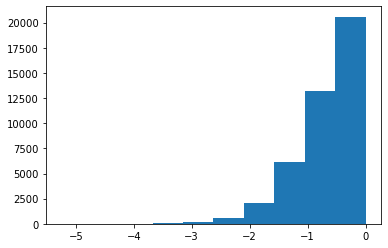

In [182]:
plt.hist(np.log10(pvals))

(array([ 483., 2941., 5594., 5697., 5019., 4575., 5114., 6810., 5537.,
        1183.]),
 array([-0.97737087, -0.78350638, -0.5896419 , -0.39577741, -0.20191292,
        -0.00804843,  0.18581606,  0.37968055,  0.57354503,  0.76740952,
         0.96127401]),
 <a list of 10 Patch objects>)

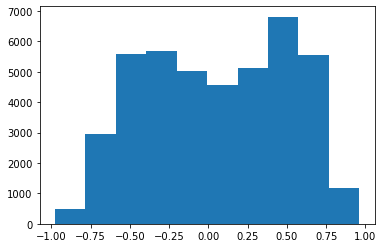

In [ ]:
plt.hist(coefs)

## TAD shift analysis

In [132]:
order = 5
indices = []
for i in range(X.shape[0]):
    row = X.iloc[i,:]
    s = np.array(row)
    lm = argrelextrema(s, np.less, order=order)[0]
    indices.append(row.iloc[lm].index)

result = sorted(list(set(indices[0]).intersection(*indices)))
border_dict = dict(zip(list(X.index), indices))

In [94]:
convex_dict = {}
for key in border_dict.keys():
    b = border_dict[key]
    convex_dict[key] = {}
    for i in range(b.shape[0]):
        x = np.arange(-order, order+1)
        v = X.loc[key, b[i]-order:b[i]+order] #vicinity of minimum
        y = v.to_numpy()

        def func(x, a):
            return a*(x**2) + y[y.shape[0]//2]

        params, _ = optimization.curve_fit(func, x, y)
        convex_dict[key][b[i]] = params.item()
    

# plt.scatter(x, y, marker='o', c='red')
# plt.plot(x, func(x, params), c='black')
# plt.show()

In [135]:
border_dict.keys()

dict_keys(['combined_KO_down_50000', 'combined_WT_down_50000', 'combined_old_down_50000', 'combined_young_down_50000'])

37449

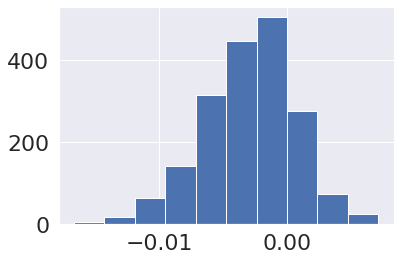

In [98]:
test = border_dict['combined_KO_down_50000'].intersection(border_dict['combined_WT_down_50000']).tolist()


diff = []
for t in test:
    d = convex_dict['combined_KO_down_50000'][t] - convex_dict['combined_WT_down_50000'][t]
    diff.append(d)

plt.hist(diff)
test[np.argmin(diff)]

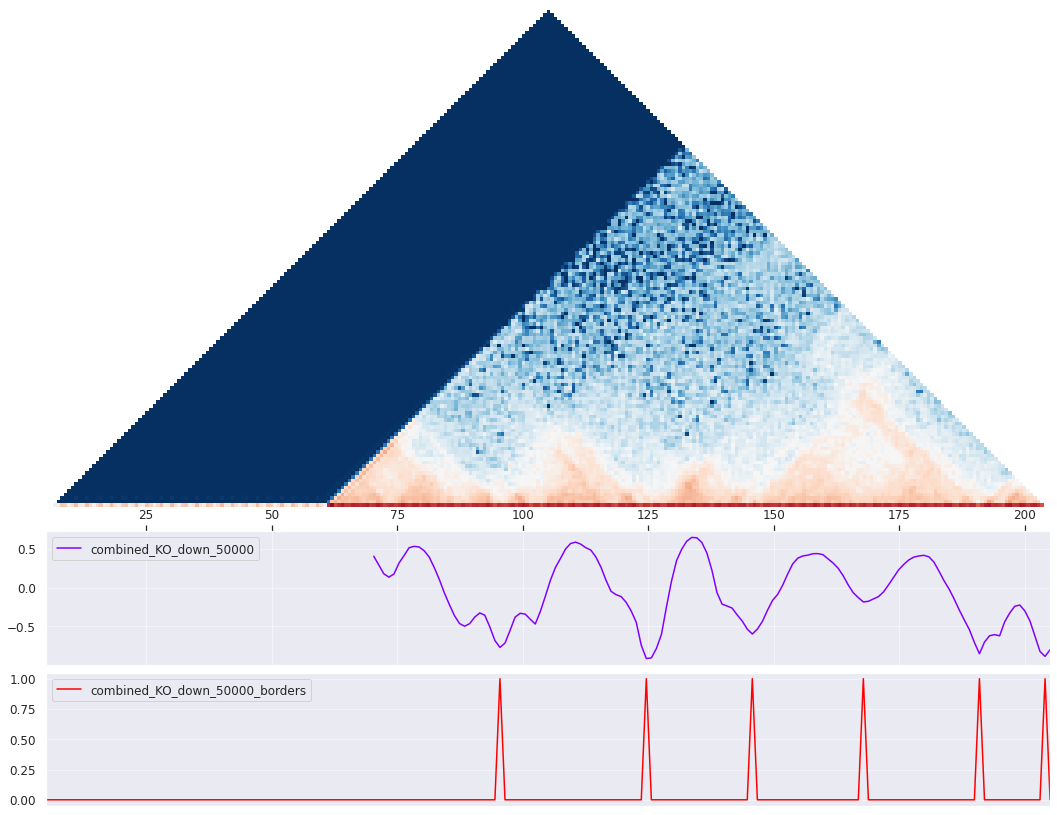

In [100]:
pos = 105
st, fin = (pos-100, pos+100) # in bins

rep = 'combined_KO_down_50000'

assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
chrom = IS.loc[st:fin].chrom.unique()[0]

#HI-C
cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
D = cool.matrix(balance=True).fetch(chrom)
D = mylog(D, log=True)
bins = cool.bins()[:]
start = bins[bins.chrom==chrom].index[0]
#IS
profile = np.array(IS[rep])#.loc[st:fin-1])
#TAD BORDERS
borders_plot = np.zeros(profile.shape)
for idx in border_dict[rep]:
    borders_plot[idx] += 1

plot_hic(D, st, fin, profile=[profile, borders_plot], 
                         profnames=[rep, rep + '_borders'], chrom_start=start)

In [15]:
# rep = 'young_male_1'

# assert len(IS.loc[st:fin].chrom.unique()) == 1, 'choose one chromosome interval'
# chrom = IS.loc[st:fin].chrom.unique()[0]

# #HI-C
# cool = [c for c in CLRS if c.filename.__contains__(rep)][0]
# D = cool.matrix(balance=True).fetch(chrom)
# D = mylog(D, log=True)
# bins = cool.bins()[:]
# start = bins[bins.chrom==chrom].index[0]
# #IS
# profile = np.array(IS[rep])#.loc[st:fin-1])
# #TAD BORDERS
# borders_plot = np.zeros(profile.shape)
# for idx in border_dict[rep]:
#     borders_plot[idx] += 1

# plot_hic(D, st, fin, profile=[profile, borders_plot], 
#                          profnames=[rep, rep + '_borders'], chrom_start=start)

## insulation peaks fold change

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

KO v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.040e-04 U_stat=6.462e+06
old v.s. young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.111e+06
WT v.s. young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.029e+06
KO v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.092e-03 U_stat=6.379e+06


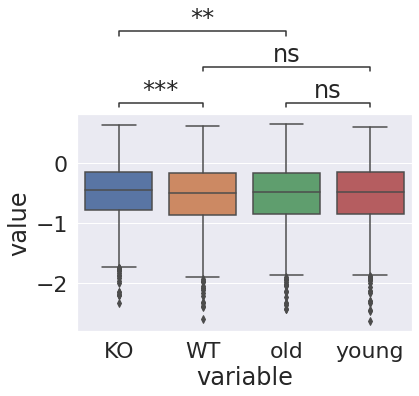

In [184]:
from functools import reduce
union = reduce(pd.Index.union, border_dict.values())

bpeaks = IS.loc[union]
tmp = pd.melt(bpeaks.iloc[:, 1:5])
tmp['variable'] = tmp['variable'].apply(lambda x: x.split('_')[1])
#for pair in 
#d = bpeaks.filter(regex='KO').iloc[:, 0] - bpeaks.filter(regex='WT').iloc[:, 0]
#d.plot(kind='kde')

from statannot import add_stat_annotation

df = sns.load_dataset("tips")
x = "variable"
y = "value"
order = ['KO', 'WT', 'old', 'young']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("KO", "WT"), ("old", "young"), ("WT", "young"), ("KO", "old")],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

## IS vs compartments (bins of active chromatin)

In [85]:
comp_df_coo = pd.read_csv('subdata/compartments_50000_merged_E1.csv', index_col=0)
IS.columns = ['index', 'KO', 'WT', 'old', 'young', 'chrom', 'start', 'end']
IS = IS[IS.chrom != 'chrY'].drop('KO', axis=1)

In [86]:
IS

index  WT  old  young chrom      start        end
0          0 NaN  NaN    NaN  chr1          0      50000
1          1 NaN  NaN    NaN  chr1      50000     100000
2          2 NaN  NaN    NaN  chr1     100000     150000
3          3 NaN  NaN    NaN  chr1     150000     200000
4          4 NaN  NaN    NaN  chr1     200000     250000
...      ...  ..  ...    ...   ...        ...        ...
52680  52680 NaN  NaN    NaN  chrX  170800000  170850000
52681  52681 NaN  NaN    NaN  chrX  170850000  170900000
52682  52682 NaN  NaN    NaN  chrX  170900000  170950000
52683  52683 NaN  NaN    NaN  chrX  170950000  171000000
52684  52684 NaN  NaN    NaN  chrX  171000000  171031299

[52685 rows x 7 columns]

In [87]:
comp_IS = comp_df_coo.merge(IS, on=['chrom', 'start', 'end'], suffixes=('_c', '_i')).drop('index', axis=1)

<AxesSubplot:>

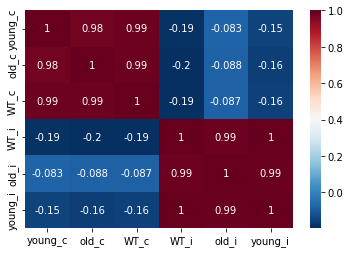

In [88]:
sns.heatmap(comp_IS.iloc[:, 3:].corr(), annot=True, cmap='RdBu_r')

<AxesSubplot:>

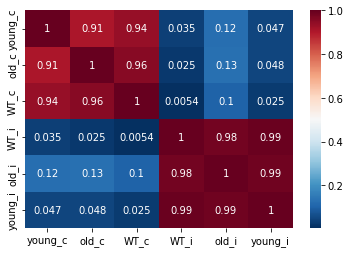

In [100]:
# for a particular chromosome
tmp = comp_IS[comp_IS.chrom == 'chrX']
sns.heatmap(tmp.iloc[:, 3:].corr(), annot=True, cmap='RdBu_r')

In [101]:
comp_IS = comp_IS.dropna(axis=0)

comp_IS['A-I'] = (comp_IS['old_c'] < 0) & (comp_IS['young_c'] > 0)
comp_IS['I-A'] = (comp_IS['old_c'] > 0) & (comp_IS['young_c'] < 0)
comp_IS['A-A'] = (comp_IS['old_c'] > 0) & (comp_IS['young_c'] > 0)
comp_IS['I-I'] = (comp_IS['old_c'] < 0) & (comp_IS['young_c'] < 0)

In [105]:
AI = comp_IS[comp_IS['A-I'] == True]
IA = comp_IS[comp_IS['I-A'] == True]
AA = comp_IS[comp_IS['A-A'] == True]
II = comp_IS[comp_IS['I-I'] == True]

((AI['old_i'] - AI['young_i']).mean(),
(IA['old_i'] - IA['young_i']).mean(),
(AA['old_i'] - AA['young_i']).mean(),
(II['old_i'] - II['young_i']).mean())

(-0.0008481776953574522,
 0.017664268648654932,
 0.039981642813006715,
 -0.018182687071185973)

In [110]:
comp_IS.old_i.describe()

count    43942.000000
mean        -0.049813
std          0.455998
min         -2.438916
25%         -0.309191
50%          0.003912
75%          0.264678
max          1.147509
Name: old_i, dtype: float64

<AxesSubplot:>

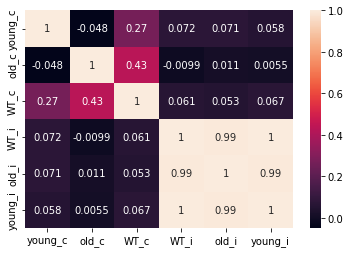

In [103]:
sns.heatmap(IA.iloc[:, 3:9].corr(), annot=True)


# interTADs

In [634]:
#coolpuppy API
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [24]:
# mm10_chromsizes.to_csv('/tank/projects/kriukov_chromatin/GENOME/chrfile.txt', sep='\t')
# mm10_arms.to_csv('/tank/projects/kriukov_chromatin/GENOME/chrom_arms.txt', sep='\t')

In [642]:
from scipy.signal import argrelextrema
import scipy.optimize as optimization

explore = ['WT', 'young', 'old']
mask = np.array([any([e in c for e in explore]) for c in IS.columns])

X = IS.drop(IS.columns[~mask], 1).T
X = X.dropna(axis=1)

order = 5
indices = []
for i in range(X.shape[0]):
    row = X.iloc[i,:]
    s = np.array(row)
    lm = argrelextrema(s, np.less, order=order)[0]
    indices.append(row.iloc[lm].index)

result = sorted(list(set(indices[0]).intersection(*indices)))
border_dict = dict(zip(list(X.index), indices))

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  import sys


In [643]:
#construct average interTADs
pup = pd.DataFrame()
cond = [basename(c.filename).split('_')[1] for c in CLRS]
for k, v in border_dict.items():
    clr = [c for c in CLRS if c.filename.__contains__(k)][0]
    name = splitext(basename(clr.filename))[0]
    sites = IS.loc[v.tolist(),['chrom', 'start', 'end']].reset_index(drop=True)
    # Calculate expected interactions for chromosome arms
    expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
    #calculate mean interTADs
    cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                              features_format='bed', local=True, flank=1_000_000)
    pu = coolpup.PileUpper(clr, cc, expected=expected, view_df=mm10_arms, ignore_diags=0)
    pup = pup.append(pu.pileupsWithControl(nproc=18))
pup['condition'] = explore
#pup['id'] = [basename(c.filename).split('_')[1] + '_' + basename(c.filename).split('_')[2].split('.')[0] for c in CLRS]

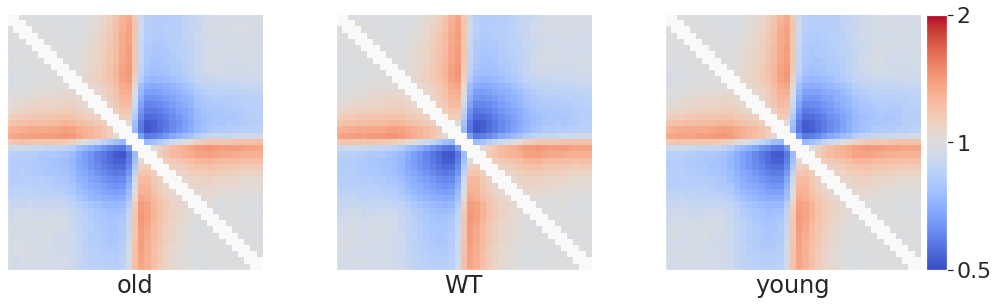

In [644]:
plotpup.make_heatmap_grid(pup,
                          #rows='condition', #col_order=['--', '++'],
                          cols='condition',
                          score=False, cmap='coolwarm', scale='log',
                          sym=True, vmax=2,
                          height=5)
plt.show()

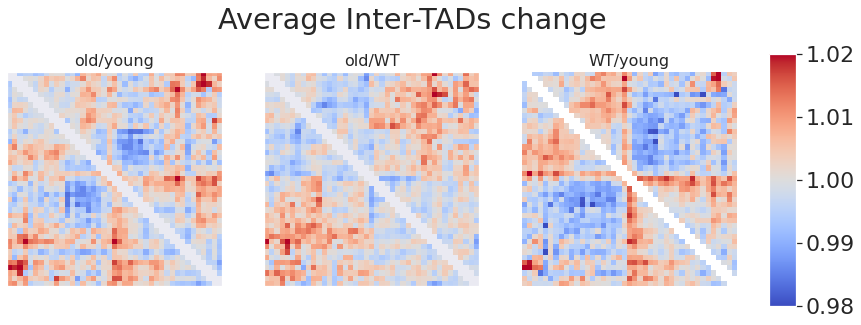

In [647]:
sns.set_theme(font_scale=2)
pairs = [['old', 'young'], ['old', 'WT'], ['WT', 'young']]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.suptitle(f'Average Inter-TADs change')
for pair, ax in zip(pairs, axes.flatten()):
    divv = pup[pup.condition==pair[0]]['data'][0] / pup[pup.condition==pair[1]]['data'][0]
    img = ax.imshow(divv, interpolation='None', cmap='coolwarm', vmax=1.02, vmin=0.98)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('%s/%s' % (pair[0], pair[1]), fontsize=16)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.025, 0.7])
fig.colorbar(img, cax=cbar_ax)
if len(pairs) % 2 != 0: #remove redundant axis
    axes.flatten()[-1].set_axis_off()
plt.savefig(f'./figs/avg_InterTAD.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

# TADs

## plot TADs

In [648]:
#!pip install git+https://github.com/nvictus/lavaburst.git

#import lavaburst

#coolpuppy API
# import libraries for biological data analysis
from coolpuppy import coolpup
from plotpuppy import plotpup
import cooler
import bioframe
import cooltools
from cooltools import expected_cis
from cooltools.lib import plotting
import logging
from statannot import add_stat_annotation
logging.getLogger().disabled = True
sns.set_theme(font_scale=2)

# Use bioframe to fetch the genomic features from the UCSC.
mm10_chromsizes = bioframe.fetch_chromsizes('mm10')
mm10_cens = bioframe.fetch_centromeres('mm10')
mm10_arms = bioframe.make_chromarms(mm10_chromsizes, mm10_cens)

# Select only chromosomes that are present in the cooler. 
# This step is typically not required! we call it only because the test data are reduced. 
mm10_arms = mm10_arms.set_index("chrom").loc[CLRS[0].chromnames].reset_index()
# call this to automaticly assign names to chromosomal arms:
mm10_arms = bioframe.make_viewframe(mm10_arms)

In [640]:
#construct average TADs
ids_10k = cooler.Cooler(DOWNSAMPLED_FOLDER_PATH + '/merged/combined_WT_down_10000.cool').bins()[:]
base_expected = False #CLRS_DICT['WT']
MINIMAL_TAD_SIZES = [50_000, 1_000_000]
MAXIMAL_TAD_SIZES = [1_000_000, np.inf] 

pup_dict = {}
for minimal_tad_size, maximal_tad_size in zip(MINIMAL_TAD_SIZES, MAXIMAL_TAD_SIZES):
    pup = pd.DataFrame()
    for cond, clr in zip(LBLS, CLRS):
        name = splitext(basename(clr.filename))[0]
        #gather tad coordinates
        tad_name = [c for c in list(TADS.keys()) if c.__contains__(cond)][0]
        tads = TADS[tad_name]
        sites = pd.DataFrame()
        for chrom in tads.keys():
            tads[chrom]
            for t in tads[chrom]:
                st = ids_10k[ids_10k['chrom']==chrom].iloc[t[0]]['start']
                en = ids_10k[ids_10k['chrom']==chrom].iloc[t[1]]['end']
                sites = sites.append({'chrom':chrom, 'start':st, 'end':en}, ignore_index=True)
        sites['start'] = sites['start'].astype(int)
        sites['end'] = sites['end'].astype(int)
        #sites = sites.head(1)
        sites = sites[((sites['end'] - sites['start']) > minimal_tad_size) &\
                      ((sites['end'] - sites['start']) < maximal_tad_size)]
        # Calculate expected interactions for chromosome arms
        if base_expected:
            expected = expected_cis(base_expected, view_df=mm10_arms, chunksize=1000000, nproc=18)
        else:
            expected = expected_cis(clr, view_df=mm10_arms, chunksize=1000000, nproc=18)
        #calculate mean interTADs
        cc = coolpup.CoordCreator(sites, resolution=RESOLUTION, 
                                  features_format='bed', local=True, rescale_flank=0.5)
        pu = coolpup.PileUpper(clr, cc, 
                               expected=expected, 
                               rescale=True,
                               view_df=mm10_arms, ignore_diags=0)
        pup = pup.append(pu.pileupsWithControl(nproc=18))
    pup['condition'] = LBLS
    pup_dict[str(minimal_tad_size) + '<size<' + str(maximal_tad_size)] = pup


/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: Ignoring flank in favor of rescale_flank = 0.5
Process ForkPoolWorker-452:
Process ForkPoolWorker-457:
Process ForkPoolWorker-467:
Process ForkPoolWorker-464:
Process ForkPoolWorker-459:
Process ForkPoolWorker-463:


KeyboardInterrupt: 

Process ForkPoolWorker-458:
Process ForkPoolWorker-460:
Process ForkPoolWorker-454:
Process ForkPoolWorker-465:
Process ForkPoolWorker-453:
Process ForkPoolWorker-462:
Process ForkPoolWorker-461:
Process ForkPoolWorker-455:
Process ForkPoolWorker-451:
Process ForkPoolWorker-456:
Process ForkPoolWorker-466:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/mu

  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/queues.py", line 351, in get
    with self._rlock:
  File "/home/dkriukov/miniconda3/envs/mice/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/dkriuk

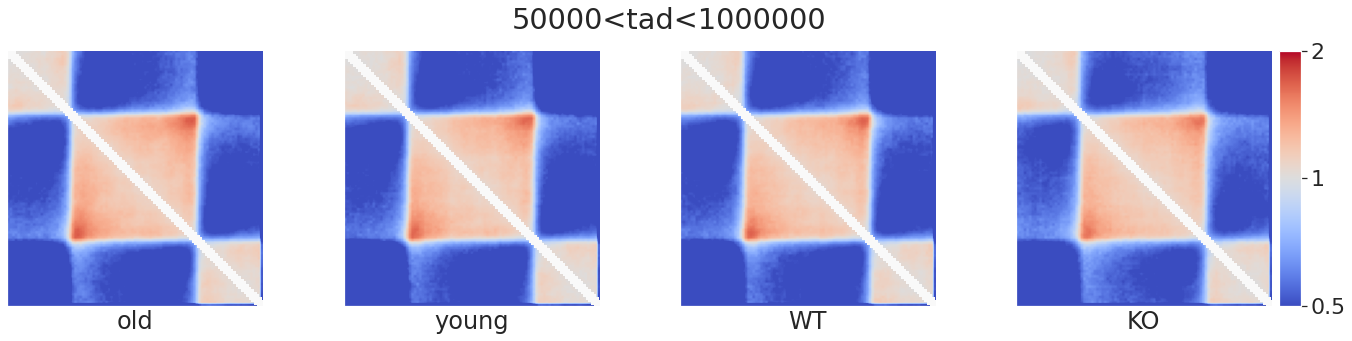

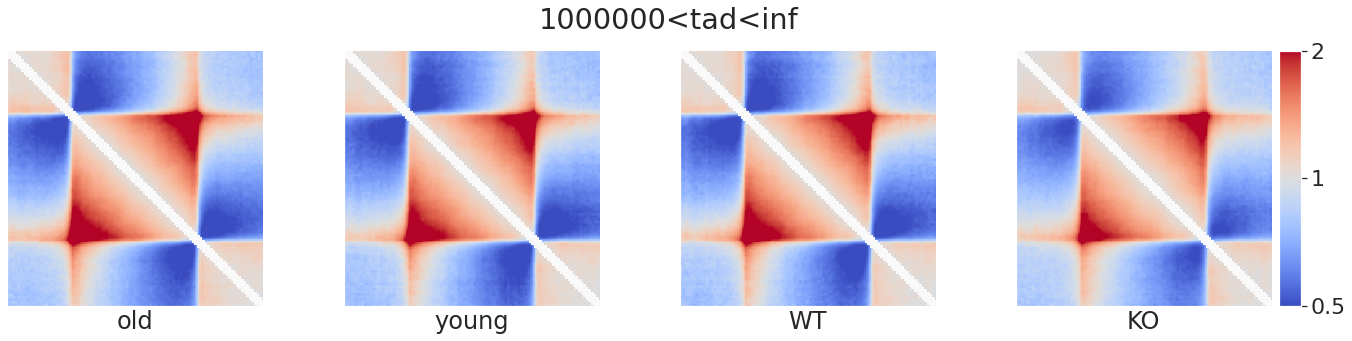

In [300]:
for tadrange, pup in pup_dict.items():
    ax = plotpup.make_heatmap_grid(pup,
                              #rows='condition', #col_order=['--', '++'],
                              cols='condition',
                              score=False, cmap='coolwarm', scale='log',
                              sym=True, vmax=2,
                              height=5)
    ax.fig.suptitle(tadrange, x=0.5)
    plt.show()

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


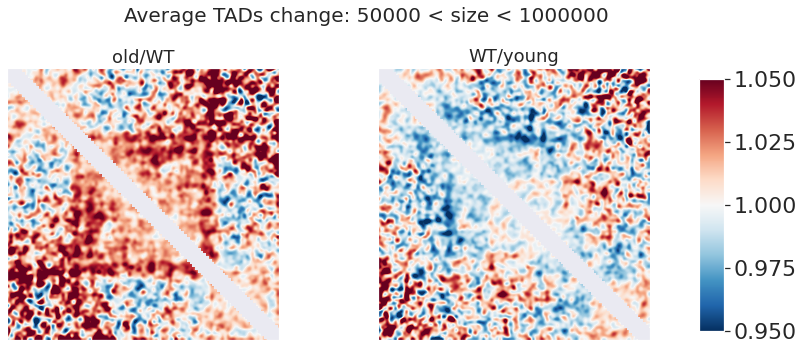

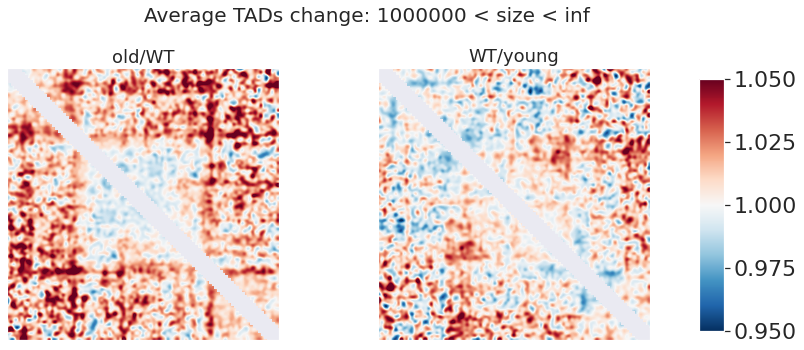

In [320]:
sns.set_theme(font_scale=2)

for tadrange, pup in pup_dict.items():
    minimal_tad_size, maximal_tad_size = tadrange.split('<tad<')

    #pairs = [['KO', 'young'], ['KO', 'WT'], ['KO', 'old'], ['old', 'young'], ['old', 'WT'], ['WT', 'young']]
    pairs = [['old', 'WT'], ['WT', 'young']]

    fig, axes = plt.subplots(len(pairs)//3 + 1, min(len(pairs), 3), figsize=(7 * (len(pairs)//2 + 1), 5), sharex=True, sharey=True)
    fig.suptitle(f'Average TADs change: {minimal_tad_size} < size < {maximal_tad_size}', 
                 fontsize=20, y=1.05)
    for pair, ax in zip(pairs, axes.flatten()):
        divv = pup[pup.condition==pair[0]]['data'][0] / pup[pup.condition==pair[1]]['data'][0]
        img = ax.imshow(divv, cmap='RdBu_r', vmax=1.05, vmin=0.95, interpolation='bicubic')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('%s/%s' % (pair[0], pair[1]), fontsize=18)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.83, 0.15, 0.025, 0.7])
    fig.colorbar(img, cax=cbar_ax)
    if len(pairs) % 2 != 0: #remove redundant axis
        axes.flatten()[-1].set_axis_off()

    plt.savefig(f'./figs/avg_TAD_{minimal_tad_size}<size<{maximal_tad_size}.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

50000<tad<1000000_old/WT v.s. 50000<tad<1000000_WT/young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.153e-246 U_stat=1.243e+06
1000000<tad<inf_old/WT v.s. 1000000<tad<inf_WT/young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.761e-01 U_stat=6.757e+05


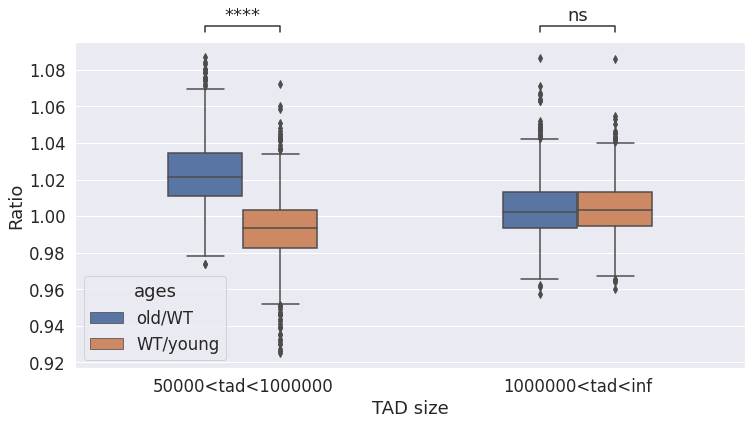

In [281]:
#boxplots on TAD regions ratio

pairs = [['old', 'WT'], ['WT', 'young']]
statvals = pd.DataFrame()
for tadrange, pup in pup_dict.items():
    for pair in pairs:
        divv = pup[pup.condition==pair[0]]['data'][0] / pup[pup.condition==pair[1]]['data'][0]
        div_tad = divv[24:74, 24:74]
        vals = div_tad[np.triu_indices_from(div_tad, k=2)]
        statvals['%s/%s_%s' % (pair[0], pair[1], tadrange)] = vals
        
sns.set_theme(font_scale=1.5)
statmelt = pd.melt(statvals)
statmelt[['ages', 'TAD size']] = statmelt.variable.str.split('_', expand=True)


x = 'TAD size'
y = "value"
hue = 'ages'
hue_order=['old/WT', 'WT/young']
plt.figure(figsize=(12,6))
ax = sns.boxplot(data=statmelt, x=x, y=y, hue=hue, 
                 #order=order, 
                 width=0.45)

test_results = add_stat_annotation(ax, data=statmelt, x=x, y=y, hue=hue, hue_order=hue_order, width=0.45,
                                   box_pairs=[(('50000<tad<1000000', 'old/WT'), ('50000<tad<1000000', 'WT/young')),
                                              (('1000000<tad<inf', 'old/WT'), ('1000000<tad<inf', 'WT/young')),
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)
ax.set_ylabel('Ratio')
plt.savefig(f'./figs/avg_TAD_ages_TAD_boxplots_ratio.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

1000000<tad<inf_WT v.s. 1000000<tad<inf_young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.954e+05
50000<tad<1000000_old v.s. 50000<tad<1000000_WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.589e-07 U_stat=7.819e+05
50000<tad<1000000_WT v.s. 50000<tad<1000000_young: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.353e-01 U_stat=6.651e+05
1000000<tad<inf_old v.s. 1000000<tad<inf_WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=6.955e+05


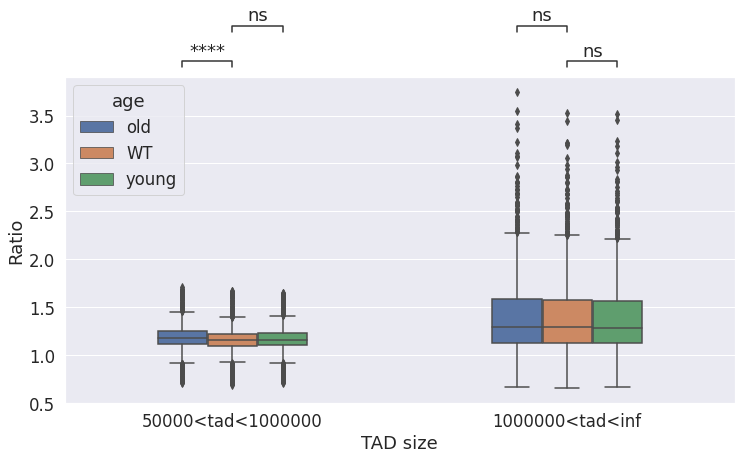

In [279]:
statvals = pd.DataFrame()
for tadrange, pup in pup_dict.items():
    for condition in ['old', 'WT', 'young']:
        m = pup[pup.condition==condition]['data'][0] 
        m_tad = m[24:74, 24:74]
        vals = m_tad[np.triu_indices_from(m_tad, k=2)]
        statvals['%s_%s' % (condition, tadrange)] = vals

sns.set_theme(font_scale=1.5)
statmelt = pd.melt(statvals)
statmelt[['age', 'TAD size']] = statmelt.variable.str.split('_', expand=True)

x = 'TAD size'
y = "value"
hue = 'age'
hue_order=['old', 'WT', 'young']
plt.figure(figsize=(12,6))
ax = sns.boxplot(data=statmelt, x=x, y=y, hue=hue, 
                 #order=order, 
                 width=0.45)

test_results = add_stat_annotation(ax, data=statmelt, x=x, y=y, hue=hue, hue_order=hue_order, width=0.45,
                                   box_pairs=[(('50000<tad<1000000', 'old'), ('50000<tad<1000000', 'WT')),
                                              (('50000<tad<1000000', 'WT'), ('50000<tad<1000000', 'young')),
                                              (('1000000<tad<inf', 'old'), ('1000000<tad<inf', 'WT')),
                                              (('1000000<tad<inf', 'WT'), ('1000000<tad<inf', 'young')),
                                             ],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

plt.savefig(f'./figs/avg_TAD_all_sizes_TAD_boxplots_noratio.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Common TAD boundaries

In [154]:
from interval import interval, inf, imath
w = 1 # widen window size at w

names = list(TADS.keys())[1:] #exclude KO
chroms = CLRS[0].chromnames
intersections = np.zeros((len(names), len(names)))
unions = np.zeros((len(names), len(names)))

for i, name1 in enumerate(names):
    for j, name2 in enumerate(names):
        for c in chroms:
            if (c not in TADS[name1].keys()) or (c not in TADS[name2].keys()):
                continue
            tad1 = TADS[name1][c]
            tad2 = TADS[name2][c]
            for l1, r1 in tad1:
                for l2, r2 in tad2:
                    if (l2 > r1) | (l1 > r2):
                        continue
                    else:  
                        l_cond = bool(interval[l1-w, l1+w] & interval[l2-w, l2+w])
                        r_cond = bool(interval[r1-w, r1+w] & interval[r2-w, r2+w]) 
                        verdict = l_cond & r_cond
                        
                        if verdict:
                            intersections[i, j] += 1

# A & B & C                            
common = 0
for c in chroms:
    if (c not in TADS[names[0]].keys()) or \
       (c not in TADS[names[1]].keys()) or \
       (c not in TADS[names[2]].keys()):
        continue
    tad1 = TADS[names[0]][c]
    tad2 = TADS[names[1]][c]
    tad3 = TADS[names[2]][c] 
    for l1, r1 in tad1:
        for l2, r2 in tad2:
            for l3, r3 in tad3:
                if (l1 > r2) | (l1 > r3) | (l2 > r1) | (l2 > r3) | (l3 > r1) | (l3 > r2):
                    continue
                else:  
                    l_cond = bool(interval[l1-w, l1+w] & interval[l2-w, l2+w] & interval[l3-w, l3+w])
                    r_cond = bool(interval[r1-w, r1+w] & interval[r2-w, r2+w] & interval[r3-w, r3+w]) 
                    verdict = l_cond & r_cond

                    if verdict:
                        common += 1
                        
#compute unions by formula: A|B = A + B - A&B
unions = np.zeros((len(names), len(names)))
for i in range(intersections.shape[0]):
    for j in range(intersections.shape[0]):
        if i == j:
            unions[i,j] = intersections[i, j]    
        else:
            unions[i,j] = intersections[i, i] + intersections[j, j] - intersections[i, j]
IoU = intersections / unions

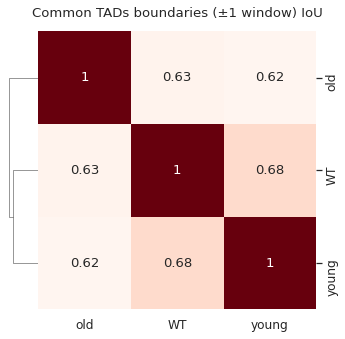

In [155]:
sns.set_theme(font_scale=1.1)

ax = sns.clustermap(IoU, annot=True, cmap='Reds',
               xticklabels=LBLS[1:], yticklabels=LBLS[1:],
               row_cluster=True, col_cluster=True, 
               dendrogram_ratio=0.1,
               figsize=(5,5))
ax.ax_heatmap.set_title('Common TADs boundaries (±%d window) IoU' % w, y=1.03)
ax.ax_col_dendrogram.set_visible(False)
ax.cax.set_visible(False)
plt.savefig('figs/TADS_IoU.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

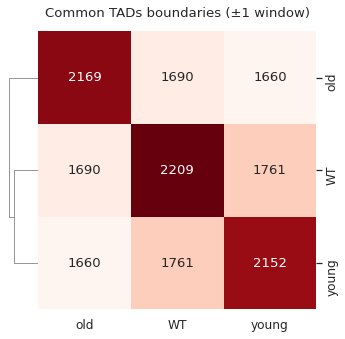

In [156]:
sns.set_theme(font_scale=1.1)

ax = sns.clustermap(intersections, annot=True, cmap='Reds',
               xticklabels=LBLS[1:], yticklabels=LBLS[1:],
               row_cluster=True, col_cluster=True, 
               dendrogram_ratio=0.1, fmt='.0f',
               figsize=(5,5))
ax.ax_heatmap.set_title('Common TADs boundaries (±%d window)' % w, y=1.03)
ax.ax_col_dendrogram.set_visible(False)
ax.cax.set_visible(False)
plt.savefig('figs/TADS_counts.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

<img src="https://i.pinimg.com/originals/14/51/41/1451410e53dba222010cc77bf14a4ef1.jpg"  width=40% height=40%>

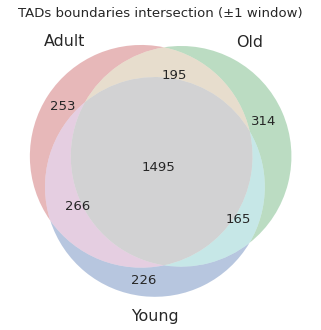

In [157]:
from matplotlib_venn import venn2, venn3
# (100, 010, 110, 001, 101, 011, 111)
intersections = intersections.astype(int)
n_set_list = [intersections[0,0] - intersections[0,1] - intersections[0,2] + common,
              intersections[1,1] - intersections[1,0] - intersections[1,2] + common,
              intersections[0,1] - common,
              intersections[2,2] - intersections[0,2] - intersections[1,2] + common,
              intersections[0,2] - common,
              intersections[1,2] - common,
              common,
             ]

# Use the venn2 function
plt.figure(figsize=(5.5, 5.5))
venn3(n_set_list, set_labels=['Adult', 'Old', 'Young'])
plt.title('TADs boundaries intersection (±1 window)')
plt.savefig('figs/TADS_Venn.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

In [158]:
# tad_ids = {}
# for k in names:
#     tad_ids[k] = set(['%s_%d_%d' % (c, t[0], t[1]) for c in chroms[:-1] for t in TADS[k][c]])

# # Use the venn2 function
# plt.figure(figsize=(5.5, 5.5))
# venn3(tad_ids.values(), set_labels=LBLS[1:])
# plt.title('TADs boundaries intersection (±0 window)')
# plt.savefig('figs/TADS_Venn.pdf', dpi=300, bbox_inches='tight', format='pdf')
# plt.show()

# Loops

In [4]:
import os
#Run loops finding
min_dist = 50_000
max_dist = 3_500_000
pearson = 0.45
for clr in tqdm(CLRS):    
    cool = clr.filename
    prefix = LOOP_PATH + '/' + splitext(basename(cool))[0]
    command = f"chromosight detect --threads 24 \
        --min-dist {min_dist} --max-dist {max_dist} --pearson {pearson} \
        {cool} {prefix}"
    os.system(command)


  0%|                                                               | 0/4 [00:00<?, ?it/s]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Found 243089 / 272564 detectable bins
Sub matrices extracted



 [--------------------] 0.0% chr1-chr1
 [=-------------------] 4.8% chr2-chr2
 [==------------------] 9.5% chr3-chr3
 [===-----------------] 14.3% chr4-chr4
 [====----------------] 19.0% chr5-chr5
 [=====---------------] 23.8% chr6-chr6
 [======--------------] 28.6% chr7-chr7
 [=======-------------] 33.3% chr8-chr8
 [========------------] 38.1% chr9-chr9
 [=========-----------] 42.9% chr10-chr10
 [==========----------] 47.6% chr11-chr11
 [==========----------] 52.4% chr12-chr12
 [===========---------] 57.1% chr13-chr13
 [============--------] 61.9% chr14-chr14
 [=============-------] 66.7% chr15-chr15
 [==============------] 71.4% chr16-chr16
 [===============-----] 76.2% chr17-chr17
 [================----] 81.0% chr18-chr18
 [=================---] 85.7% chr19-chr19
 [==================--] 90.5% chrX-chrX
 [===================-] 95.2% chrY-chrY
 [====================] 100.0% Kernel: 0, Iteration: 0


Minimum pattern separation is : 1


5221 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_10000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_10000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_KO_down_10000.pdf
 25%|█████████████▊                                         | 1/4 [00:56<02:48, 56.20s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Found 243245 / 272564 detectable bins
Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0
5833 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_10000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_10000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_WT_down_10000.pdf


Minimum pattern separation is : 1


 50%|███████████████████████████▌                           | 2/4 [01:52<01:52, 56.48s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Found 245841 / 272564 detectable bins
Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0
6591 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_10000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_10000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_old_down_10000.pdf


Minimum pattern separation is : 1


 75%|█████████████████████████████████████████▎             | 3/4 [02:47<00:55, 55.41s/it]min_separation set to 5000 based on config file.
max_perc_undetected set to 50.0 based on config file.
max_perc_zero set to 10.0 based on config file.
Matrix already balanced, reusing weights
Preprocessing sub-matrices...
 [====================] 100.0% chrY-chrY[K[K
Detecting patterns...
 [--------------------] 0.0% Kernel: 0, Iteration: 0


Found 243398 / 272564 detectable bins
Sub matrices extracted


 [====================] 100.0% Kernel: 0, Iteration: 0
6139 patterns detected
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_10000.tsv
Saving patterns in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_10000.json
Saving pileup plots in /tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_10000.pdf


Minimum pattern separation is : 1


100%|███████████████████████████████████████████████████████| 4/4 [03:43<00:00, 55.79s/it]


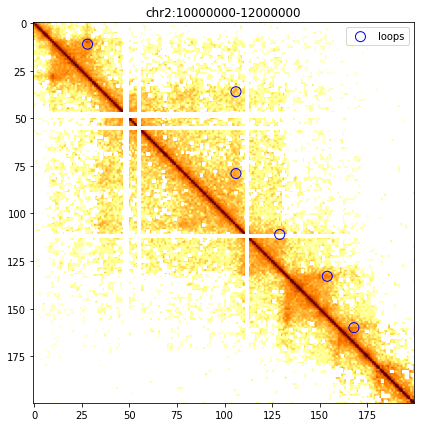

In [6]:
#look at them
import re
import json
import numpy as np
import pandas as pd
import cooler
import matplotlib.pyplot as plt
import chromosight.utils.detection as cud

loops = pd.read_csv('/tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_10000.tsv', sep='\t')
c = cooler.Cooler("/tank/projects/kriukov_chromatin/HIC/downsampled/merged/combined_young_down_10000.cool")

def subset_region(df, region):
    """
    Given a pattern dataframe and UCSC region string, retrieve only patterns in that region.
    """
    # Split the region string at each occurence of - or : (yields 3 elements)
    chrom, start, end = re.split('[-:]', region)
    start, end = int(start), int(end)
    # Only keep patterns on the same chromosome as the region and
    # within the start-end interval
    subset = df.loc[
        (df.chrom1 == chrom) &
        (df.chrom2 == chrom) &
        (df.start1 >= start) &
        (df.start2 >= start) &
        (df.end1 < end) &
        (df.end2 < end), :
    ]
    return subset

# Select a region of interest

start = 10_000_000
#region = 'chr2:%d-%d' % (start, start + 3000000)
region = 'chr2:%d-%d' % (start, start + 2_000_000)
mat = c.matrix(sparse=False, balance=True).fetch(region)


loops_sub = subset_region(loops, region)
#borders_sub = subset_region(borders, region)
#hairpins_sub = subset_region(hairpins, region)

# Make genome-based bin numbers relative to the region
for df in [loops_sub]:#, borders_sub, hairpins_sub]:
    df.bin1 -= c.extent(region)[0]
    df.bin2 -= c.extent(region)[0]

plt.figure(figsize=(7, 7))
plt.imshow(np.log10(mat), cmap='afmhot_r')
plt.title(region)
plt.scatter(loops_sub.bin2, loops_sub.bin1, edgecolors='blue', facecolors='none', label='loops', s=100)
#plt.scatter(borders_sub.bin2, borders_sub.bin1, c='lightblue', label='borders')
#plt.scatter(hairpins_sub.bin2, hairpins_sub.bin1, c='green', label='hairpins')
plt.legend()
plt.savefig('./figs/loops_example.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
#(loops['start2'] - loops['start1']).hist()

In [9]:
!ls /tank/projects/kriukov_chromatin/HIC/loops/

combined_KO_down_10000.json  combined_old_down_10000.json
combined_KO_down_10000.pdf   combined_old_down_10000.pdf
combined_KO_down_10000.tsv   combined_old_down_10000.tsv
combined_KO_down_50000.json  combined_old_down_50000.json
combined_KO_down_50000.pdf   combined_old_down_50000.pdf
combined_KO_down_50000.tsv   combined_old_down_50000.tsv
combined_WT_down_10000.json  combined_young_down_10000.json
combined_WT_down_10000.pdf   combined_young_down_10000.pdf
combined_WT_down_10000.tsv   combined_young_down_10000.tsv
combined_WT_down_50000.json  combined_young_down_50000.json
combined_WT_down_50000.pdf   combined_young_down_50000.pdf
combined_WT_down_50000.tsv   combined_young_down_50000.tsv


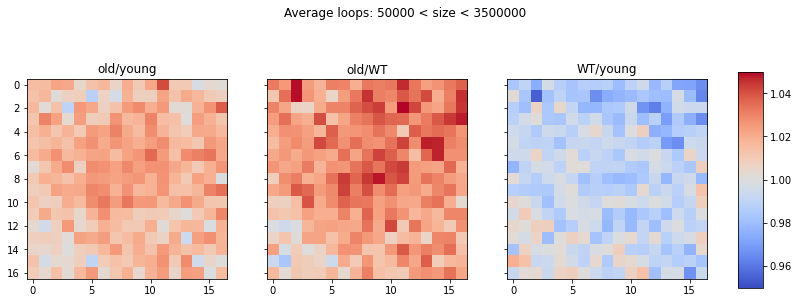

In [11]:
#compare between conditions
min_dist = 50_000
max_dist = 3_500_000
LOOPS_WIN_FILES = glob('/tank/projects/kriukov_chromatin/HIC/loops/*_10000.json')

average_loops = {}
for loop_file in LOOPS_WIN_FILES:
    # Load input json file into a dictionary
    loop_wins = json.load(open(loop_file, 'r'))
    # Note that keys are string, as required by the JSON format,
    # so we convert them to int() for convenience
    loop_wins = {int(i): np.array(w) for i, w in loop_wins.items()}
    # Make an empty 3D array of shape N_coords x height x width
    wins = np.zeros((len(loop_wins.items()), *loop_wins[0].shape))
    # Fill the 3D array with windows values
    for i, w in loop_wins.items(): 
        wins[i] = w
    pileup = cud.pileup_patterns(wins)
    name = splitext(basename(loop_file))[0].split('_')[1]
    average_loops[name] = pileup


#pairs = [['KO', 'young'], ['KO', 'WT'], ['KO', 'old'], ['old', 'young'], ['old', 'WT'], ['WT', 'young']]
pairs = [['old', 'young'], ['old', 'WT'], ['WT', 'young']]
fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharex=True, sharey=True)
fig.suptitle(f'Average loops: {min_dist} < size < {max_dist}')

for pair, ax in zip(pairs, axes.flatten()):
    divv = average_loops[pair[0]] / average_loops[pair[1]]
    img = ax.imshow(divv, cmap='coolwarm', vmax=1.05, vmin=0.95)
    ax.set_title(f'{pair[0]}/{pair[1]}')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.2, 0.025, 0.6])
fig.colorbar(img, cax=cbar_ax)
# if len(pairs) % 2 != 0: #remove redundant axis
#     axes.flatten()[-1].set_axis_off()
    
plt.savefig(f'./figs/loops_avg_changes_{min_dist}<size<{max_dist}_res=10000.pdf', 
            format='pdf', dpi=300, bbox_inches='tight')
plt.show()



# ATAC-seq peaks

In [9]:
!ls /tank/projects/kriukov_chromatin/ATAC

consensus_peaks.mLb.clN.boolean.annotatePeaks.txt  macs


In [10]:
peaks = ATAC[['interval_id', 'chr', 'start', 'end', 'num_peaks', 'num_samples',
            #'KO_R1.mLb.clN.bool', 'KO_R2.mLb.clN.bool', 'KO_R3.mLb.clN.bool',
            'WT_R1.mLb.clN.bool', 'WT_R2.mLb.clN.bool', 'WT_R3.mLb.clN.bool',
            'old_R1.mLb.clN.bool', 'old_R2.mLb.clN.bool', 'old_R3.mLb.clN.bool',
            'young_R1.mLb.clN.bool', 'young_R2.mLb.clN.bool', 'young_R3.mLb.clN.bool',
            'Distance to TSS','Gene Name']].copy()
peaks.columns = ['interval_id', 'chr', 'start', 'end', 'num_peaks', 'num_samples',
                'WT_R1', 'WT_R2', 'WT_R3',
                'old_R1', 'old_R2', 'old_R3',
                'young_R1', 'young_R2', 'young_R3',
                'Distance to TSS','Gene Name']
peaks['length'] = ATAC['end'] - ATAC['start']
peaks['absTSS'] = np.abs(peaks['Distance to TSS'])


In [11]:
sum(peaks['absTSS'] < 500)

8383

In [42]:
# ATAC[['chr', 'start', 'end', 'num_peaks', 'num_samples',
#        'KO_R1.mLb.clN.fc', 'KO_R1.mLb.clN.pval', 'KO_R1.mLb.clN.qval', 'KO_R1.mLb.clN.start']]

## peaks near DE genes and enrichment analysis

In [61]:
de_genes = sc_neur[(sc_neur.qval < 0.05) & (np.abs(sc_neur.log2fc) > np.log2(1.1))] #10%
de_genes

gene          pval          qval    log2fc      mean  zero_mean  \
6        Oprk1  2.020002e-04  8.551538e-03  0.839636  0.056232      False   
69        Phf3  1.902467e-03  4.026981e-02 -0.263171  0.319923      False   
98      Actr1b  1.612672e-03  3.616530e-02  0.226389  0.409239      False   
112      Eif5b  6.312266e-07  9.298355e-05 -0.300844  0.582026      False   
131     Pantr1  1.545614e-03  3.542618e-02  0.395667  0.162079      False   
...        ...           ...           ...       ...       ...        ...   
14599      Psd  2.083847e-08  5.098715e-06  0.347139  0.556083      False   
14623     Sfr1  1.765386e-03  3.809435e-02 -0.226529  0.414799      False   
14636     Smc3  1.240932e-03  3.093971e-02 -0.238473  0.434428      False   
14686  mt-Atp8  7.603137e-10  2.613307e-07 -0.652714  0.238398      False   
14697     PISD  2.927701e-41  5.283037e-38 -0.514795  1.189392      False   

       zero_variance  
6              False  
69             False  
98             False  
112            False  
131            False  
...              ...  
14599          False  
14623          False  
14636          False  
14686          False  
14697          False  

[676 rows x 7 columns]

In [62]:
a = peaks.filter(regex='young|WT|old').sum(0)
print(a[0:3].mean(), a[3:6].mean(), a[6:9].mean())


31558.0 27825.333333333332 22042.333333333332


In [63]:
dpeaks = peaks[peaks['Gene Name'].isin(de_genes.gene) & (np.abs(peaks['Distance to TSS']) < 1500)]

In [64]:
#some stat
(dpeaks.filter(regex='young').sum(1).mean(), 
 dpeaks.filter(regex='WT').sum(1).mean(),
dpeaks.filter(regex='old').sum(1).mean())

(2.0575539568345325, 2.2949640287769784, 1.8848920863309353)

In [65]:
#some other stat - seems like batch effect is presented
b = dpeaks.filter(regex='young|WT|old').sum(0)
b[0:3].mean(), b[3:6].mean(), b[6:9].mean()

(319.0, 262.0, 286.0)

In [67]:
b/a * 100

WT_R1       0.943370
WT_R2       0.913811
WT_R3       1.244695
old_R1      0.846987
old_R2      0.783794
old_R3      1.276486
young_R1    1.351476
young_R2    1.107103
young_R3    1.551429
dtype: float64

In [68]:
dpeaks_up = dpeaks[dpeaks.log2fc > 0]
dpeaks_dw = dpeaks[dpeaks.log2fc < 0]

c = dpeaks_up.filter(regex='young|WT|old').sum(0)
c / a * 10000 / dpeaks_up.shape[0]

AttributeError: 'DataFrame' object has no attribute 'log2fc'

In [69]:
d = dpeaks_dw.filter(regex='young|WT|old').sum(0)
d / a * 10000 / dpeaks_dw.shape[0]

NameError: name 'dpeaks_dw' is not defined

In [70]:
dpeaks['ndiff'] = dpeaks.filter(regex='old').sum(1) - dpeaks.filter(regex='young').sum(1)
dpeaks['ndiff_control_WY'] = dpeaks.filter(regex='WT').sum(1) - dpeaks.filter(regex='young').sum(1)
dpeaks['ndiff_control_OW'] = dpeaks.filter(regex='old').sum(1) - dpeaks.filter(regex='WT').sum(1)

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [84]:
dpeaks['start']

0        5588315
1       36709333
2       42693464
3       58921538
4       66386725
         ...    
412    136203084
413    136215014
414    136992516
415    159459834
416    166344350
Name: start, Length: 417, dtype: int64

In [71]:
#correlation between peaks change value and FC
dpeaks = dpeaks.merge(de_genes, left_on='Gene Name', right_on='gene')
dpeaks[['ndiff', 'ndiff_control_WY', 'ndiff_control_OW', 'log2fc']].corr(method='spearman')

ndiff  ndiff_control_WY  ndiff_control_OW    log2fc
ndiff             1.000000          0.327812          0.628891  0.112379
ndiff_control_WY  0.327812          1.000000         -0.451990  0.056279
ndiff_control_OW  0.628891         -0.451990          1.000000  0.073874
log2fc            0.112379          0.056279          0.073874  1.000000

In [77]:
dpeaks[np.abs(dpeaks.ndiff) > 1].head()

interval_id chr      start        end  num_peaks  num_samples  WT_R1  \
7   Interval_2167   1   77514578   77515767          8            8   True   
17  Interval_3476   1  133045395  133046664          5            5   True   
19  Interval_4259   1  158362678  158363179          3            3  False   
21  Interval_4638   1  167598273  167598924          4            4   True   
32  Interval_7448  10   67911786   67912817         10           10   True   

    WT_R2  WT_R3  old_R1  old_R2  old_R3  young_R1  young_R2  young_R3  \
7   False   True    True   False   False      True      True      True   
17  False  False   False   False   False      True      True     False   
19  False  False   False   False   False      True      True     False   
21  False  False    True   False    True     False     False     False   
32   True   True   False   False    True      True      True      True   

    Distance to TSS Gene Name  length  absTSS  ndiff  ndiff_control_WY  \
7               -94     Epha4    1189      94     -2                -1   
17              363   Pik3c2b    1269     363     -2                -1   
19              379     Astn1     501     379     -2                -2   
21              139      Rxrg     651     139      2                 1   
32              133    Zfp365    1031     133     -2                 0   

    ndiff_control_OW     gene      pval      qval    log2fc      mean  \
7                 -1    Epha4  0.000536  0.017220  0.272118  0.395745   
17                -1  Pik3c2b  0.002241  0.044996 -0.681004  0.054523   
19                 0    Astn1  0.000215  0.008931  0.245617  0.490043   
21                 1     Rxrg  0.001493  0.034845  0.675658  0.062559   
32                -2   Zfp365  0.000280  0.010868  0.333842  0.266788   

    zero_mean  zero_variance  
7       False          False  
17      False          False  
19      False          False  
21      False          False  
32      False          False

In [72]:
#test gset
#gset = dpeaks[np.abs(dpeaks.ndiff) > 0]['Gene Name'].tolist()
#gset = dpeaks[(np.abs(dpeaks.ndiff) > 0) & (dpeaks.log2fc > 0)]['Gene Name'].tolist() #upreg

#gset = dpeaks[(dpeaks.ndiff > 0) & (dpeaks.log2fc > 0)]['Gene Name'].tolist() #up_open
#gset = dpeaks[(dpeaks.ndiff == 0) & (dpeaks.log2fc < 0)]['Gene Name'].tolist() #dw_closed

len(gset)

98

In [73]:
import gseapy as gp
from gseapy.parser import gsea_gmt_parser   

In [74]:
universe_test = sc_neur[sc_neur['mean'] >= dpeaks['mean'].min()].gene.tolist()
len(universe_test)

12226

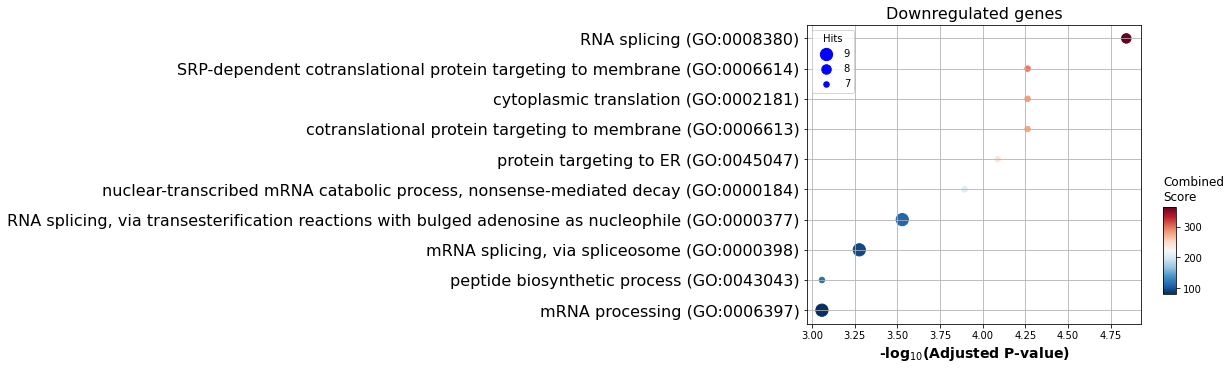

In [78]:
gene_sets=['GO_Biological_Process_2021', ]
           #'KEGG_2019_Mouse', 'Reactome_2016', 'MSigDB_Hallmark_2020']
            #'Aging_Perturbations_from_GEO_up', 'Aging_Perturbations_from_GEO_down']   

gset = dpeaks[(np.abs(dpeaks.ndiff) > 0) & (dpeaks.log2fc < 0)]['Gene Name'].tolist() #dwreg
enr = gp.enrichr(gene_list=gset,
                gene_sets=gene_sets,
                organism='Mouse', 
                description='test_run',
                #outdir='tmp/enrichment/%s' % name,
                cutoff=0.05, # test dataset, use lower value from range(0,1)
                background=universe_test,
                no_plot=True
                )
eres = enr.results    

ax = gp.plot.dotplot(eres)
ax.set_title('Downregulated genes', fontsize=16)
plt.savefig('./figs/peaks_enrichment_dw_genes.pdf', dpi=300, bbox_inches='tight')

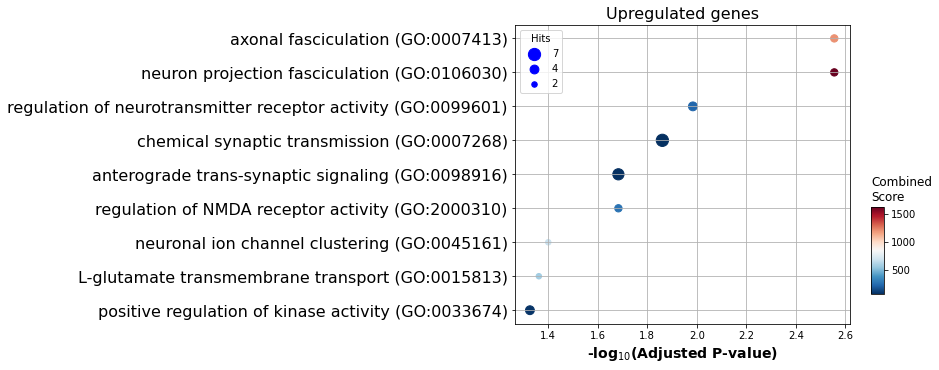

In [79]:
gene_sets=['GO_Biological_Process_2021', ]
           #'KEGG_2019_Mouse', 'Reactome_2016', 'MSigDB_Hallmark_2020']
            #'Aging_Perturbations_from_GEO_up', 'Aging_Perturbations_from_GEO_down']   

gset = dpeaks[(np.abs(dpeaks.ndiff) > 0) & (dpeaks.log2fc > 0)]['Gene Name'].tolist() #dwreg
enr = gp.enrichr(gene_list=gset,
                gene_sets=gene_sets,
                organism='Mouse', 
                description='test_run',
                #outdir='tmp/enrichment/%s' % name,
                cutoff=0.05, # test dataset, use lower value from range(0,1)
                background=universe_test,
                no_plot=True
                )
eres = enr.results    

ax = gp.plot.dotplot(eres)
ax.set_title('Upregulated genes', fontsize=16)
plt.savefig('./figs/peaks_enrichment_up_genes.pdf', dpi=300, bbox_inches='tight')

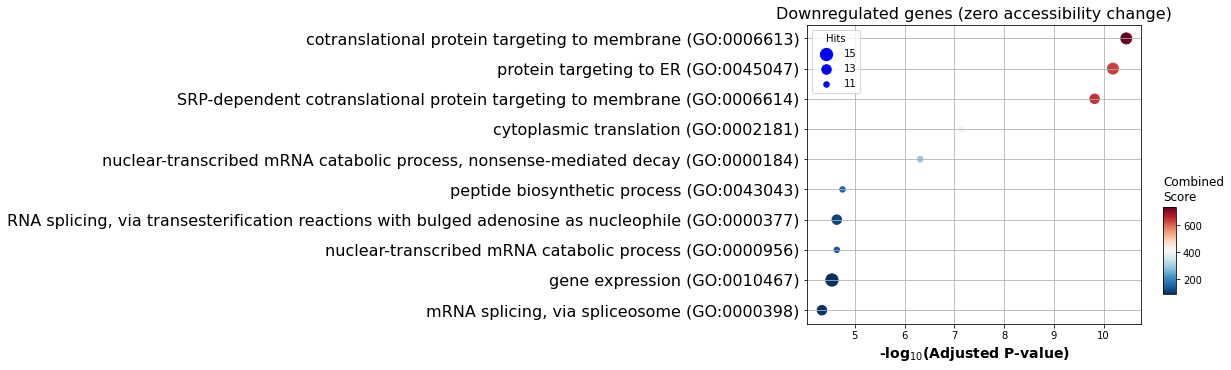

In [80]:
gene_sets=['GO_Biological_Process_2021', ]
           #'KEGG_2019_Mouse', 'Reactome_2016', 'MSigDB_Hallmark_2020']
            #'Aging_Perturbations_from_GEO_up', 'Aging_Perturbations_from_GEO_down']   

gset = dpeaks[(np.abs(dpeaks.ndiff) == 0) & (dpeaks.log2fc < 0)]['Gene Name'].tolist() #dwreg
enr = gp.enrichr(gene_list=gset,
                gene_sets=gene_sets,
                organism='Mouse', 
                description='test_run',
                #outdir='tmp/enrichment/%s' % name,
                cutoff=0.05, # test dataset, use lower value from range(0,1)
                background=universe_test,
                no_plot=True
                )
eres = enr.results    

ax = gp.plot.dotplot(eres)
ax.set_title('Downregulated genes (zero accessibility change)', fontsize=16)
plt.savefig('./figs/peaks_zero_enrichment_dw_genes.pdf', dpi=300, bbox_inches='tight')

In [82]:
gene_sets=['GO_Biological_Process_2021', ]
           #'KEGG_2019_Mouse', 'Reactome_2016', 'MSigDB_Hallmark_2020']
            #'Aging_Perturbations_from_GEO_up', 'Aging_Perturbations_from_GEO_down']   

gset = dpeaks[(np.abs(dpeaks.ndiff) == 0) & (dpeaks.log2fc > 0)]['Gene Name'].tolist() #dwreg
enr = gp.enrichr(gene_list=gset,
                gene_sets=gene_sets,
                organism='Mouse', 
                description='test_run',
                #outdir='tmp/enrichment/%s' % name,
                cutoff=0.05, # test dataset, use lower value from range(0,1)
                background=universe_test,
                no_plot=True
                )
eres = enr.results    

ax = gp.plot.dotplot(eres)
ax.set_title('Upregulated genes (zero accessibility change)', fontsize=16)
plt.savefig('./figs/peaks_zero_enrichment_up_genes.pdf', dpi=300, bbox_inches='tight')

AttributeError: 'str' object has no attribute 'set_title'

## ATAC-seq peaks intersection

In [60]:
peak_intersection_list = sorted(glob('subdata/ATAC_peak_intersection/*TSS1000.csv'))
p = [i for i in peak_intersection_list if 'AND(O) not OR(Y)' in i][0]

tmp = pd.read_csv(p, sep='\t', index_col=0)
tmp = tmp.merge(peaks, left_index=True, right_index=True)
tmp.head(3)

Distance to TSS_x  Nearest PromoterID           Entrez ID  \
958                 202  ENSMUSG00000089767  ENSMUSG00000089767   
1664                684  ENSMUSG00000103131  ENSMUSG00000103131   
2087                -91  ENSMUSG00000089964  ENSMUSG00000089964   

         Nearest Unigene    Gene Name_x             Gene Type    interval_id  \
958   ENSMUST00000160659  4930556I23Rik             antisense   Interval_959   
1664  ENSMUST00000193096        Gm37977                   TEC  Interval_1665   
2087  ENSMUST00000159627        Gm16582  processed_transcript  Interval_2088   

     chr     start       end  num_peaks  num_samples  WT_R1  WT_R2  WT_R3  \
958    1  37613728  37615194          5            5   True   True  False   
1664   1  59886617  59887392          5            5   True  False  False   
2087   1  74850221  74851386          5            5   True  False  False   

      old_R1  old_R2  old_R3  young_R1  young_R2  young_R3  Distance to TSS_y  \
958     True    True    True     False     False     False                202   
1664    True    True    True     False     False     False                684   
2087    True    True    True     False     False     False                -91   

        Gene Name_y  length  absTSS  ndiff  
958   4930556I23Rik    1466     202      3  
1664        Gm37977     775     684      3  
2087        Gm16582    1165      91      3

In [142]:
tmp.columns

Index(['Distance to TSS_x', 'Nearest PromoterID', 'Entrez ID',
       'Nearest Unigene', 'Gene Name_x', 'Gene Type', 'chr', 'start', 'end',
       'num_peaks', 'num_samples', 'WT_R1.mLb.clN.bool', 'WT_R2.mLb.clN.bool',
       'WT_R3.mLb.clN.bool', 'old_R1.mLb.clN.bool', 'old_R2.mLb.clN.bool',
       'old_R3.mLb.clN.bool', 'young_R1.mLb.clN.bool', 'young_R2.mLb.clN.bool',
       'young_R3.mLb.clN.bool', 'Distance to TSS_y', 'Gene Name_y', 'length',
       'absTSS'],
      dtype='object')

In [143]:
# peaks in loops

loops = pd.read_csv('/tank/projects/kriukov_chromatin/HIC/loops/combined_young_down_10000.tsv', sep='\t')

loops_x_diffpeaks_L = bins_to_genes_intersection(loops[['chrom1', 'start1', 'end1']],
                                               tmp,  
                                               genes_cols=['chr', 'start', 'end'])
loops_x_diffpeaks_R = bins_to_genes_intersection(loops[['chrom2', 'start2', 'end2']],
                                               tmp,  
                                               genes_cols=['chr', 'start', 'end'])

loops_x_diffpeaks = pd.concat([loops_x_diffpeaks_L, loops_x_diffpeaks_R])
loops_x_diffpeaks

chrom1     start1       end1 chrom2     start2       end2    bin1  \
0      chr1    4530000    4540000   chr1    4750000    4760000     453   
1      chr1    5920000    5930000   chr1    6140000    6150000     592   
2      chr1    7010000    7020000   chr1    7200000    7210000     701   
3      chr1    9580000    9590000   chr1    9690000    9700000     958   
4      chr1    9760000    9770000   chr1   10000000   10010000     976   
...     ...        ...        ...    ...        ...        ...     ...   
6134   chrX  163970000  163980000   chrX  164050000  164060000  262682   
6135   chrX  164100000  164110000   chrX  164160000  164170000  262695   
6136   chrX  166430000  166440000   chrX  166640000  166650000  262928   
6137   chrX  166690000  166700000   chrX  166790000  166800000  262954   
6138   chrX  167280000  167290000   chrX  167350000  167360000  263013   

        bin2  kernel_id  iteration     score  pvalue  qvalue  
0        475          0          0  0.466533     0.0     0.0  
1        614          0          0  0.644382     0.0     0.0  
2        720          0          0  0.669760     0.0     0.0  
3        969          0          0  0.746666     0.0     0.0  
4       1000          0          0  0.488938     0.0     0.0  
...      ...        ...        ...       ...     ...     ...  
6134  262690          0          0  0.467253     0.0     0.0  
6135  262701          0          0  0.477237     0.0     0.0  
6136  262949          0          0  0.482511     0.0     0.0  
6137  262964          0          0  0.514665     0.0     0.0  
6138  263020          0          0  0.460949     0.0     0.0  

[6139 rows x 13 columns]

In [145]:
#peaks in loops in DE genes
sc_neur[sc_neur.gene.isin(loops_x_diffpeaks['Gene Name_x'])].sort_values('pval')

gene      pval      qval    log2fc      mean  zero_mean  \
8415       Usp10  0.029761  0.224110 -0.313862  0.116318      False   
172       Dnah7a  0.080641  0.369801 -0.589020  0.024357      False   
11982    Fam181a  0.106933  0.424331  1.963124  0.002121      False   
14234     Mrpl11  0.122456  0.449931 -0.126293  0.327218      False   
5247       Lrrc4  0.686362  0.893285  0.051334  0.147378      False   
13282  Rab11fip3  0.689947  0.893919 -0.060446  0.111229      False   
2624      Actl6a  0.880955  0.962715  0.017365  0.183183      False   
8614      Mustn1  0.882909  0.963916 -0.092095  0.006522      False   
13032    Adamts1  0.892700  0.966116  0.092162  0.004610      False   
14643     Gucy2g  0.911393  0.972295 -0.034717  0.029633      False   

       zero_variance  
8415           False  
172            False  
11982          False  
14234          False  
5247           False  
13282          False  
2624           False  
8614           False  
13032          False  
14643          False

In [125]:
pbulk_neur.loc[pbulk_neur.index.isin(loops_x_diffpeaks['Gene Name_x'])]

mean        FC        SE      stat      pval      padj  \
Hsd17b12    57.686339  0.145430  0.098743  1.471268  0.141219  0.478663   
Actl6a      41.303906  0.002348  0.121701  0.019311  0.984593       NaN   
Psmd4      146.163640  0.079518  0.081098  0.980604  0.326788  0.668349   
Dnajc6      97.771218 -0.093709  0.099599 -0.940364  0.347031  0.683501   
Ubc        476.411982 -0.038233  0.108150 -0.353600  0.723639  0.896807   
Lrrc4       35.695315  0.054435  0.120479  0.451108  0.651912       NaN   
Tigd2       36.991588  0.219187  0.119529  1.830612  0.067158       NaN   
Bms1        14.517910 -0.097012  0.138754 -0.697940  0.485214       NaN   
Aig1       188.602831  0.243163  0.094466  2.573918  0.010055  0.182327   
Pcbp3      204.519766  0.054833  0.119222  0.460082  0.645457  0.854629   
Usp10       27.684858  0.149563  0.123204  1.212320  0.225390       NaN   
Rhbdl3      13.002206 -0.038908  0.140904 -0.277962  0.781042       NaN   
Gmpr        56.344581 -0.122624  0.132306 -0.925486  0.354713  0.689985   
Immp2l      11.519162  0.115560  0.140919  0.817123  0.413858       NaN   
Bcl11b     195.333568 -0.063875  0.089371 -0.714824  0.474718  0.762075   
Ankrd33b    51.603977  0.087313  0.122998  0.709714  0.477882  0.762869   
Rab11fip3   24.122824  0.078997  0.135970  0.578944  0.562627       NaN   
Mrpl11      88.312256  0.072306  0.097041  0.744372  0.456651  0.751291   

                 ES  
Hsd17b12   0.123631  
Actl6a     0.000016  
Psmd4      0.038624  
Dnajc6    -0.043072  
Ubc       -0.005371  
Lrrc4      0.010115  
Tigd2      0.257084  
Bms1      -0.030468  
Aig1       0.485743  
Pcbp3      0.010426  
Usp10      0.096777  
Rhbdl3    -0.004176  
Gmpr      -0.055196  
Immp2l     0.044277  
Bcl11b    -0.020668  
Ankrd33b   0.027999  
Rab11fip3  0.019732  
Mrpl11     0.024614

## peaks DE score

In [22]:
ndiffpeaks = peaks.filter(regex='old').sum(1) - peaks.filter(regex='young').sum(1)
peaks['ndiff'] = ndiffpeaks

In [23]:
peaks

interval_id chr     start       end  num_peaks  num_samples  WT_R1  \
0          Interval_1   1   3094953   3095639          7            7   True   
1          Interval_2   1   3119552   3120933         12           12   True   
2          Interval_3   1   3195033   3195525          1            1   True   
3          Interval_4   1   3292392   3293460          7            7   True   
4          Interval_5   1   3297635   3298319          2            2  False   
...               ...  ..       ...       ...        ...          ...    ...   
68289  Interval_68290   Y  90800452  90800758          1            1  False   
68290  Interval_68291   Y  90804811  90805245          5            5   True   
68291  Interval_68292   Y  90807111  90807842          3            3  False   
68292  Interval_68293   Y  90808445  90809289          3            3  False   
68293  Interval_68294   Y  90810652  90811000          1            1  False   

       WT_R2  WT_R3  old_R1  old_R2  old_R3  young_R1  young_R2  young_R3  \
0       True  False    True    True    True     False      True     False   
1       True   True    True    True    True      True      True      True   
2      False  False   False   False   False     False     False     False   
3       True  False    True    True   False      True      True     False   
4      False  False   False   False    True     False     False     False   
...      ...    ...     ...     ...     ...       ...       ...       ...   
68289  False   True   False   False   False     False     False     False   
68290  False  False   False    True   False     False     False      True   
68291   True  False   False    True   False      True     False     False   
68292  False   True    True    True   False     False     False     False   
68293  False  False   False   False   False      True     False     False   

       Distance to TSS Gene Name  length  absTSS  ndiff  
0                -6720   Gm26206     686    6720      2  
1                18227   Gm26206    1381   18227      0  
2                21065      Xkr4     492   21065      0  
3                40169   Gm18956    1068   40169      0  
4                45220   Gm18956     684   45220      1  
...                ...       ...     ...     ...    ...  
68289            15867     Erdr1     306   15867      0  
68290            20290     Erdr1     434   20290      0  
68291            22739     Erdr1     731   22739      0  
68292            24129     Erdr1     844   24129      2  
68293            26088     Erdr1     348   26088     -1  

[68294 rows x 20 columns]

In [24]:
IS_x_peaks = bins_to_genes_intersection(IS[['chrom', 'start', 'end']],
                            peaks,  
                            genes_cols=['chr', 'start', 'end'])

IS_x_peaks = IS_x_peaks.merge(IS, left_on=['Chromosome', 'Start_b', 'End_b'], 
                                  right_on=['chrom', 'start', 'end']).dropna(axis=0)

IS_x_peaks

Chromosome      Start        End    Start_b      End_b     interval_id  \
22          chr1    3517729    3518088    3500000    3550000     Interval_21   
23          chr1    3609895    3610187    3600000    3650000     Interval_22   
24          chr1    3611195    3611813    3600000    3650000     Interval_23   
25          chr1    3662482    3662788    3650000    3700000     Interval_24   
26          chr1    3671505    3672497    3650000    3700000     Interval_25   
...          ...        ...        ...        ...        ...             ...   
69248       chrX  168698168  168698503  168650000  168700000  Interval_68267   
69249       chrX  168975418  168976223  168950000  169000000  Interval_68268   
69250       chrX  169036652  169036979  169000000  169050000  Interval_68269   
69251       chrX  169064498  169065369  169050000  169100000  Interval_68270   
69252       chrX  169319936  169320760  169300000  169350000  Interval_68271   

       num_peaks  num_samples  WT_R1  WT_R2  WT_R3  old_R1  old_R2  old_R3  \
22             1            1  False  False  False   False   False   False   
23             1            1  False  False  False   False   False   False   
24             3            3  False   True  False    True   False   False   
25             1            1  False   True  False   False   False   False   
26            12           12   True   True   True    True    True    True   
...          ...          ...    ...    ...    ...     ...     ...     ...   
69248          1            1  False  False  False   False    True   False   
69249          9            9   True   True   True    True    True    True   
69250          1            1  False  False  False   False   False    True   
69251          9            9   True   True   True    True    True    True   
69252         12           12   True   True   True    True    True    True   

       young_R1  young_R2  young_R3  Distance to TSS Gene Name  length  \
22        False     False     False            -3402   Gm37329     359   
23        False     False     False           -14138   Gm38148     292   
24        False     False     False           -15601   Gm38148     618   
25        False     False     False            -3731   Gm19938     306   
26         True      True      True            -8154   Gm10568     992   
...         ...       ...       ...              ...       ...     ...   
69248     False     False     False           -39318      Msl3     335   
69249      True      True     False           -60790   Arhgap6     805   
69250     False     False     False              205   Arhgap6     327   
69251     False     False      True            28323   Arhgap6     871   
69252      True      True      True               24      Hccs     824   

       absTSS  ndiff  index  combined_KO_down_50000  combined_WT_down_50000  \
22       3402      0     70                0.405451                0.414245   
23      14138      0     72                0.177760                0.195857   
24      15601      1     72                0.177760                0.195857   
25       3731      0     73                0.135168                0.171611   
26       8154      0     73                0.135168                0.171611   
...       ...    ...    ...                     ...                     ...   
69248   39318      1  52637                0.002867               -0.055879   
69249   60790      1  52643                0.210841                0.252398   
69250     205      1  52644                0.218851                0.286601   
69251   28323      2  52645                0.229556                0.303966   
69252      24      0  52650               -0.175790               -0.198764   

       combined_old_down_50000  combined_young_down_50000 chrom      start  \
22                    0.467412                   0.417919  chr1    3500000   
23                    0.216581                   0.153228  chr1    3600000   
24                    0.216581      

In [25]:
IS_x_peaks[['ndiff', 
            'combined_young_down_50000', 
            'combined_WT_down_50000', 
            'combined_old_down_50000']].corr(method='spearman')

ndiff  combined_young_down_50000  \
ndiff                      1.000000                   0.063125   
combined_young_down_50000  0.063125                   1.000000   
combined_WT_down_50000     0.059838                   0.996389   
combined_old_down_50000    0.068243                   0.993660   

                           combined_WT_down_50000  combined_old_down_50000  
ndiff                                    0.059838                 0.068243  
combined_young_down_50000                0.996389                 0.993660  
combined_WT_down_50000                   1.000000                 0.988254  
combined_old_down_50000                  0.988254                 1.000000

In [26]:
IS_x_peaks['IS_O|Y'] = IS_x_peaks['combined_old_down_50000'] - IS_x_peaks['combined_young_down_50000']

In [27]:
IS_x_peaks_gr = IS_x_peaks.groupby(['Chromosome', 'Start_b', 'End_b'])['IS_O|Y', 'ndiff'].mean()
IS_x_peaks_gr.corr(method='spearman')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


IS_O|Y     ndiff
IS_O|Y  1.000000  0.075489
ndiff   0.075489  1.000000

In [123]:
IS_x_peaks_gr

IS_O|Y  ndiff
Chromosome Start_b   End_b                     
chr1       3500000   3550000    0.049493    0.0
           3600000   3650000    0.063354    0.5
           3650000   3700000    0.038403    0.0
           3900000   3950000    0.013385    1.0
           4050000   4100000    0.000826    0.0
...                                  ...    ...
chrX       168650000 168700000 -0.005378    0.5
           168950000 169000000  0.015278    1.0
           169000000 169050000  0.005100    1.0
           169050000 169100000  0.027482    2.0
           169300000 169350000 -0.026612    0.0

[27102 rows x 2 columns]

In [321]:
IS_x_peaks

Chromosome      Start        End    Start_b      End_b  num_peaks  \
22          chr1    3517729    3518088    3500000    3550000          1   
23          chr1    3609895    3610187    3600000    3650000          1   
24          chr1    3611195    3611813    3600000    3650000          3   
25          chr1    3662482    3662788    3650000    3700000          1   
26          chr1    3671505    3672497    3650000    3700000         12   
...          ...        ...        ...        ...        ...        ...   
69248       chrX  168698168  168698503  168650000  168700000          1   
69249       chrX  168975418  168976223  168950000  169000000          9   
69250       chrX  169036652  169036979  169000000  169050000          1   
69251       chrX  169064498  169065369  169050000  169100000          9   
69252       chrX  169319936  169320760  169300000  169350000         12   

       num_samples  WT_R1  WT_R2  WT_R3  old_R1  old_R2  old_R3  young_R1  \
22               1  False  False  False   False   False   False     False   
23               1  False  False  False   False   False   False     False   
24               3  False   True  False    True   False   False     False   
25               1  False   True  False   False   False   False     False   
26              12   True   True   True    True    True    True      True   
...            ...    ...    ...    ...     ...     ...     ...       ...   
69248            1  False  False  False   False    True   False     False   
69249            9   True   True   True    True    True    True      True   
69250            1  False  False  False   False   False    True     False   
69251            9   True   True   True    True    True    True     False   
69252           12   True   True   True    True    True    True      True   

       young_R2  young_R3  Distance to TSS Gene Name  length  absTSS  ndiff  \
22        False     False            -3402   Gm37329     359    3402      0   
23        False     False           -14138   Gm38148     292   14138      0   
24        False     False           -15601   Gm38148     618   15601      1   
25        False     False            -3731   Gm19938     306    3731      0   
26         True      True            -8154   Gm10568     992    8154      0   
...         ...       ...              ...       ...     ...     ...    ...   
69248     False     False           -39318      Msl3     335   39318      1   
69249      True     False           -60790   Arhgap6     805   60790      1   
69250     False     False              205   Arhgap6     327     205      1   
69251     False      True            28323   Arhgap6     871   28323      2   
69252      True      True               24      Hccs     824      24      0   

       index  combined_KO_down_50000  combined_WT_down_50000  \
22        70                0.405451                0.414245   
23        72                0.177760                0.195857   
24        72                0.177760                0.195857   
25        73                0.135168                0.171611   
26        73                0.135168                0.171611   
...      ...                     ...                     ...   
69248  52637                0.002867               -0.055879   
69249  52643                0.210841                0.252398   
69250  52644                0.218851                0.286601   
69251  52645                0.229556                0.303966   
69252  52650               -0.175790               -0.198764   

       combined_old_down_50000  combined_young_down_50000 chrom      start  \
22                    0.467412                   0.417919  chr1    3500000   
23                    0.216581                   0.153228  chr1    3600000   
24                    0.216581                   0.153228  chr1    3600000   
25                    0.168592                   0.130189  chr1    3650000   
26                    0.168592                   0.130189  chr1    36500

In [28]:
IS_x_peaks[['ndiff', 'IS_O|Y']].corr(method='spearman')

ndiff    IS_O|Y
ndiff   1.000000  0.049392
IS_O|Y  0.049392  1.000000

In [130]:
IS_x_peaks

Chromosome      Start        End    Start_b      End_b  num_peaks  \
22          chr1    3517729    3518088    3500000    3550000          1   
23          chr1    3609895    3610187    3600000    3650000          1   
24          chr1    3611195    3611813    3600000    3650000          3   
25          chr1    3662482    3662788    3650000    3700000          1   
26          chr1    3671505    3672497    3650000    3700000         12   
...          ...        ...        ...        ...        ...        ...   
69248       chrX  168698168  168698503  168650000  168700000          1   
69249       chrX  168975418  168976223  168950000  169000000          9   
69250       chrX  169036652  169036979  169000000  169050000          1   
69251       chrX  169064498  169065369  169050000  169100000          9   
69252       chrX  169319936  169320760  169300000  169350000         12   

       num_samples  WT_R1  WT_R2  WT_R3  ...  ndiff  index  \
22               1  False  False  False  ...      0     70   
23               1  False  False  False  ...      0     72   
24               3  False   True  False  ...      1     72   
25               1  False   True  False  ...      0     73   
26              12   True   True   True  ...      0     73   
...            ...    ...    ...    ...  ...    ...    ...   
69248            1  False  False  False  ...      1  52637   
69249            9   True   True   True  ...      1  52643   
69250            1  False  False  False  ...      1  52644   
69251            9   True   True   True  ...      2  52645   
69252           12   True   True   True  ...      0  52650   

       combined_KO_down_50000  combined_WT_down_50000  \
22                   0.405451                0.414245   
23                   0.177760                0.195857   
24                   0.177760                0.195857   
25                   0.135168                0.171611   
26                   0.135168                0.171611   
...                       ...                     ...   
69248                0.002867               -0.055879   
69249                0.210841                0.252398   
69250                0.218851                0.286601   
69251                0.229556                0.303966   
69252               -0.175790               -0.198764   

       combined_old_down_50000  combined_young_down_50000  chrom      start  \
22                    0.467412                   0.417919   chr1    3500000   
23                    0.216581                   0.153228   chr1    3600000   
24                    0.216581                   0.153228   chr1    3600000   
25                    0.168592                   0.130189   chr1    3650000   
26                    0.168592                   0.130189   chr1    3650000   
...                        ...                        ...    ...        ...   
69248                -0.074351                  -0.068973   chrX  168650000   
69249                 0.295092                   0.279814   chrX  168950000   
69250                 0.338841                   0.333741   chrX  169000000   
69251                 0.372937                   0.345454   chrX  169050000   
69252                -0.230868                  -0.204256   chrX  169300000   

             end    IS_O|Y  
22       3550000  0.049493  
23       3650000  0.063354  
24       3650000  0.063354  
25       3700000  0.038403  
26       3700000  0.038403  
...          ...       ...  
69248  168700000 -0.005378  
69249  169000000  0.015278  
69250  169050000  0.005100  
69251  169100000  0.027482  
69252  169350000 -0.026612  

[62372 rows x 30 columns]

In [29]:
ct = np.zeros((2,2)) #DIS:[pos, neg], Dpeaks:[open, closed]
ct[0,0] = np.sum((np.sign(IS_x_peaks['IS_O|Y']) > 0) & (np.sign(IS_x_peaks['ndiff']) > 0))
ct[0,1] = np.sum((np.sign(IS_x_peaks['IS_O|Y']) < 0) & (np.sign(IS_x_peaks['ndiff']) > 0))
ct[1,0] = np.sum((np.sign(IS_x_peaks['IS_O|Y']) > 0) & (np.sign(IS_x_peaks['ndiff']) < 0))
ct[1,1] = np.sum((np.sign(IS_x_peaks['IS_O|Y']) < 0) & (np.sign(IS_x_peaks['ndiff']) < 0))


In [30]:
from scipy.stats import chi2_contingency, fisher_exact
from scipy.stats.contingency import expected_freq
testres = fisher_exact(ct)
print(f'Odds:{testres[0]}, Pval:{testres[1]}')
OE = pd.DataFrame(ct / expected_freq(ct), columns=['positive', 'negative'], index=['open', 'closed'])

Odds:1.1620562501946028, Pval:1.2838107836187464e-07


In [31]:
expected_freq(ct)

array([[16914.95654628,  5108.04345372],
       [ 7583.04345372,  2289.95654628]])

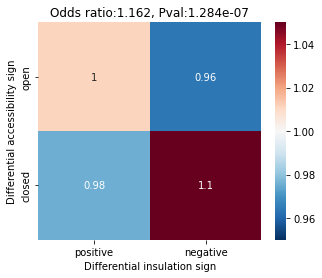

In [33]:
plt.figure(figsize=(5,4))
ax = sns.heatmap(OE, vmax=1.05, vmin=0.95, cmap='RdBu_r', annot=True)
ax.set_xlabel('Differential insulation sign')
ax.set_ylabel('Differential accessibility sign')
ax.set_title(f'Odds ratio:{round(testres[0], 3)}, Pval:{np.format_float_scientific(testres[1], 3)}')
plt.savefig('./figs/atacpeaks_vs_IS_contingency.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [233]:
#differential insulation versus peaks
DIS = pd.read_csv('subdata/IS_results.csv', index_col=0)
#DIS = DIS.sort_values('pval').iloc[:800]

In [211]:
itmp = tmp.groupby('Gene Name_x')[['ndiff']].mean().index

In [235]:
DIS.FC.mean()

0.07265310409670765

In [236]:
DIS.loc[DIS.index.isin(itmp)]#.FC.mean()

Start        End    Start_b      End_b      pval        FC  \
Name                                                                            
2410137M14Rik   37288593   37292129   37250000   37300000  0.006276 -0.091589   
D930007P13Rik  103031497  103055255  103050000  103100000  0.018207  0.075882   
Gm28578         45318052   45319186   45300000   45350000  0.001249  0.111366   

                  p_adj        ES  
Name                               
2410137M14Rik  0.017607 -0.201710  
D930007P13Rik  0.020073  0.132016  
Gm28578        0.017607  0.323336

In [243]:
DIS_x_peaks = DIS.merge(peaks.groupby('Gene Name')[['ndiff']].mean(), 
                        left_index=True, right_index=True)

In [244]:
DIS_x_peaks[['ndiff', 'FC']].corr('spearman')

ndiff        FC
ndiff  1.000000  0.050402
FC     0.050402  1.000000

## Differential peaks analysis

In [5]:
p ='/tank/projects/kriukov_chromatin/ATAC/macs/narrowPeak/consensus/deseq2/oldvsyoung/oldvsyoung.mLb.clN.deseq2.FDR0.05.results.txt'
pd.read_csv(p, sep='\t')

Geneid  Chr     Start       End Strand  Length   baseMean  \
0   Interval_2392    1  84993151  84995134      +    1984  81.332540   
1   Interval_2399    1  85243271  85243945      +     675  37.745514   
2   Interval_9563   11   3144475   3145337      +     863  83.520909   
3  Interval_17835   13  48968038  48968971      +     934  88.104915   
4  Interval_18318   13  68258038  68258681      +     644  16.826737   
5  Interval_41560    3  62338548  62339615      +    1068  27.167723   
6  Interval_57453    7  16932418  16933422      +    1005  18.928630   
7  Interval_58199    7  61614941  61615808      +     868  31.817677   
8  Interval_58210    7  61877583  61878983      +    1401  88.234219   
9  Interval_60616    8  20921986  20922501      +     516  10.226225   

   log2FoldChange     lfcSE      stat        pvalue      padj  old_R1.raw  \
0        1.224732  0.250412  4.890867  1.003926e-06  0.013712         106   
1        1.597619  0.351612  4.543696  5.527640e-06  0.047188          59   
2        1.133737  0.237336  4.776936  1.779863e-06  0.020259         111   
3       -1.368267  0.291934 -4.686914  2.773559e-06  0.027060          27   
4        2.306938  0.446648  5.164999  2.404397e-07  0.005474          29   
5       -1.582700  0.352230 -4.493371  7.010447e-06  0.047877          12   
6        1.832423  0.407632  4.495291  6.947491e-06  0.047877          28   
7        1.631447  0.313061  5.211282  1.875397e-07  0.005474          69   
8        1.255096  0.236833  5.299496  1.161226e-07  0.005474         169   
9        3.490612  0.697250  5.006256  5.549891e-07  0.009476          28   

   old_R2.raw  old_R3.raw  young_R1.raw  young_R2.raw  young_R3.raw  \
0         144         134            44            65            44   
1          72          73            18            22            22   
2         181         130            51            80            47   
3          49          70           116           131           107   
4          57          36             6            13             4   
5          11          18            38            46            31   
6          58          32            15             7             8   
7          98          42            24            22            15   
8         223          91            69            67            46   
9          32          15             1             2             3   

   old_R1.pseudo  old_R2.pseudo  old_R3.pseudo  young_R1.pseudo  \
0      93.911699     110.867326     145.764374        40.490052   
1      52.271606      55.433663      79.408950        16.564112   
2      98.341496     139.354069     141.413199        46.931652   
3      23.920904      37.725687      76.145568       106.746501   
4      25.692823      43.884983      39.160578         5.521371   
5      10.631513       8.469032      19.580289        34.968682   
6      24.806864      44.654895      34.809403        13.803427   
7      61.131200      75.451374      45.687341        22.085483   
8     149.727143     171.690372      98.989239        63.495764   
9      24.806864      24.637183      16.316908         0.920228   

   young_R2.pseudo  young_R3.pseudo  
0        53.093767        56.526340  
1        17.970198        28.263170  
2        65.346174        60.380409  
3       107.004361       137.461782  
4        10.618753         5.138758  
5        37.574050        39.825376  
6         5.717790        10.277516  
7        17.970198        19.270343  
8        54.727421        59.095719  
9         1.633654         3.854069

In [13]:
pref = '/tank/projects/kriukov_chromatin/ATAC/macs/narrowPeak/consensus/deseq2/'
dplist = natsorted(glob(pref + '/*/*deseq2.results.txt'))
dplist

['/tank/projects/kriukov_chromatin/ATAC/macs/narrowPeak/consensus/deseq2/KOvsWT/KOvsWT.mLb.clN.deseq2.results.txt',
 '/tank/projects/kriukov_chromatin/ATAC/macs/narrowPeak/consensus/deseq2/KOvsold/KOvsold.mLb.clN.deseq2.results.txt',
 '/tank/projects/kriukov_chromatin/ATAC/macs/narrowPeak/consensus/deseq2/KOvsyoung/KOvsyoung.mLb.clN.deseq2.results.txt',
 '/tank/projects/kriukov_chromatin/ATAC/macs/narrowPeak/consensus/deseq2/WTvsyoung/WTvsyoung.mLb.clN.deseq2.results.txt',
 '/tank/projects/kriukov_chromatin/ATAC/macs/narrowPeak/consensus/deseq2/oldvsWT/oldvsWT.mLb.clN.deseq2.results.txt',
 '/tank/projects/kriukov_chromatin/ATAC/macs/narrowPeak/consensus/deseq2/oldvsyoung/oldvsyoung.mLb.clN.deseq2.results.txt']

In [14]:
p = dplist[5]
deseq_peaks = pd.read_csv(p, sep='\t')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
tmp = deseq_peaks[deseq_peaks.padj < 0.1].merge(peaks, left_on='Geneid', right_on='interval_id')

In [59]:
s = (peaks.filter(regex='old').all(1) & ~peaks.filter(regex='young').any(1)).sum()
s / peaks.shape[0]

0.008653761677453364

In [73]:
t = np.random.randint(0, 2, size=(peaks.shape[0],6))

sum(~t[:, :3].any(1) & t[:,3:].all(1)) / peaks.shape[0]

0.014891498521099951

In [45]:
(0.5)**6

0.015625

In [41]:
peaks

interval_id chr     start       end  num_peaks  num_samples  WT_R1  \
0          Interval_1   1   3094953   3095639          7            7   True   
1          Interval_2   1   3119552   3120933         12           12   True   
2          Interval_3   1   3195033   3195525          1            1   True   
3          Interval_4   1   3292392   3293460          7            7   True   
4          Interval_5   1   3297635   3298319          2            2  False   
...               ...  ..       ...       ...        ...          ...    ...   
68289  Interval_68290   Y  90800452  90800758          1            1  False   
68290  Interval_68291   Y  90804811  90805245          5            5   True   
68291  Interval_68292   Y  90807111  90807842          3            3  False   
68292  Interval_68293   Y  90808445  90809289          3            3  False   
68293  Interval_68294   Y  90810652  90811000          1            1  False   

       WT_R2  WT_R3  old_R1  old_R2  old_R3  young_R1  young_R2  young_R3  \
0       True  False    True    True    True     False      True     False   
1       True   True    True    True    True      True      True      True   
2      False  False   False   False   False     False     False     False   
3       True  False    True    True   False      True      True     False   
4      False  False   False   False    True     False     False     False   
...      ...    ...     ...     ...     ...       ...       ...       ...   
68289  False   True   False   False   False     False     False     False   
68290  False  False   False    True   False     False     False      True   
68291   True  False   False    True   False      True     False     False   
68292  False   True    True    True   False     False     False     False   
68293  False  False   False   False   False      True     False     False   

       Distance to TSS Gene Name  length  absTSS  
0                -6720   Gm26206     686    6720  
1                18227   Gm26206    1381   18227  
2                21065      Xkr4     492   21065  
3                40169   Gm18956    1068   40169  
4                45220   Gm18956     684   45220  
...                ...       ...     ...     ...  
68289            15867     Erdr1     306   15867  
68290            20290     Erdr1     434   20290  
68291            22739     Erdr1     731   22739  
68292            24129     Erdr1     844   24129  
68293            26088     Erdr1     348   26088  

[68294 rows x 19 columns]

# RNA-seq DE analysis

In [ ]:
gdf = gn_code[['seq_id', 'start', 'end', 'Name', 'length']].merge(
        slopes[['logFC', 'P.Value', 'adj.P.Val', 'symbol']], 
        left_on='Name', right_on='symbol')
gdf

## pseudo-bulk and Single-cell Differential Expression

* [scanpy](https://scanpy.readthedocs.io/en/stable/) - for reading scRNA files
* [diffxpy](https://github.com/theislab/diffxpy) - for DE analysis

In [12]:
pbulk_full = pd.read_csv('subdata/DE_results_GSE129788_old::young.csv', index_col=0)
pbulk_neur = pd.read_csv('subdata/DE_results_GSE129788_old::young_mNeur.csv', index_col=0)
sc_neur =  pd.read_csv('subdata/scDE_results_GSE129788_old::young.csv', index_col=0)
sc_asc = pd.read_csv('subdata/scDE_ASC_results_GSE129788_old::young.csv', index_col=0)

In [13]:
#delicate preprocessing
pbulk_neur['Name'] = pbulk_neur.index
sc_neur.columns = ['Name', 'pval_sc', 'qval', 'FC_sc', 'mean', 'zero_mean', 'zero_variance']
sc_neur[['FC_sc', 'mean']] = sc_neur[['FC_sc', 'mean']] * -1

In [14]:
tmp = pbulk_full[['Name', 'FC', 'pval']].\
        merge(pbulk_neur[['Name', 'FC', 'pval']], on='Name', suffixes=('_full', '_neur')).\
        merge(sc_neur[['Name', 'FC_sc', 'pval_sc', ]], on='Name')

In [15]:
tmp1 = pbulk_full[['Name', 'FC', 'pval']].\
        merge(pbulk_neur[['Name', 'FC', 'pval']], on='Name', suffixes=('_full', '_neur')).\
        merge(sc_neur[['Name', 'FC_sc', 'pval_sc']], on='Name').\
        merge(slopes[['symbol', 'logFC', 'P.Value']], left_on='Name', right_on='symbol')

In [98]:
tmp1[['FC_full', 'FC_neur', 'FC_sc', 'logFC']].corr('spearman')

FC_full   FC_neur     FC_sc     logFC
FC_full  1.000000  0.855829  0.797948  0.189851
FC_neur  0.855829  1.000000  0.916130  0.318401
FC_sc    0.797948  0.916130  1.000000  0.334693
logFC    0.189851  0.318401  0.334693  1.000000

In [99]:
tmp1[['pval_full', 'pval_neur', 'pval_sc', 'P.Value']].corr(method='spearman')

pval_full  pval_neur   pval_sc   P.Value
pval_full   1.000000   0.716657  0.590152  0.137034
pval_neur   0.716657   1.000000  0.764639  0.113051
pval_sc     0.590152   0.764639  1.000000  0.131242
P.Value     0.137034   0.113051  0.131242  1.000000

In [16]:
#sns.pairplot(tmp1[['FC_full', 'FC_neur', 'FC_sc', 'logFC']])

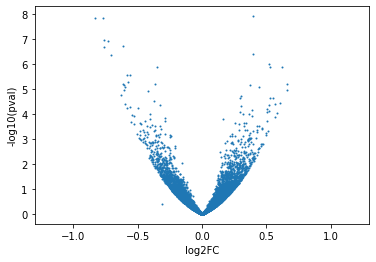

In [6]:
plt.scatter(tmp.FC_full, -np.log10(tmp.pval_full), s=1)
plt.xlim([-1.3, 1.3])
plt.xlabel('log2FC')
plt.ylabel('-log10(pval)')
plt.show()

In [109]:
tmp[np.abs(tmp.FC_sc) > 1.0]

Name   FC_full  pval_full   FC_neur  pval_neur     FC_sc  \
1471      Pgk1  0.296556   0.031619  0.240604   0.049926  1.133841   
4747   Bloc1s1  0.661942   0.000006  0.649932   0.000004  1.042531   
5717      Sik2  0.583387   0.000094  0.518264   0.000303  1.002908   
6434    Rpl23a  0.431626   0.002631  0.498751   0.000213  1.300823   
8340  AY036118  0.323685   0.010216  0.207104   0.037636  1.341483   

           pval_sc  
1471  3.231555e-11  
4747  5.800050e-09  
5717  2.276027e-06  
6434  7.144328e-32  
8340  1.225993e-09

## Aging genes and corresponding loops

In [21]:
genage = pd.read_csv('subdata/geneage.csv', sep='\t')

In [39]:
sub1 = sc_neur[sc_neur['Name'].isin(genage['Gene Symbol'])]
sub2 = sub1[(sub1.qval < 0.05) & (np.abs(sub1.FC_sc) < 100)]

In [50]:
sub3 = sub2.merge(gn_code, on='Name')
sub3

Name   pval_sc      qval     FC_sc      mean  zero_mean  zero_variance  \
0   Apoe  0.000014  0.001076 -0.168947 -1.234060      False          False   
1  Gsk3a  0.000246  0.009823 -0.365277 -0.226333      False          False   
2  Socs2  0.002589  0.049667  0.317695 -0.223659      False          False   
3   Irs2  0.001582  0.035927  0.560533 -0.077745      False          False   
4   Jund  0.000165  0.007450  0.186513 -0.800952      False          False   
5    Mt1  0.001220  0.030527 -0.105059 -1.505994      False          False   

  seq_id               source  type     start       end score strand  \
0   chr7  BestRefSeq%2CGnomon  gene  19430169  19434326     .      -   
1   chr7  BestRefSeq%2CGnomon  gene  24927683  24937276     .      -   
2  chr10  BestRefSeq%2CGnomon  gene  95219765  95253176     .      -   
3   chr8           BestRefSeq  gene  11034681  11058929     .      -   
4   chr8           BestRefSeq  gene  71150389  71153265     .      +   
5   chr8  BestRefSeq%2CGnomon  gene  94905214  94906955     .      +   

           ID                         description  length chromosome  
0   gene-Apoe                    apolipoprotein E    4157       None  
1  gene-Gsk3a    glycogen synthase kinase 3 alpha    9593       None  
2  gene-Socs2  suppressor of cytokine signaling 2   33411       None  
3   gene-Irs2        insulin receptor substrate 2   24248       None  
4   gene-Jund                jun D proto-oncogene    2876       None  
5    gene-Mt1                   metallothionein 1    1741       None

In [46]:
LOOP_PATH

'/tank/projects/kriukov_chromatin/HIC/loops'

In [47]:
!ls /tank/projects/kriukov_chromatin/HIC/loops

combined_KO_down_10000.json  combined_old_down_10000.json
combined_KO_down_10000.pdf   combined_old_down_10000.pdf
combined_KO_down_10000.tsv   combined_old_down_10000.tsv
combined_KO_down_50000.json  combined_old_down_50000.json
combined_KO_down_50000.pdf   combined_old_down_50000.pdf
combined_KO_down_50000.tsv   combined_old_down_50000.tsv
combined_WT_down_10000.json  combined_young_down_10000.json
combined_WT_down_10000.pdf   combined_young_down_10000.pdf
combined_WT_down_10000.tsv   combined_young_down_10000.tsv
combined_WT_down_50000.json  combined_young_down_50000.json
combined_WT_down_50000.pdf   combined_young_down_50000.pdf
combined_WT_down_50000.tsv   combined_young_down_50000.tsv


In [60]:
loops = pd.read_csv(LOOP_PATH + '/' + 'combined_old_down_50000.tsv', sep='\t')

In [66]:
IS_int = bins_to_genes_intersection(IS[['chrom', 'start', 'end']], 
                           sub3, 
                           genes_cols=['seq_id', 'start', 'end'])

In [73]:
ttt = IS.merge(IS_int, left_on=['chrom', 'start', 'end'], 
         right_on=['Chromosome', 'Start_b', 'End_b'])

In [95]:
j = 0

for j in range(ttt.shape[0]):
    m1 = CLRS[2].matrix(balance=False).\
            fetch(f'%s:%d-%d' % (ttt.loc[j, 'chrom'], ttt.loc[j, 'start'], ttt.loc[j, 'end']))

    m2 = CLRS[3].matrix(balance=False).\
            fetch(f'%s:%d-%d' % (ttt.loc[j, 'chrom'], ttt.loc[j, 'start'], ttt.loc[j, 'end']))
    print(ttt.loc[j, 'Name'], np.mean(m1 / m2))

Apoe 1.2224764410115596
Gsk3a 1.256697818056287
Irs2 1.2503203419774913
Irs2 1.348285541718829
Jund nan
Mt1 1.1551237986929095
Socs2 1.2765518484862506
Socs2 1.1726308862143917


'Apoe'

'1'

## Expression slopes

In [34]:
gexp = sc_neur[(sc_neur.zero_mean == False) | (sc_neur.zero_variance == False)]
gexp = gexp[np.abs(gexp.log2fc) < 100]
gexp = gexp[gexp.qval < 0.05]

In [35]:
gdf = gn_code[['seq_id', 'start', 'end', 'Name', 'length']].merge(
        gexp[['gene', 'log2fc', 'pval', 'qval', 'mean']], 
        left_on='Name', right_on='gene')

In [134]:
#gdf = gdf[gdf['length'] < 50_000]

In [36]:
intervals = bins_to_genes_intersection(IS[['chrom', 'start', 'end']], gdf, 
                                       genes_cols=['seq_id', 'start', 'end'])

In [37]:
intervals_pos_exp = intervals[intervals.log2fc > 0][['Chromosome', 'Start_b', 'End_b', 'log2fc', 'gene']]
intervals_neg_exp = intervals[intervals.log2fc < 0][['Chromosome', 'Start_b', 'End_b', 'log2fc', 'gene']]

intervals_pos_exp = intervals_pos_exp.merge(IS, 
                        left_on=['Chromosome', 'Start_b', 'End_b'], 
                        right_on=['chrom', 'start', 'end']).dropna(0)
intervals_neg_exp = intervals_neg_exp.merge(IS, 
                        left_on=['Chromosome', 'Start_b', 'End_b'], 
                        right_on=['chrom', 'start', 'end']).dropna(0)

igr_pos = intervals_pos_exp.groupby('gene').mean()
igr_neg = intervals_neg_exp.groupby('gene').mean()

IS_pos_exp = intervals_pos_exp.filter(regex='young|old|WT')
IS_neg_exp = intervals_neg_exp.filter(regex='young|old|WT')

/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  
/home/dkriukov/miniconda3/envs/mice/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  if __name__ == '__main__':


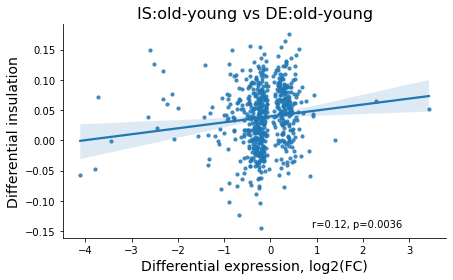

In [57]:
pair = ('old', 'young')
data = pd.concat([igr_pos, igr_neg])

name = 'IS:' + pair[0] + '-' + pair[1]
data[name] = data.filter(regex=pair[0]).mean(1) -\
                                 data.filter(regex=pair[1]).mean(1)
g = sns.lmplot(y=name, x='log2fc', data=data, height=4, aspect=1.6, scatter_kws={"s": 10})

def annotate(data, **kws):
    from scipy import stats
    r, p = stats.pearsonr(data['log2fc'], data[name],)
    ax = plt.gca()
    ax.text(.65, .05, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)
    ax.set_xlabel('Differential expression, log2(FC)', fontsize=14)
    ax.set_ylabel('Differential insulation', fontsize=14)
    ax.set_title(name + ' vs DE:old-young', fontsize=16)
    
g.map_dataframe(annotate)
plt.savefig('./figs/DE_vs_IS_lmplot.pdf', dpi=300, bbox_inches='tight')


In [49]:
data.head(3)

Start_b       End_b    log2fc    index  combined_KO_down_50000  \
gene                                                                        
Ablim2  35950000.0  36000000.0  0.361657  14604.0                0.061535   
Actn1   80250000.0  80300000.0  0.326235  34568.0               -0.140611   
Actr1b  36700000.0  36750000.0  0.226389    734.0               -0.278544   

        combined_WT_down_50000  combined_old_down_50000  \
gene                                                      
Ablim2               -0.028104                 0.047647   
Actn1                -0.245894                -0.133324   
Actr1b               -0.425711                -0.361091   

        combined_young_down_50000       start         end  IS:old-young  
gene                                                                     
Ablim2                  -0.012316  35950000.0  36000000.0      0.059963  
Actn1                   -0.206974  80250000.0  80300000.0      0.073650  
Actr1b                  -0.427528  36700000.0  36750000.0      0.066437

In [50]:
ct = np.zeros((2,2)) #DIS:[pos, neg], Dpeaks:[]
ct[0,0] = np.sum((np.sign(data['log2fc']) > 0) & (np.sign(data['IS:old-young']) > 0))
ct[0,1] = np.sum((np.sign(data['log2fc']) < 0) & (np.sign(data['IS:old-young']) > 0))
ct[1,0] = np.sum((np.sign(data['log2fc']) > 0) & (np.sign(data['IS:old-young']) < 0))
ct[1,1] = np.sum((np.sign(data['log2fc']) < 0) & (np.sign(data['IS:old-young']) < 0))

In [51]:
from scipy.stats import chi2_contingency, fisher_exact
from scipy.stats.contingency import expected_freq
testres = fisher_exact(ct)
print(f'Odds:{testres[0]}, Pval:{testres[1]}')
OE = pd.DataFrame(ct / expected_freq(ct), columns=['positive', 'negative'], index=['positive', 'negative'])

Odds:2.16796875, Pval:0.0003828138467463926


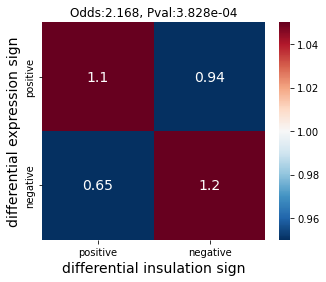

In [56]:
plt.figure(figsize=(5,4))
ax = sns.heatmap(OE, vmax=1.05, vmin=0.95, cmap='RdBu_r', annot=True, annot_kws={"fontsize":14})
ax.set_xlabel('differential insulation sign', fontsize=14)
ax.set_ylabel('differential expression sign', fontsize=14)
ax.set_title(f'Odds:{round(testres[0], 3)}, Pval:{np.format_float_scientific(testres[1], 3)}')
plt.savefig('./figs/DE_vs_IS_contingency.pdf', dpi=300, bbox_inches='tight')
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.155e-07 U_stat=1.305e+06
young v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.223e-02 U_stat=1.528e+06
young v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.246e-02 U_stat=1.374e+06


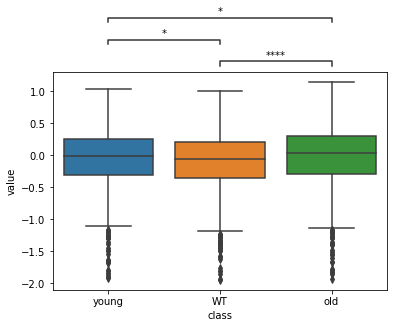

In [49]:
from statannot import add_stat_annotation

tmp = pd.melt(IS_pos_exp)
tmp['class'] = tmp.variable.apply(lambda x: x.split('_')[0])

x = "class"
y = "value"
order = ['young', 'WT', 'old']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("old", "WT"), ("WT", "young"), ('old', 'young')],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

WT v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.202e-01 U_stat=1.460e+05
young v.s. WT: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.603e+05
young v.s. old: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.506e+05


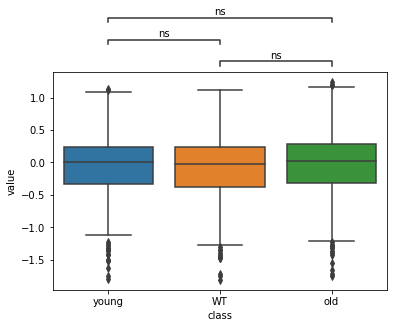

In [50]:
tmp = pd.melt(IS_neg_exp)
tmp['class'] = tmp.variable.apply(lambda x: x.split('_')[0])

x = "class"
y = "value"
order = ['young', 'WT', 'old']
ax = sns.boxplot(data=tmp, x=x, y=y, order=order)
test_results = add_stat_annotation(ax, data=tmp, x=x, y=y, order=order,
                                   box_pairs=[("old", "WT"), ("WT", "young"), ('old', 'young')],
                                   test='Mann-Whitney', text_format='star',
                                   loc='outside', verbose=2)